This notebook contains the scripts to 
 - classical models method
 - modèle sur mesure avancé
 - BERT models method

# Importing libraries

In [2]:
# Set up logging
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
from utils import *

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


INFO:numexpr.utils:Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [4]:

import nltk
from nltk.tokenize import TweetTokenizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('all')

import spacy
from spacy.tokens import Token

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/bartcus/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/bartcus/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/bartcus/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/bartcus/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/bartcus/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading pa

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, plot_confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [6]:
nlp = spacy.load("en_core_web_sm")

nltk.download("stopwords")
nltk.download("wordnet")
stopwords = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bartcus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/bartcus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
import re
import string
from unidecode import unidecode
import os
from pandarallel import pandarallel
from tqdm import tqdm

In [8]:
handle_regex = r"@[\w\d_]+"
like_handle = lambda token: re.fullmatch(handle_regex, token.text)
Token.set_extension("like_handle", getter=like_handle)

In [9]:
import keras
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential


from keras.models import load_model
from keras.layers import Input, TextVectorization, Dense, Dropout, Activation, Embedding, Flatten, SimpleRNN, MaxPooling1D
from keras.callbacks import TensorBoard, EarlyStopping
from keras.metrics import AUC

from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig

In [10]:
print(tf.__version__)

2.9.0


First we imort the data and analyse it as it is. This is followed by some data preprocessing, here text preprocessing by using nltk and spacy packages.

# Data importing and preprocessing

In [29]:
data = pd.read_csv("data/training.1600000.processed.noemoticon.csv", encoding='ISO-8859-1',
            header=None, usecols = [0, 5], names=['Target', 'Text'])
data = reduce_dataframe_memory_usage(data)
data.head()

Memory usage of dataframe is 24.41 MB
Memory usage after optimization is 15.26 MB
Decreased by 37 %%


Target                                               Text
0       0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1       0  is upset that he can't update his Facebook by ...
2       0  @Kenichan I dived many times for the ball. Man...
3       0    my whole body feels itchy and like its on fire 
4       0  @nationwideclass no, it's not behaving at all....

In [30]:
data.Target.unique()

<IntegerArray>
[0, 4]
Length: 2, dtype: Int8

In [31]:
data.shape

(1600000, 2)

In [32]:
data.nunique()

Target          2
Text      1581466
dtype: int64

First, note the positive tweets are labeled with 4 and negative tweets are labeled with 0. We change it so that negative tweets coresponds to 0 and positive tweets to 1.

In [33]:
data['Target'] = data['Target'].apply(lambda x: 1 if(x==4) else 0)

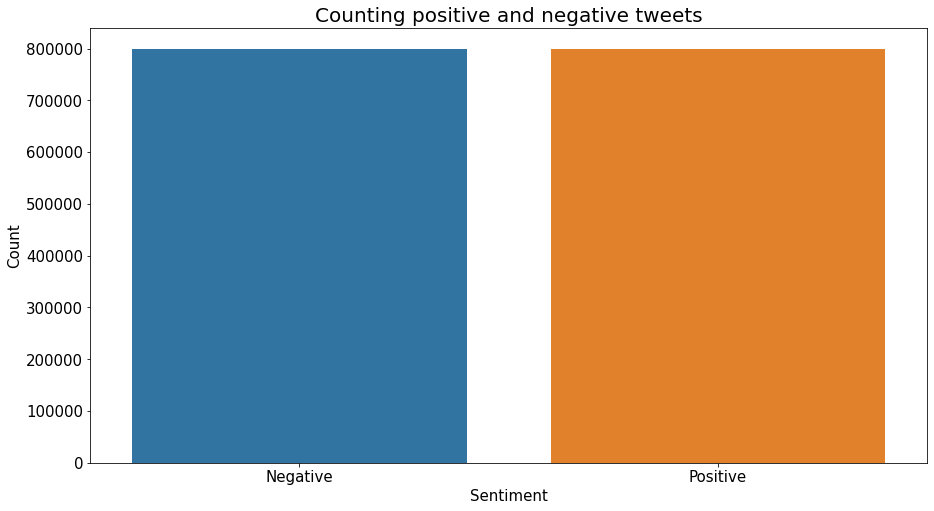

In [34]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x='Target', data=data)
plt.title('Counting positive and negative tweets', fontsize=20);
plt.ylabel('Count', fontsize=15);
plt.xlabel('Sentiment', fontsize=15);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
ax.set_xticklabels(['Negative', 'Positive']);

In [35]:
data[data['Target'] == 0].head()

Target                                               Text
0       0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1       0  is upset that he can't update his Facebook by ...
2       0  @Kenichan I dived many times for the ball. Man...
3       0    my whole body feels itchy and like its on fire 
4       0  @nationwideclass no, it's not behaving at all....

In [36]:
data[data['Target'] == 1].head()

Target                                               Text
800000       1       I LOVE @Health4UandPets u guys r the best!! 
800001       1  im meeting up with one of my besties tonight! ...
800002       1  @DaRealSunisaKim Thanks for the Twitter add, S...
800003       1  Being sick can be really cheap when it hurts t...
800004       1    @LovesBrooklyn2 he has that effect on everyone

Sampling the data to take 10000 with positive and negative tweets

In [19]:
data = pd.concat([data[data['Target']==0].iloc[:10000], data[data['Target']==1].iloc[-10000:]])
data = data.reset_index(drop=True)

In [20]:
data

Target                                               Text
0           0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1           0  is upset that he can't update his Facebook by ...
2           0  @Kenichan I dived many times for the ball. Man...
3           0    my whole body feels itchy and like its on fire 
4           0  @nationwideclass no, it's not behaving at all....
...       ...                                                ...
19995       1  Just woke up. Having no school is the best fee...
19996       1  TheWDB.com - Very cool to hear old Walt interv...
19997       1  Are you ready for your MoJo Makeover? Ask me f...
19998       1  Happy 38th Birthday to my boo of alll time!!! ...
19999       1  happy #charitytuesday @theNSPCC @SparksCharity...

[20000 rows x 2 columns]

***Tokenization with spacy***

In [37]:
# Définition de la fonction de nettoyage

def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow' or token == '2moro':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token in ['hahah', 'hahaha', 'hahahaha']:
        return 'haha'
    if token == "mother's":
        return "mother"
    if token == "mom's":
        return "mom"
    if token == "dad's":
        return "dad"
    if token == 'bday' or token == 'b-day':
        return 'birthday'
    if token in ["i'm", "don't", "can't", "couldn't", "aren't", "wouldn't", "isn't", "didn't", "hadn't",
                 "doesn't", "won't", "haven't", "wasn't", "hasn't", "shouldn't", "ain't", "they've"]:
        return token.replace("'", "")
    if token in ['lmao', 'lolz', 'rofl']:
        return 'lol'
    if token == '<3':
        return 'love'
    if token == 'thanx' or token == 'thnx':
        return 'thanks'
    if token == 'goood':
        return 'good'
    if token in ['amp', 'quot', 'lt', 'gt', '½25', '..', '. .', '. . .']:
        return ''
    return token

def clean(text) :
    doc = nlp(text)
    
    tokens = [
        cleaned(unidecode(token.lemma_.lower())) for token in doc 
        if (not token.is_punct
        and not token.is_currency
        and not token.is_space
        and not token.is_stop
        and not token.like_email
        and not token.like_url 
        and not token.like_num
        #and not token.is_oov #out of vocabulary
        and len(token) > 1 
        and not token.ent_type_ == "PERSON" 
        and not token.ent_type_ == "ORG" 
        and not token._.like_handle)
    ]

    #Stemming
    st = PorterStemmer()
    tokens = [st.stem(tk) for tk in tokens] 
    
    return ' '.join(tokens)


def clean_2(text) :
    '''
    clean without steaming
    '''
    doc = nlp(text)
    
    tokens = [
        cleaned(unidecode(token.lemma_.lower())) for token in doc 
        if (not token.is_punct
        and not token.is_currency
        and not token.is_space
        and not token.is_stop
        and not token.like_email
        and not token.like_url 
        and not token.like_num
        and len(token) > 1 
        and not token.ent_type_ == "PERSON"
        and not token.ent_type_ == "ORG"
        and not token._.like_handle)
    ]
    
    return ' '.join(tokens)

def clean_3(text) :
    '''
    clean without steaming
    '''
    doc = nlp(text)
    
    tokens = [
        cleaned(unidecode(token.lemma_.lower())) for token in doc 
        if (not token.is_punct
        and not token.is_space
        and not token.is_stop
        and not token.like_email
        and not token.like_url 
        and not token.like_num
        )
    ]
    
    return ' '.join(tokens)

def clean_1_ch(text) :
    doc = nlp(text)
    
    tokens = [
        token for token in doc 
        if (len(token) > 1)
    ]
    
    return ' '.join(map(str, tokens))

In [38]:
def cleaning_links(text):
    return re.sub(r'(https|http|)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)

def cleaning_email(text):
    # cleaning email and mentions
    return re.sub("(@[A-Za-z0-9_]+)","", text)

def cleaning_numbers(text):
    return re.sub('[0-9]+', '', text)

#removing emojis from string
def de_emojify(text):
    regex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F" 
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
                           "]+", flags = re.UNICODE)
    return regex_pattern.sub(r'', text)

def cleaning_punctuations(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def all_cleaning(text):
    text = cleaning_links(text)
    text = cleaning_email(text)
    text = de_emojify(text)
    text = cleaning_numbers(text)
    text = cleaning_punctuations(text)
    return text

In [39]:
%%time
if os.path.exists("data/processed/processed_nlp_data_full.pkl.gz"):
    logger.info(">>> Loading cleaned and preprocessed data...")
    data = pd.read_pickle("data/processed/processed_nlp_data.pkl.gz")
    logger.info(f">>> OK : {len(data)} data loaded from pickle file.")
else:
    logger.info(">>> Data cleaning and preprocessing...")
    pandarallel.in’itialize()
    data['CleanTextSpacy'] = data.Text.parallel_apply(lambda x: clean_3(x))
    data['CleanText']= data.CleanTextSpacy.apply(lambda x: all_cleaning(x))
    data['CleanText']= data.CleanText.parallel_apply(lambda x: clean_1_ch(x))
    data = data[data.CleanText!='']
    data.to_pickle("data/processed/processed_nlp_data_full.pkl.gz")

INFO:__main__:>>> Data cleaning and preprocessing...


INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 35.2 s, sys: 1.11 s, total: 36.4 s
Wall time: 22min 33s


In [24]:
%%time
# without steaming
if os.path.exists("data/processed/processed_nlp_data_2.pkl.gz"):
    logger.info(">>> Loading cleaned and preprocessed data without steaming...")
    data = pd.read_pickle("data/processed/processed_nlp_data_2.pkl.gz")
    logger.info(f">>> OK : {len(data)} data loaded from pickle file.")
else:
    logger.info(">>> Data cleaning and preprocessing without steaming...")
    pandarallel.initialize()
    data['CleanTextSpacy'] = data.Text.parallel_apply(lambda x: clean_2(x))
    data['CleanText']= data.CleanTextSpacy.apply(lambda x: all_cleaning(x))
    data['CleanText']= data.CleanText.parallel_apply(lambda x: clean_1_ch(x))
    data = data[data.CleanText!='']
    data.to_pickle("data/processed/processed_nlp_data_2.pkl.gz")

INFO:__main__:>>> Data cleaning and preprocessing without steaming...


INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


<timed exec>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 445 ms, sys: 126 ms, total: 572 ms
Wall time: 17.3 s


In [23]:
%%time
# without steaming
if os.path.exists("data/processed/processed_nlp_data_3.pkl.gz"):
    logger.info(">>> Loading cleaned and preprocessed data without steaming...")
    data = pd.read_pickle("data/processed/processed_nlp_data_3.pkl.gz")
    logger.info(f">>> OK : {len(data)} data loaded from pickle file.")
else:
    logger.info(">>> Data cleaning and preprocessing without steaming...")
    pandarallel.initialize()
    data['CleanTextSpacy'] = data.Text.parallel_apply(lambda x: clean_3(x))
    data['CleanText']= data.CleanTextSpacy.apply(lambda x: all_cleaning(x))
    data['CleanText']= data.CleanText.parallel_apply(lambda x: clean_1_ch(x))
    data = data[data.CleanText!='']
    data.to_pickle("data/processed/processed_nlp_data_3.pkl.gz")

INFO:__main__:>>> Data cleaning and preprocessing without steaming...


INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 463 ms, sys: 127 ms, total: 590 ms
Wall time: 17.5 s


In [25]:
data.head()

Target                                               Text  \
0       0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1       0  is upset that he can't update his Facebook by ...   
2       0  @Kenichan I dived many times for the ball. Man...   
3       0    my whole body feels itchy and like its on fire    
4       0  @nationwideclass no, it's not behaving at all....   

                                      CleanTextSpacy  \
0                     awww bummer shoulda get day ;d   
1  upset update facebook texte cry result school ...   
2              dive time ball manage save rest bound   
3                          body feel itchy like fire   
4                                         behave mad   

                                           CleanText  
0                        awww bummer shoulda get day  
1  upset update facebook texte cry result school ...  
2              dive time ball manage save rest bound  
3                          body feel itchy like fire  
4                                         behave mad

In [26]:
data = data.drop(['CleanTextSpacy', 'Text'], axis=1)
data.head()

Target                                          CleanText
0       0                        awww bummer shoulda get day
1       0  upset update facebook texte cry result school ...
2       0              dive time ball manage save rest bound
3       0                          body feel itchy like fire
4       0                                         behave mad

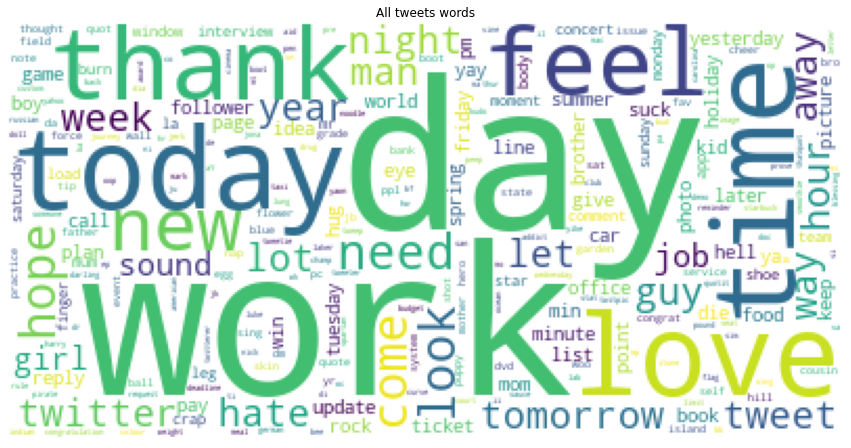

In [27]:
word_count_all = pd.DataFrame(pd.DataFrame(data).CleanText.str.split(expand=True).stack().value_counts())
word_count_all = word_count_all.reset_index()
word_count_all.columns=['word', 'count']
plot_words(word_count_all, col='word', height = 15, wieght = 10, max_words = 1000, titl='All tweets words')

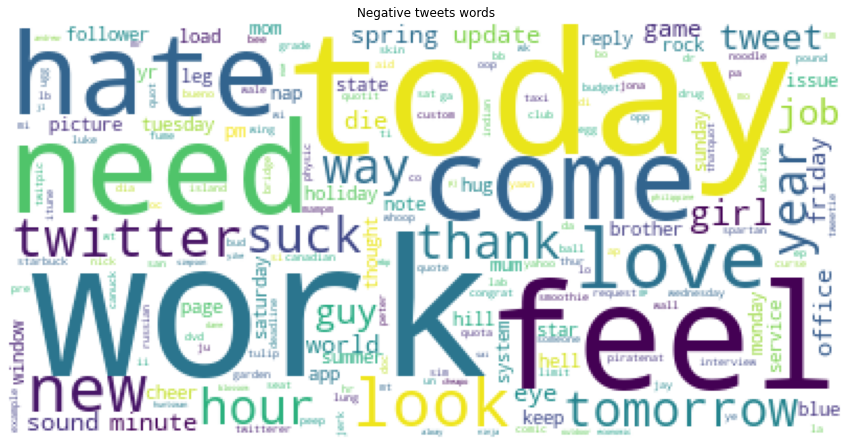

In [28]:
word_count_bad = pd.DataFrame(pd.DataFrame(data.head(10000)).CleanText.str.split(expand=True).stack().value_counts())
word_count_bad = word_count_bad.reset_index()
word_count_bad.columns=['word', 'count']
plot_words(word_count_bad, col='word', height = 15, wieght = 10, max_words = 1000, titl='Negative tweets words')

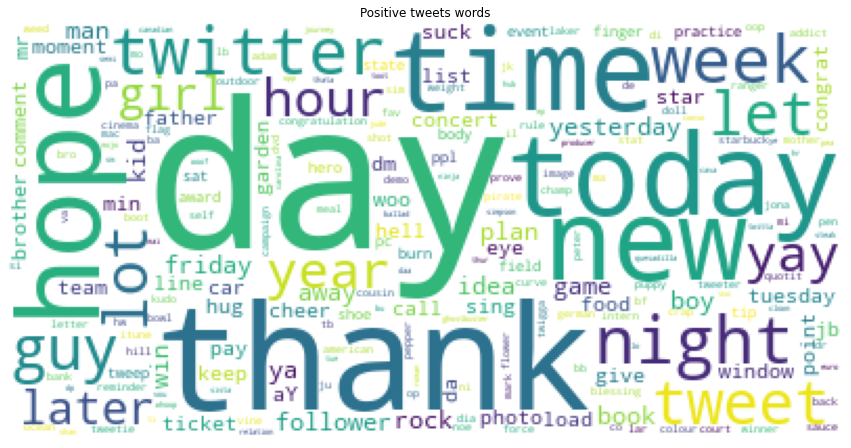

In [29]:
word_count_good = pd.DataFrame(pd.DataFrame(data.tail(10000)).CleanText.str.split(expand=True).stack().value_counts())
word_count_good = word_count_good.reset_index()
word_count_good.columns=['word', 'count']
plot_words(word_count_good, col='word', height = 15, wieght = 10, max_words = 1000, titl='Positive tweets words')

# Data vectorization

Data vectorization can be executed by ising the TfidfVectorizer or by the embedding words. In this work I used the Glove and Word2Vec embedding. 

In Language Model, words are represented in a way to intend more meaning and for learning the patterns and contextual meaning behind it.

Word Embedding is one of the popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

Basically, it's a feature vector representation of words which are used for other natural language processing applications.

We could train the embedding ourselves but that would take a while to train and it wouldn't be effective. So going in the path of Computer Vision, here we use Transfer Learning. We download the pre-trained embedding and use it in our model.

The pretrained Word Embedding like GloVe & Word2Vec gives more insights for a word which can be used for classification. 

## Vectorizing the dataset using TfidfVectorizer

In [31]:
pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data' + pkl_extension
vocabulary_file_path = vectorized_dataset_path + 'vocabulary_data' + pkl_extension
                
if (not os.path.exists('data/processed/')):
    os.makedirs("data/processed/", exist_ok=True)

if (not os.path.exists(vectorized_dataset_path)):
    os.makedirs(vectorized_dataset_path, exist_ok=True)
        
with timer("Data vectorization with Tfidf"):
    if os.path.exists(vectorized_dataset_file_path):
        logger.info(">>> Loading Tfidf Vectorized data...")
        
        # Load vectorized dataset
        with (open(vectorized_dataset_file_path, "rb")) as f:
            X = pickle.load(f)
        # Load vocabulary
        with (open(vocabulary_file_path, "rb")) as f:
            vocabulary = pickle.load(f)
    else:
        logger.info(">>> Creating Tfidf Vectorized data...")
        vect = TfidfVectorizer()
        X = vect.fit_transform(data.CleanText)
        vocabulary = vect.get_feature_names_out()
        
        # Save vectorized dataset as pickle
        with open(vectorized_dataset_file_path, "wb") as f:
            pickle.dump(X, f)

        # Save vocabulary as pickle
        with open(vocabulary_file_path, "wb") as f:
            pickle.dump(vocabulary, f)

INFO:__main__:>>> Loading Tfidf Vectorized data...


Data vectorization with Tfidf - done in 0s


## Vectorize with spacy

In [32]:
pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data_spacy' + pkl_extension

if (not os.path.exists('data/processed/')):
    os.makedirs("data/processed/", exist_ok=True)

if (not os.path.exists(vectorized_dataset_path)):
    os.makedirs(vectorized_dataset_path, exist_ok=True)
        
with timer("Data vectorization with Spacy"): 
    if os.path.exists(vectorized_dataset_file_path):
        logger.info(">>> Loading Spacy Vectorized data...")
        
        # Load vectorized dataset
        with (open(vectorized_dataset_file_path, "rb")) as f:
            X = pickle.load(f)
    else:
        logger.info(">>> Creating Spacy Vectorized data...")
        # Encode text
        X = [nlp(doc).vector for doc in tqdm(data.CleanText)]
        X = np.vstack(X)
        
        # Save vectorized dataset as pickle
        with open(vectorized_dataset_file_path, "wb") as f:
            pickle.dump(X, f)

INFO:__main__:>>> Creating Spacy Vectorized data...
100%|████████████████████████████████████| 19773/19773 [00:49<00:00, 400.85it/s]

Data vectorization with Spacy - done in 49s


## Vectorizing the dataset using Doc2Vec

In [33]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data_doc2vec' + pkl_extension

if (not os.path.exists('data/processed/')):
    os.makedirs("data/processed/", exist_ok=True)
    
if (not os.path.exists(vectorized_dataset_path)):
    os.makedirs(vectorized_dataset_path, exist_ok=True)

with timer("Data vectorization with Doc2Vec"):
    if os.path.exists(vectorized_dataset_file_path):  
        logger.info(">>> Loading Doc2Vec Vectorized data...")
        with (open(vectorized_dataset_file_path, "rb")) as f:
            X = pickle.load(f)
    else:
        logger.info(">>> Creating Doc2Vec Vectorized data...")
        documents = [text.split() for text in data.CleanText]
        # Tag documents for training
        X = [TaggedDocument(doc, [i]) for i, doc in enumerate(documents)]

        # Train doc2vec model
        doc2vec = Doc2Vec()
        doc2vec.build_vocab(X)
        doc2vec.train(X, total_examples=doc2vec.corpus_count, epochs=doc2vec.epochs)

        # Vectorize text
        X = [doc2vec.infer_vector(doc.words) for doc in X]
        X = np.vstack(X)

        # Save vectorized dataset as pickle
        with open(vectorized_dataset_file_path, "wb") as f:
            pickle.dump(X, f)

INFO:__main__:>>> Creating Doc2Vec Vectorized data...
INFO:gensim.utils:Doc2Vec lifecycle event {'params': 'Doc2Vec<dm/m,d100,n5,w5,mc5,s0.001,t3>', 'datetime': '2022-09-22T09:46:37.823546', 'gensim': '4.2.0', 'python': '3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) \n[Clang 13.0.1 ]', 'platform': 'macOS-12.4-arm64-arm-64bit', 'event': 'created'}
INFO:gensim.models.doc2vec:collecting all words and their counts
INFO:gensim.models.doc2vec:PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
INFO:gensim.models.doc2vec:PROGRESS: at example #10000, processed 58875 words (5531501 words/s), 9873 word types, 0 tags
INFO:gensim.models.doc2vec:collected 15724 word types and 19773 unique tags from a corpus of 19773 examples and 113739 words
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Doc2Vec lifecycle event {'msg': 'effective_min_count=5 retains 2709 unique words (17.23% of original 15724, drops 13015)', 'datetime': '2022-09

Data vectorization with Doc2Vec - done in 6s


## Vectorizing using Glove

In [34]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip

In [35]:
pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data_glove' + pkl_extension
embedding_matrix_file_path = vectorized_dataset_path + 'embedding_matrix_glove' + pkl_extension

if (not os.path.exists('data/processed/')):
    os.makedirs("data/processed/", exist_ok=True)
    
if (not os.path.exists(vectorized_dataset_path)):
    os.makedirs(vectorized_dataset_path, exist_ok=True)
    
with timer("Data vectorization with Glove"):
    if os.path.exists(vectorized_dataset_file_path):  
        logger.info(">>> Loading Glove Vectorized data...")
        with (open(vectorized_dataset_file_path, "rb")) as f:
            X = pickle.load(f)
        with (open(embedding_matrix_file_path, "rb")) as f:
            embedding_matrix = pickle.load(f)
    else:
        v_size = 100
        logger.info(">>> Creating Glove Vectorized data...")
        
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(data.CleanText)

        word_index = tokenizer.word_index
        vocab_size = len(tokenizer.word_index) + 1
        print("Vocabulary Size :", vocab_size)
        
        X = pad_sequences(tokenizer.texts_to_sequences(data.CleanText),
                        maxlen = v_size)
        
        
        LR = 1e-3
        BATCH_SIZE = 1024
        EPOCHS = 10
        
        embeddings_index = {}

        f = open('glove.6B.100d.txt')
        for line in f:
            values = line.split()
            word = value = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()

        print('Found %s word vectors.' %len(embeddings_index))
        
        embedding_matrix = np.zeros((vocab_size, v_size))
        for word, i in word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                
        # Save vectorized dataset as pickle
        with open(vectorized_dataset_file_path, "wb") as f:
            pickle.dump(X, f)
            
        # Save vocabulary as pickle
        with open(embedding_matrix_file_path, "wb") as f:
            pickle.dump(embedding_matrix, f)

INFO:__main__:>>> Creating Glove Vectorized data...


Vocabulary Size : 15723
Found 400000 word vectors.
Data vectorization with Glove - done in 4s


## Vectorizing with Word2Vec

In [36]:
import gensim
pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data_w2v' + pkl_extension
embedding_matrix_file_path = vectorized_dataset_path + 'embedding_matrix_w2v' + pkl_extension

if (not os.path.exists('data/processed/')):
    os.makedirs("data/processed/", exist_ok=True)
    
if (not os.path.exists(vectorized_dataset_path)):
    os.makedirs(vectorized_dataset_path, exist_ok=True)

with timer("Data vectorization with Word2Vec"):
    if os.path.exists(vectorized_dataset_file_path):  
        logger.info(">>> Loading Word2Vec Vectorized data...")
        with (open(vectorized_dataset_file_path, "rb")) as f:
            X = pickle.load(f)
    else:
        v_size = 100
        logger.info(">>> Creating Word2Vec Vectorized data...")
        
        documents = [text.split() for text in data.CleanText]
        
        w2v_model = gensim.models.word2vec.Word2Vec(vector_size=v_size, 
                                            window=7, 
                                            min_count=10, 
                                            workers=8)
        w2v_model.build_vocab(documents)
        words = list(w2v_model.wv.index_to_key) 
        vocab_size = len(words)
        print("Vocab size", vocab_size)
        
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(data.CleanText)

        word_index = tokenizer.word_index
        vocab_size = len(tokenizer.word_index) + 1
        print("Vocabulary Size :", vocab_size)
        
        X = pad_sequences(tokenizer.texts_to_sequences(data.CleanText), maxlen=v_size)
        print("X Size :", X.shape)
        
        embedding_matrix = np.zeros((vocab_size, v_size))
        for word, i in tokenizer.word_index.items():
            if word in w2v_model.wv:
                embedding_matrix[i] = w2v_model.wv[word]
        print("embedding_matrix Size :", embedding_matrix.shape)
        
        # Save vectorized dataset as pickle
        with open(vectorized_dataset_file_path, "wb") as f:
            pickle.dump(X, f)
            
        # Save vocabulary as pickle
        with open(embedding_matrix_file_path, "wb") as f:
            pickle.dump(embedding_matrix, f)

INFO:__main__:>>> Creating Word2Vec Vectorized data...
INFO:gensim.utils:Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.025>', 'datetime': '2022-09-22T09:46:57.071653', 'gensim': '4.2.0', 'python': '3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) \n[Clang 13.0.1 ]', 'platform': 'macOS-12.4-arm64-arm-64bit', 'event': 'created'}
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 58875 words, keeping 9873 word types
INFO:gensim.models.word2vec:collected 15724 word types from a corpus of 113739 raw words and 19773 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=10 retains 1495 unique words (9.51% of original 15724, drops 14229)', 'datetime': '2022-09-22T09:46:57.095265', 'gensim

Vocab size 1495
Vocabulary Size : 15723
X Size : (19773, 100)
embedding_matrix Size : (15723, 100)
Data vectorization with Word2Vec - done in 0s


# Loading vectorized and preprocessed data

In [14]:
if os.path.exists("data/processed/processed_nlp_data.pkl.gz"):
    logger.info(">>> Loading cleaned and preprocessed data...")
    data = pd.read_pickle("data/processed/processed_nlp_data_2.pkl.gz")
    logger.info(f">>> OK : {len(data)} data loaded from pickle file.")

INFO:__main__:>>> Loading cleaned and preprocessed data...
INFO:__main__:>>> OK : 19773 data loaded from pickle file.


In [12]:
pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data' + pkl_extension
vocabulary_file_path = vectorized_dataset_path + 'vocabulary_data' + pkl_extension
if os.path.exists(vectorized_dataset_file_path):
    logger.info(">>> Loading Tfidf Vectorized data...")
        
    # Load vectorized dataset
    with (open(vectorized_dataset_file_path, "rb")) as f:
        X = pickle.load(f)
    # Load vocabulary
    with (open(vocabulary_file_path, "rb")) as f:
        vocabulary = pickle.load(f)
else:
    logger.info(">>> Please create Tfidf Vectorized data...")

INFO:__main__:>>> Loading Tfidf Vectorized data...


In [13]:
pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data_doc2vec' + pkl_extension
if os.path.exists(vectorized_dataset_file_path):
    logger.info(">>> Loading Word2Vec Vectorized data...")
        
    # Load vectorized dataset
    with (open(vectorized_dataset_file_path, "rb")) as f:
        X_d2v = pickle.load(f)
else:
    logger.info(">>> Please create Word2Vec Vectorized data...")

INFO:__main__:>>> Loading Word2Vec Vectorized data...


In [14]:
pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data_spacy' + pkl_extension
vocabulary_file_path = vectorized_dataset_path + 'vocabulary_data_spacy' + pkl_extension
if os.path.exists(vectorized_dataset_file_path):
    logger.info(">>> Loading Spacy Vectorized data...")
        
    # Load vectorized dataset
    with (open(vectorized_dataset_file_path, "rb")) as f:
        X_spacy = pickle.load(f)
else:
    logger.info(">>> Please create Spacy Vectorized data...")

INFO:__main__:>>> Loading Spacy Vectorized data...


In [15]:
pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data_w2v' + pkl_extension
embedding_file_path = vectorized_dataset_path + 'embedding_matrix_w2v' + pkl_extension


if os.path.exists(vectorized_dataset_file_path):
    logger.info(">>> Loading W2V Vectorized data...")
        
    # Load vectorized dataset
    with (open(vectorized_dataset_file_path, "rb")) as f:
        X_w2v = pickle.load(f)
        
    # Load embedding matrix
    with (open(embedding_file_path, "rb")) as f:
        embedding_matrix_w2v = pickle.load(f)
else:
    logger.info(">>> Please create W2V Vectorized data...")

INFO:__main__:>>> Loading W2V Vectorized data...


In [12]:
pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data_glove' + pkl_extension
embedding_file_path = vectorized_dataset_path + 'embedding_matrix_glove' + pkl_extension


if os.path.exists(vectorized_dataset_file_path):
    logger.info(">>> Loading Glove Vectorized data...")
        
    # Load vectorized dataset
    with (open(vectorized_dataset_file_path, "rb")) as f:
        X_glove = pickle.load(f)
        
    # Load embedding matrix
    with (open(embedding_file_path, "rb")) as f:
        embedding_matrix_glove = pickle.load(f)
else:
    logger.info(">>> Please create W2V Vectorized data...")

INFO:__main__:>>> Loading Glove Vectorized data...


In [43]:
X_w2v.shape

(19773, 100)

In [44]:
embedding_matrix_w2v.shape

(15723, 100)

In [45]:
X_glove.shape

(19773, 100)

In [46]:
embedding_matrix_glove.shape

(15723, 100)

# Modeling

## Helpping functions

In [47]:
def plot_roc_curve(clf, X_test, y_test, y_pred, model_title):
    if hasattr(clf, "predict_proba"):
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
    elif hasattr(clf, "decision_function"):
        y_pred_proba = clf.decision_function(X_test)
    else:
        y_pred_proba = y_pred
        
    # performing the roc curve calculations
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    # Plotting the ROC Curve
    plt.figure(figsize=(10,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='LR')
    plt.xlabel('False Positive Rate', size=15)
    plt.ylabel('True Positive Rate', size=15)
    plt.title('{0} ROC curve'.format(model_title), size=20)
    plt.show()
    
def classification_result(X_train, y_train, X_test, y_test, ml_cl = LogisticRegression(), model_title = 'Logistic Regression', result = {}):
    #LR = LogisticRegression()
    clf = ml_cl.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test, y_pred), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
    plot_roc_curve(clf, X_test, y_test, y_pred, model_title)
    
    if model_title not in result:
        result[model_title] = {}
        result[model_title]['precision'] = precision
        result[model_title]['recall'] = recall
        result[model_title]['f1_score'] = f1_score
        result[model_title]['accuracy'] = accuracy
    return result

## Classical approach

### Splitting dataset

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, data.Target, train_size = 0.8, random_state = 1)
X_train_d2v, X_test_d2v, y_train_d2v, y_test_d2v = train_test_split(X_d2v, data.Target, train_size = 0.8, random_state = 1)
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, data.Target, train_size = 0.8, random_state = 1)
X_train_spacy, X_test_spacy, y_train_spacy, y_test_spacy = train_test_split(X_spacy, data.Target, train_size = 0.8, random_state = 1)
X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(X_glove, data.Target, train_size = 0.8, random_state = 1)

In [49]:
result = {}

### SVC

              precision    recall  f1-score   support

           0       0.75      0.69      0.72      2042
           1       0.69      0.76      0.72      1913

    accuracy                           0.72      3955
   macro avg       0.72      0.72      0.72      3955
weighted avg       0.72      0.72      0.72      3955



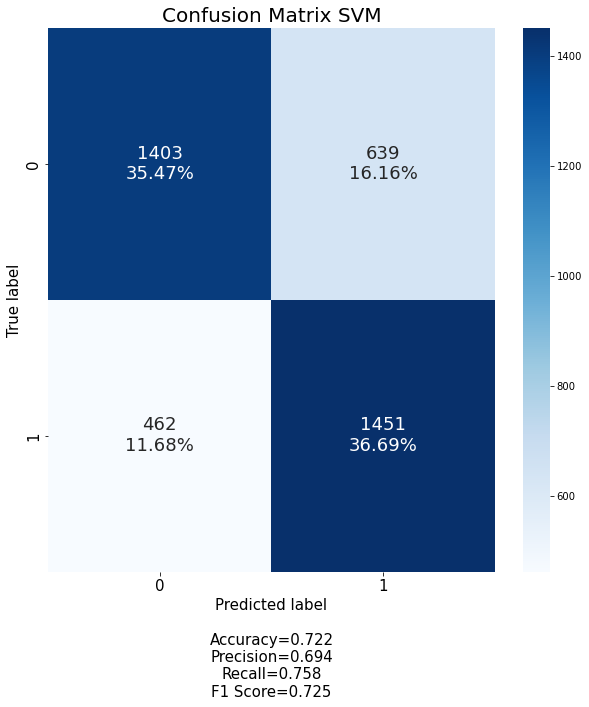

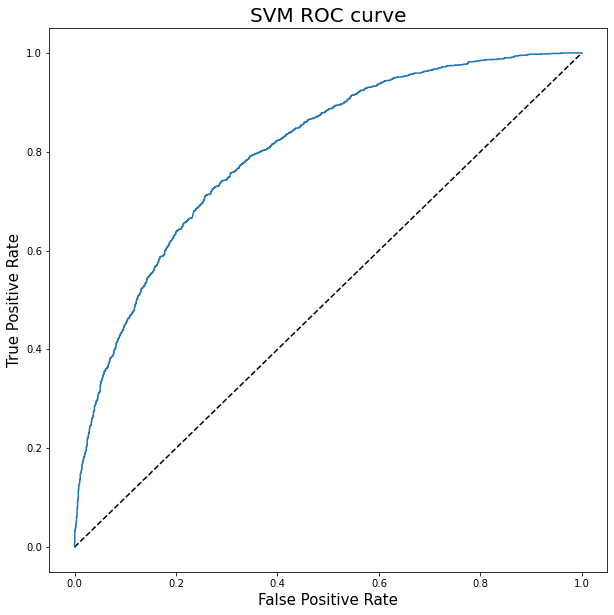

In [50]:
result = classification_result(X_train, y_train, X_test, y_test, ml_cl = LinearSVC(), model_title = 'SVM', result = result)

              precision    recall  f1-score   support

           0       0.64      0.62      0.63      2042
           1       0.60      0.63      0.62      1913

    accuracy                           0.62      3955
   macro avg       0.62      0.62      0.62      3955
weighted avg       0.62      0.62      0.62      3955



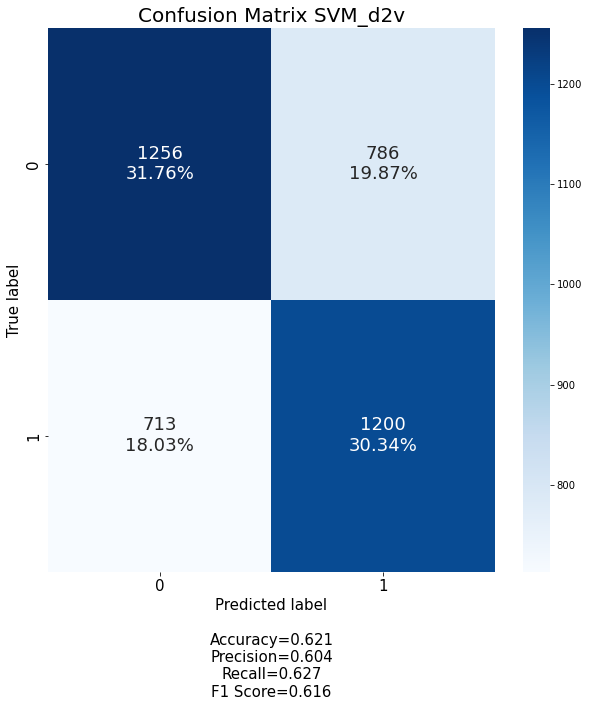

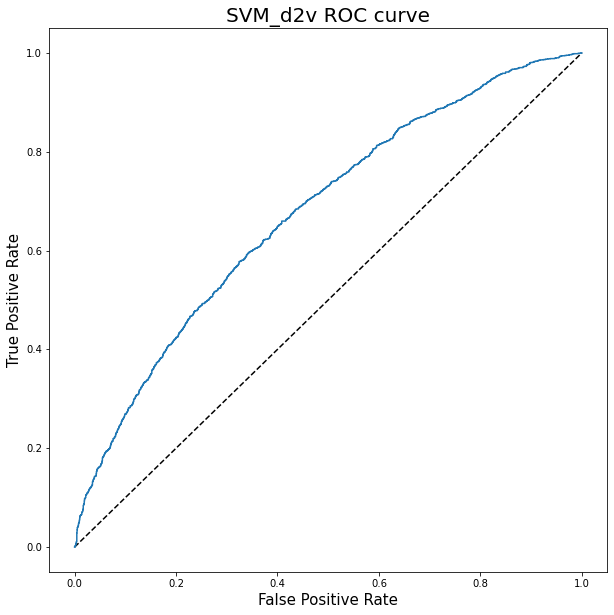

In [51]:
result = classification_result(X_train_d2v, y_train_d2v, X_test_d2v, y_test_d2v, ml_cl = LinearSVC(), model_title = 'SVM_d2v', result = result)

              precision    recall  f1-score   support

           0       0.54      0.39      0.45      2042
           1       0.50      0.63      0.56      1913

    accuracy                           0.51      3955
   macro avg       0.52      0.51      0.51      3955
weighted avg       0.52      0.51      0.50      3955



/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


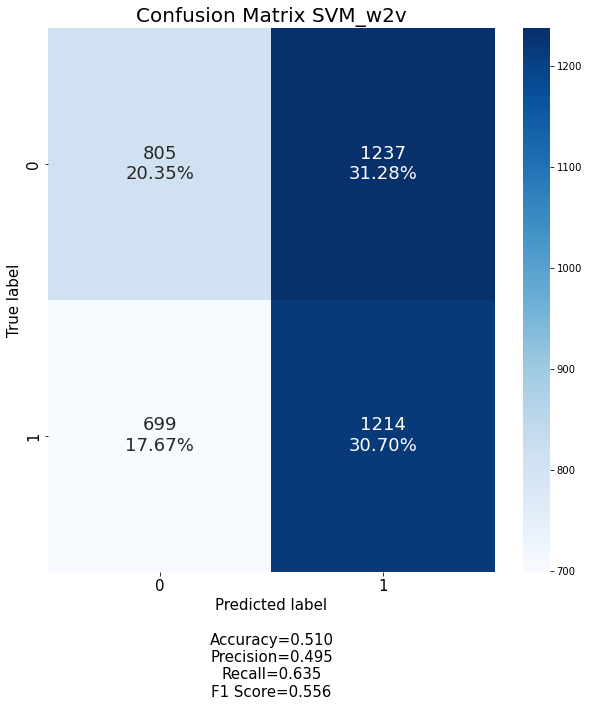

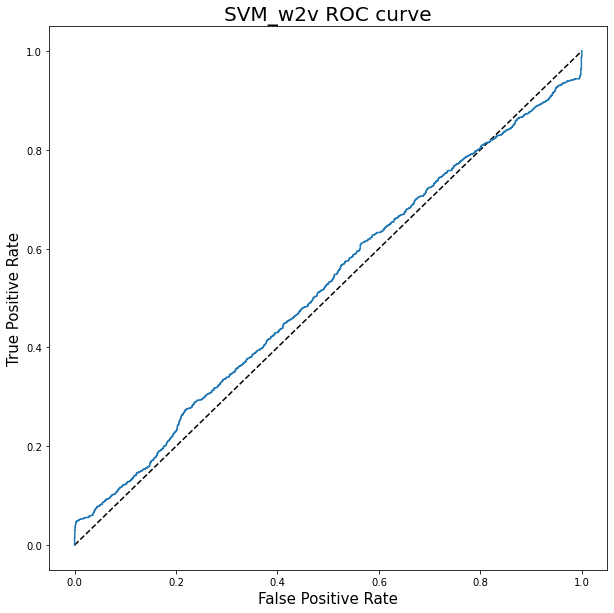

In [52]:
result = classification_result(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, ml_cl = LinearSVC(), model_title = 'SVM_w2v', result = result)

              precision    recall  f1-score   support

           0       0.62      0.61      0.62      2042
           1       0.59      0.61      0.60      1913

    accuracy                           0.61      3955
   macro avg       0.61      0.61      0.61      3955
weighted avg       0.61      0.61      0.61      3955



/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


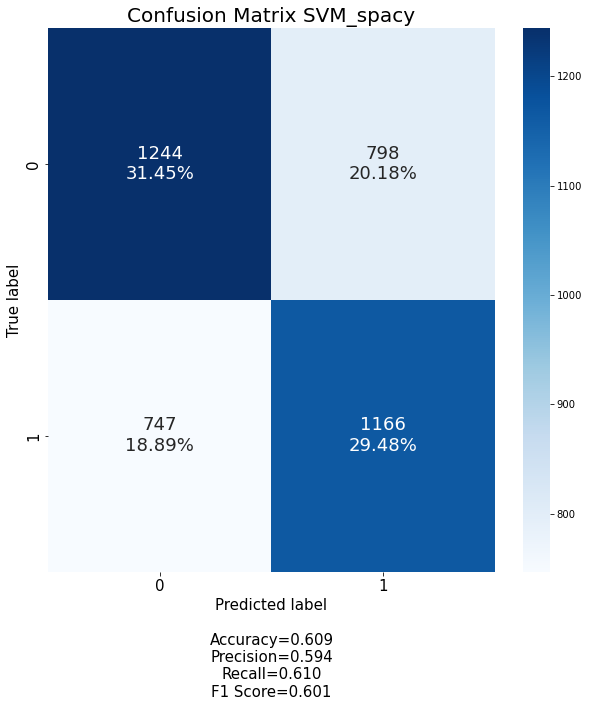

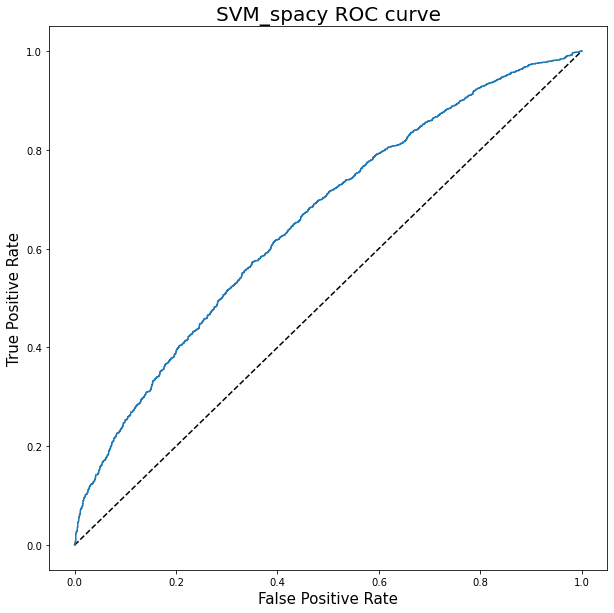

In [53]:
result = classification_result(X_train_spacy, y_train_spacy, X_test_spacy, y_test_spacy, ml_cl = LinearSVC(), model_title = 'SVM_spacy', result = result)

              precision    recall  f1-score   support

           0       0.50      0.53      0.51      2042
           1       0.47      0.44      0.45      1913

    accuracy                           0.49      3955
   macro avg       0.48      0.48      0.48      3955
weighted avg       0.48      0.49      0.48      3955



/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


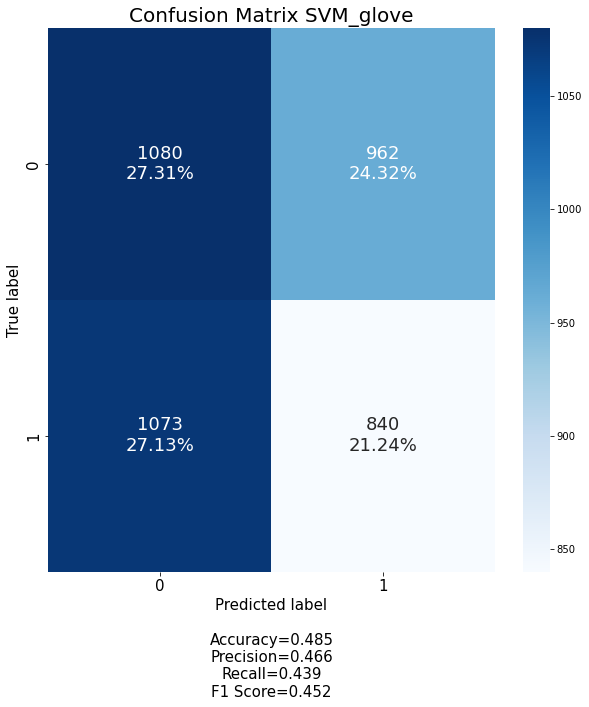

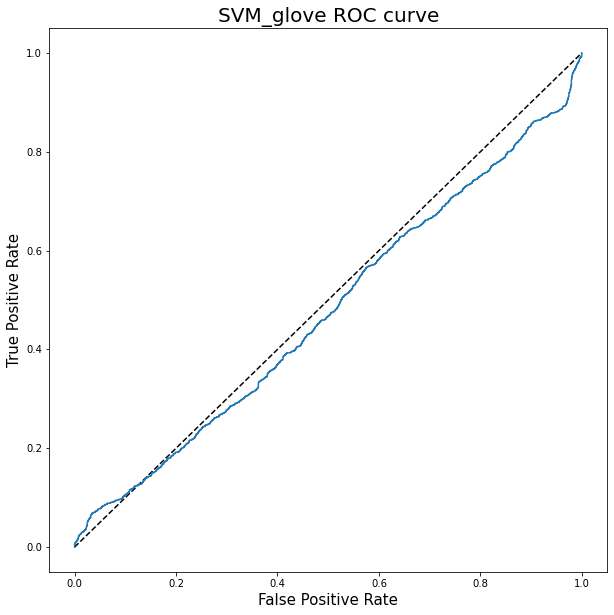

In [54]:
result = classification_result(X_train_glove, y_train_glove, X_test_glove, y_test_glove, ml_cl = LinearSVC(), model_title = 'SVM_glove', result = result)

### Logistic Regression

              precision    recall  f1-score   support

           0       0.77      0.70      0.73      2042
           1       0.71      0.77      0.74      1913

    accuracy                           0.74      3955
   macro avg       0.74      0.74      0.74      3955
weighted avg       0.74      0.74      0.74      3955



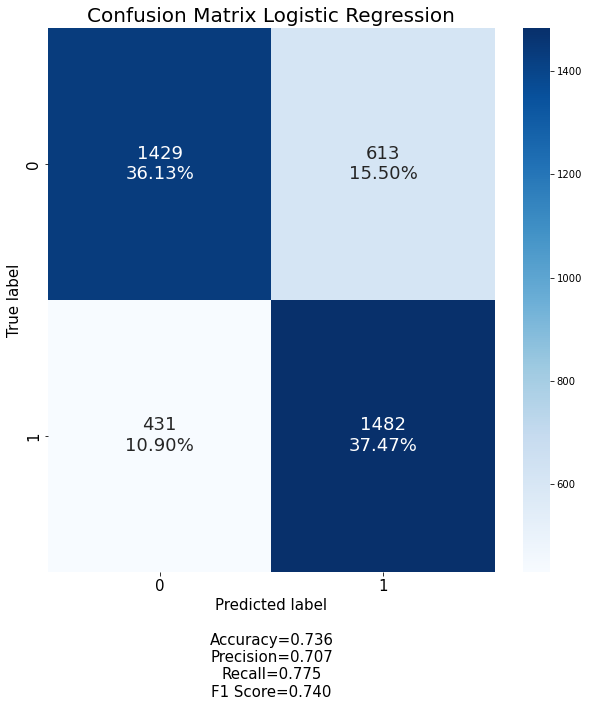

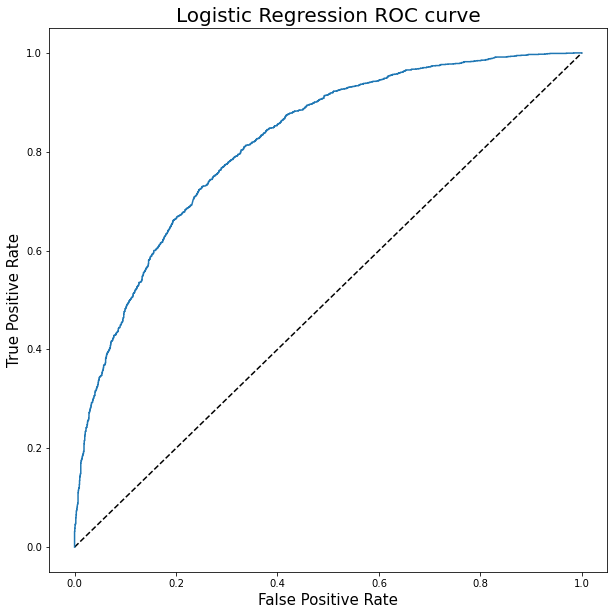

In [55]:
result = classification_result(X_train, y_train, X_test, y_test, LogisticRegression(), model_title = 'Logistic Regression', result = result)

              precision    recall  f1-score   support

           0       0.53      0.11      0.18      2042
           1       0.49      0.90      0.63      1913

    accuracy                           0.49      3955
   macro avg       0.51      0.50      0.41      3955
weighted avg       0.51      0.49      0.40      3955



/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


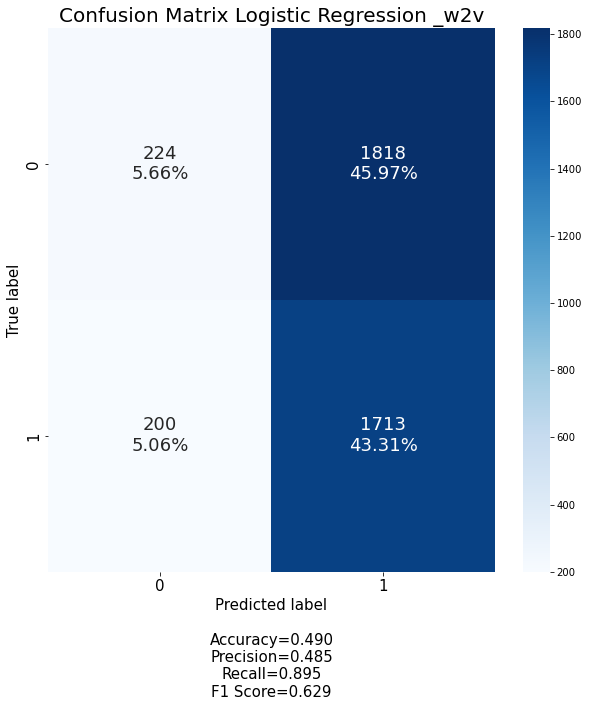

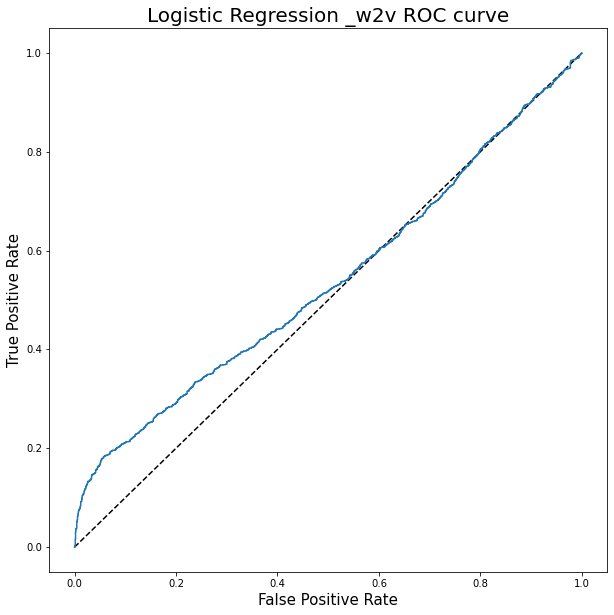

In [56]:
result = classification_result(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, LogisticRegression(), model_title = 'Logistic Regression _w2v', result = result)

              precision    recall  f1-score   support

           0       0.64      0.56      0.59      2042
           1       0.58      0.66      0.62      1913

    accuracy                           0.61      3955
   macro avg       0.61      0.61      0.61      3955
weighted avg       0.61      0.61      0.61      3955



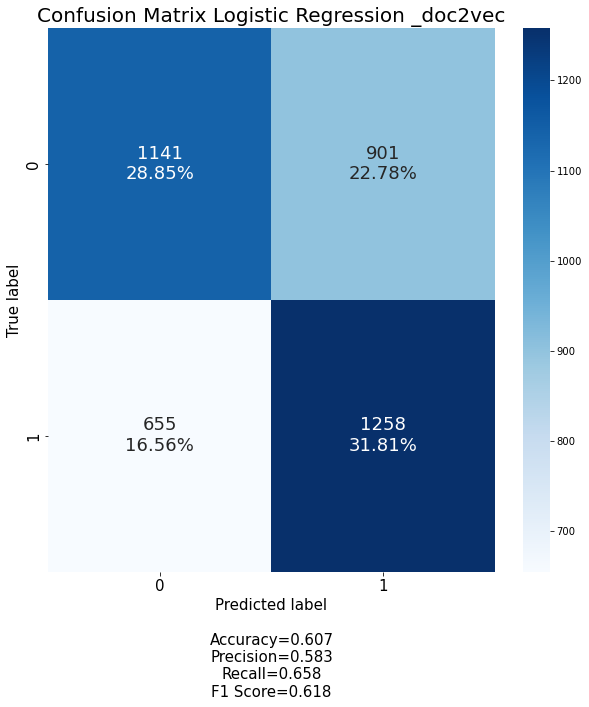

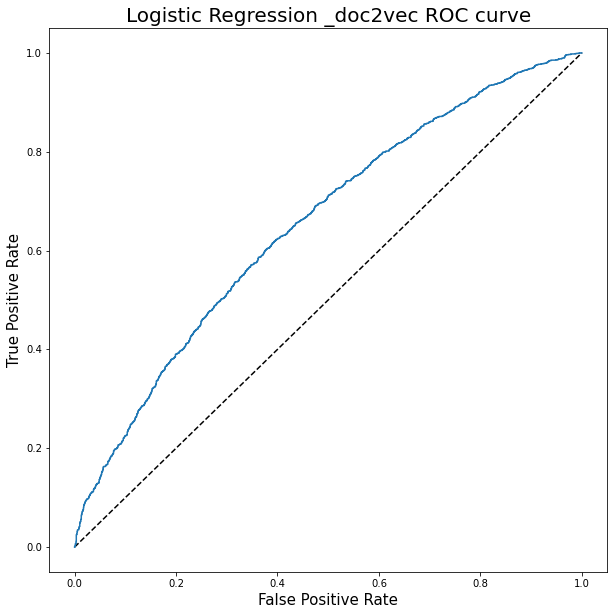

In [57]:
result = classification_result(X_train_d2v, y_train_d2v, X_test_d2v, y_test_d2v, LogisticRegression(), model_title = 'Logistic Regression _doc2vec', result = result)

              precision    recall  f1-score   support

           0       0.53      0.11      0.18      2042
           1       0.49      0.90      0.63      1913

    accuracy                           0.49      3955
   macro avg       0.51      0.50      0.41      3955
weighted avg       0.51      0.49      0.40      3955



/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


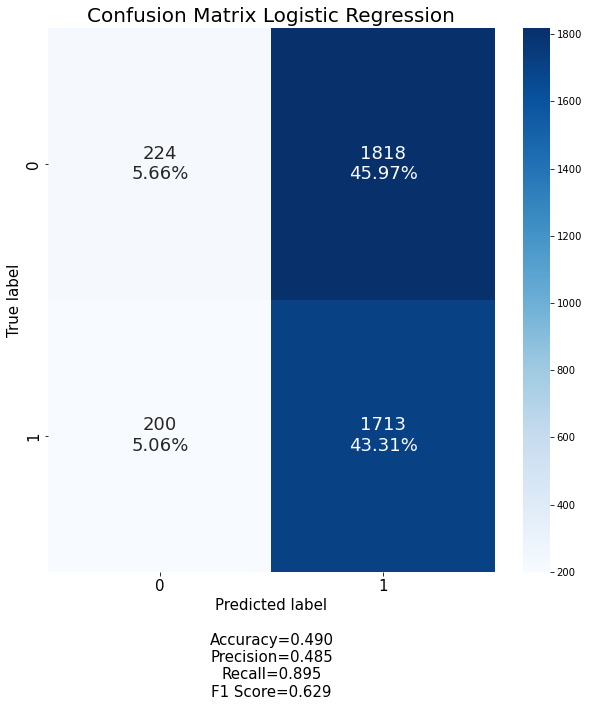

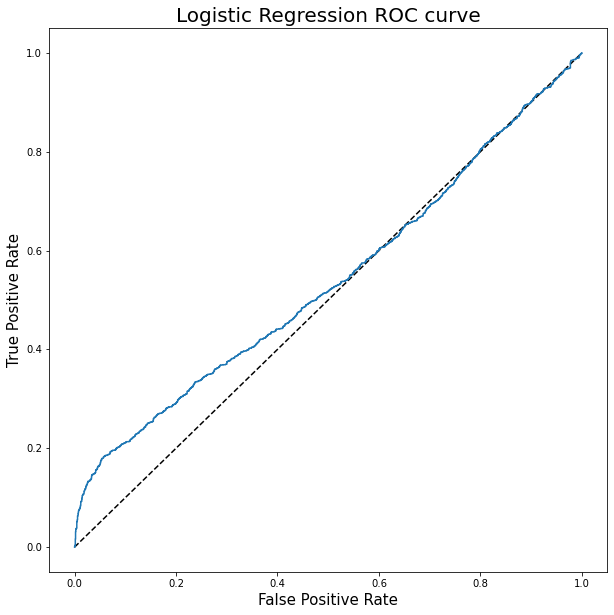

In [58]:
result = classification_result(X_train_glove, y_train_glove, X_test_glove, y_test_glove, LogisticRegression(), model_title = 'Logistic Regression', result = result)

              precision    recall  f1-score   support

           0       0.62      0.61      0.61      2042
           1       0.59      0.61      0.60      1913

    accuracy                           0.61      3955
   macro avg       0.61      0.61      0.61      3955
weighted avg       0.61      0.61      0.61      3955



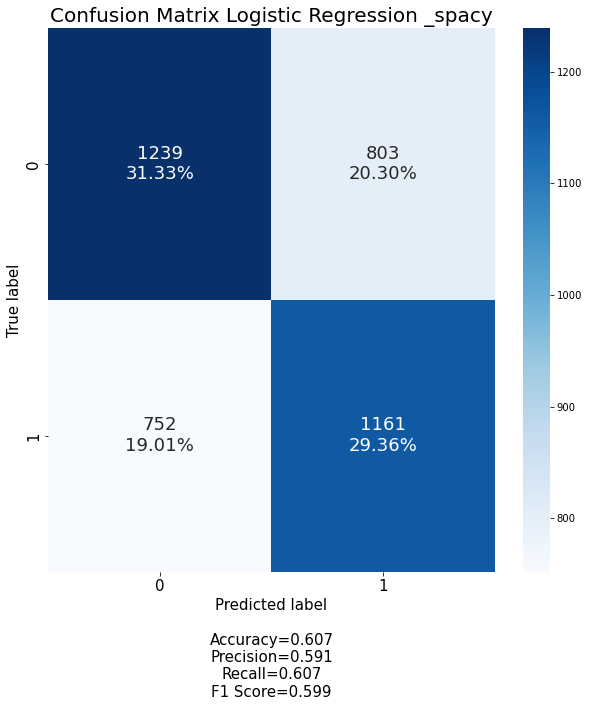

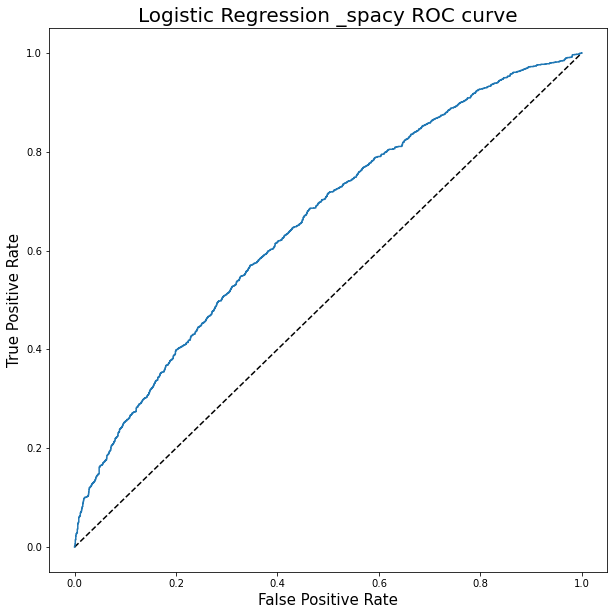

In [59]:
result = classification_result(X_train_spacy, y_train_spacy, X_test_spacy, y_test_spacy, LogisticRegression(), model_title = 'Logistic Regression _spacy', result = result)

### BernoulliNB

              precision    recall  f1-score   support

           0       0.75      0.72      0.74      2042
           1       0.71      0.74      0.73      1913

    accuracy                           0.73      3955
   macro avg       0.73      0.73      0.73      3955
weighted avg       0.73      0.73      0.73      3955



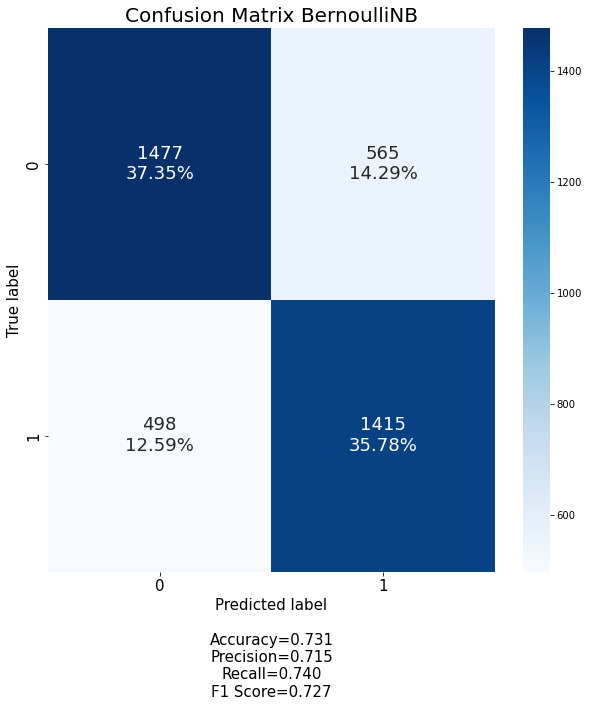

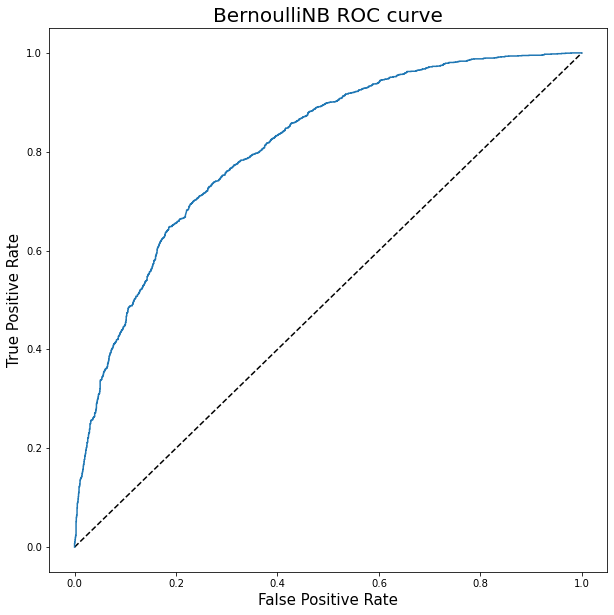

In [60]:
result = classification_result(X_train, y_train, X_test, y_test, BernoulliNB(), model_title = 'BernoulliNB', result = result)

              precision    recall  f1-score   support

           0       0.54      0.51      0.52      2042
           1       0.51      0.54      0.52      1913

    accuracy                           0.52      3955
   macro avg       0.52      0.52      0.52      3955
weighted avg       0.53      0.52      0.52      3955



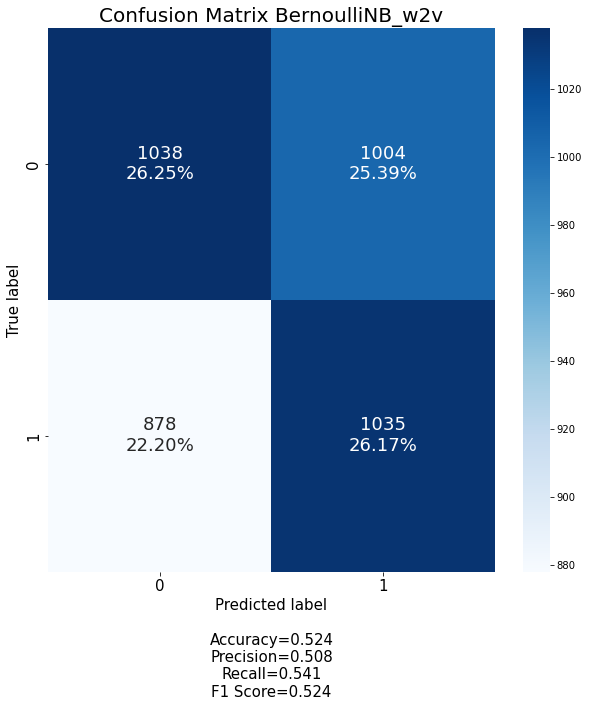

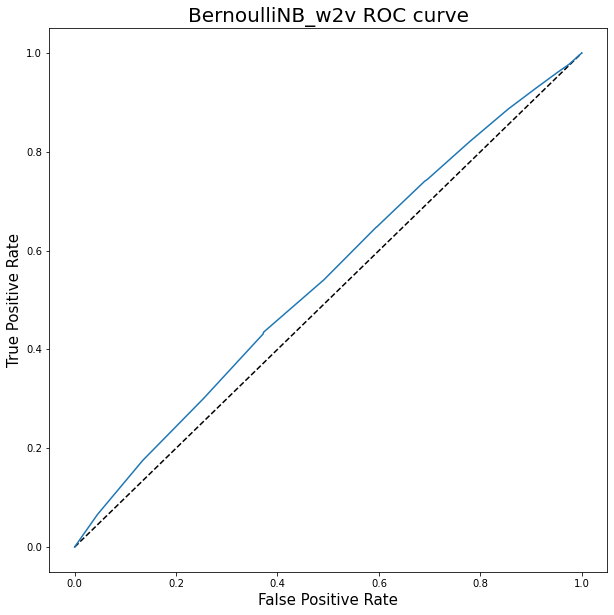

In [61]:
result = classification_result(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, BernoulliNB(), model_title = 'BernoulliNB_w2v', result = result)

              precision    recall  f1-score   support

           0       0.59      0.43      0.50      2042
           1       0.53      0.68      0.60      1913

    accuracy                           0.55      3955
   macro avg       0.56      0.56      0.55      3955
weighted avg       0.56      0.55      0.55      3955



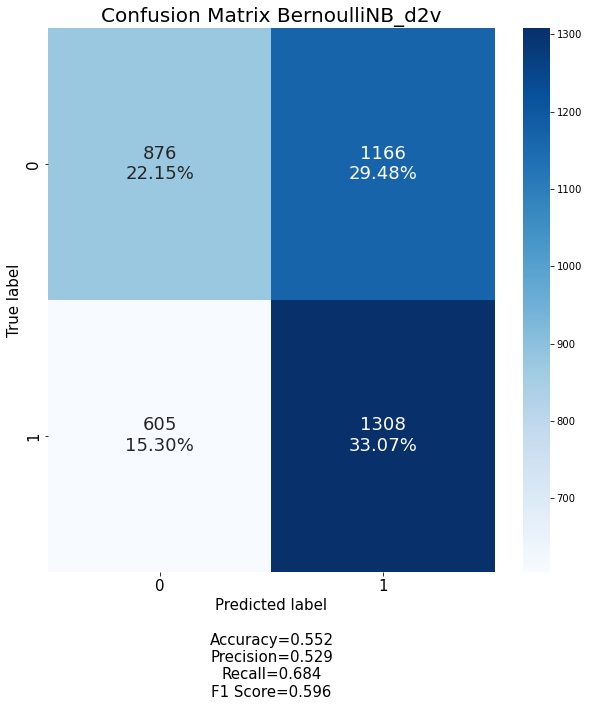

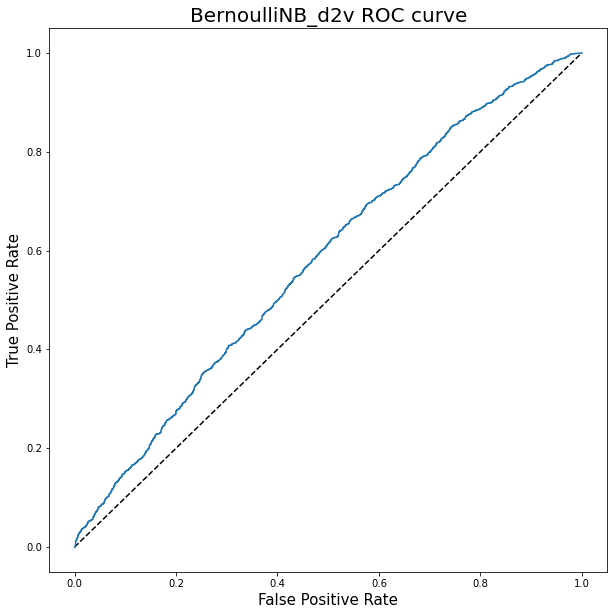

In [62]:
result = classification_result(X_train_d2v, y_train_d2v, X_test_d2v, y_test_d2v, BernoulliNB(), model_title = 'BernoulliNB_d2v', result = result)

              precision    recall  f1-score   support

           0       0.58      0.58      0.58      2042
           1       0.55      0.54      0.55      1913

    accuracy                           0.56      3955
   macro avg       0.56      0.56      0.56      3955
weighted avg       0.56      0.56      0.56      3955



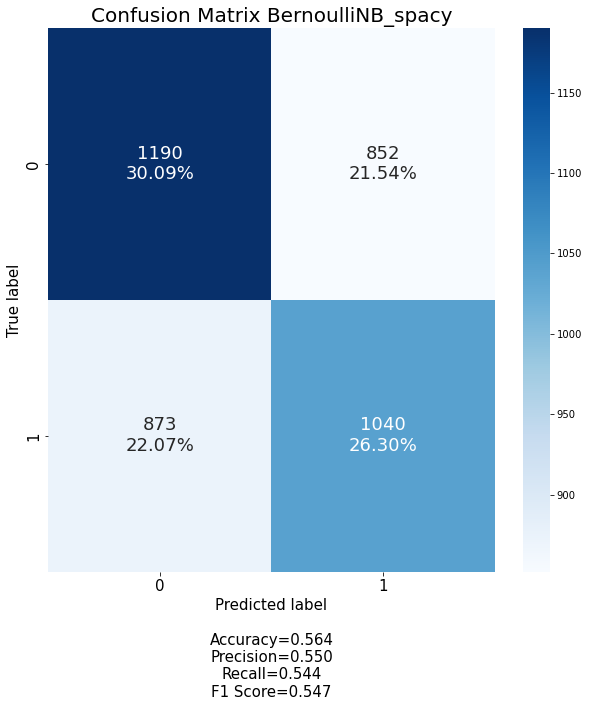

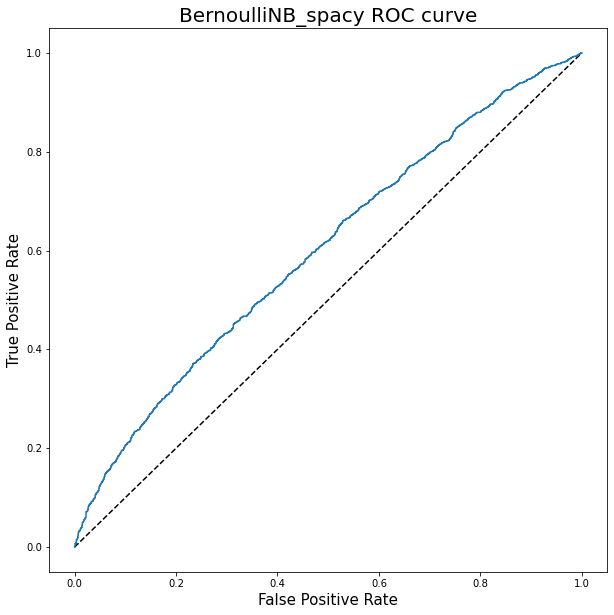

In [63]:
result = classification_result(X_train_spacy, y_train_spacy, X_test_spacy, y_test_spacy, BernoulliNB(), model_title = 'BernoulliNB_spacy', result = result)

              precision    recall  f1-score   support

           0       0.54      0.51      0.52      2042
           1       0.51      0.54      0.52      1913

    accuracy                           0.52      3955
   macro avg       0.52      0.52      0.52      3955
weighted avg       0.53      0.52      0.52      3955



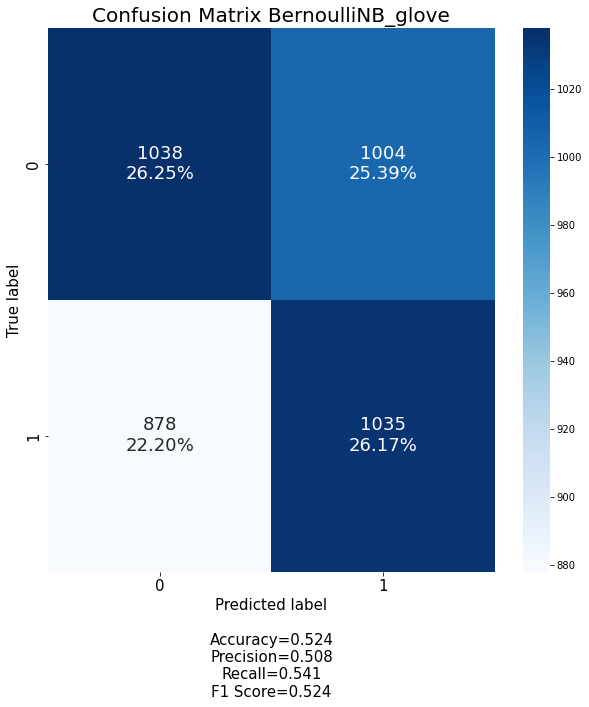

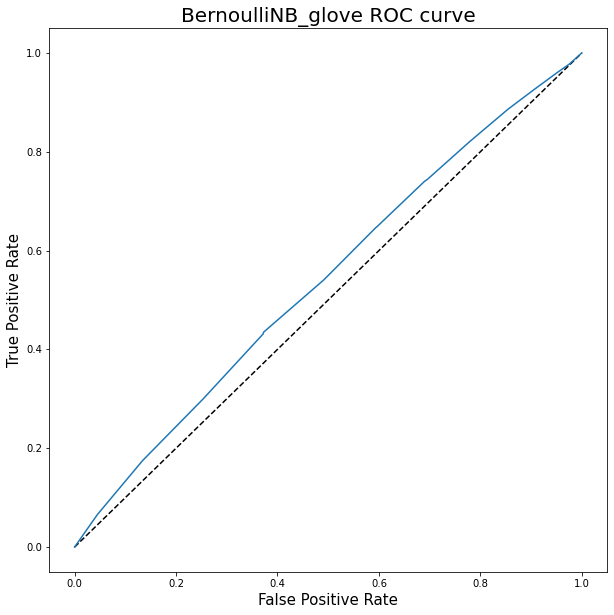

In [64]:
result = classification_result(X_train_glove, y_train_glove, X_test_glove, y_test_glove, BernoulliNB(), model_title = 'BernoulliNB_glove', result = result)

### RandomForestClassifier

              precision    recall  f1-score   support

           0       0.79      0.60      0.68      2042
           1       0.66      0.83      0.74      1913

    accuracy                           0.71      3955
   macro avg       0.73      0.72      0.71      3955
weighted avg       0.73      0.71      0.71      3955



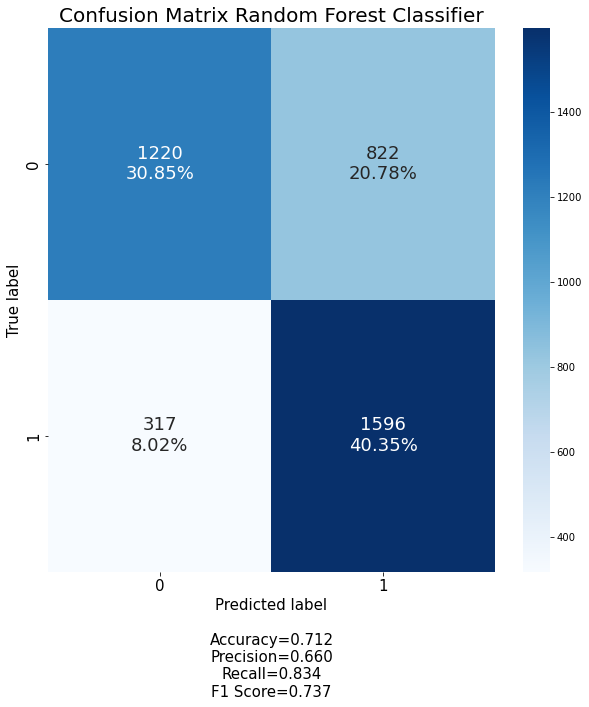

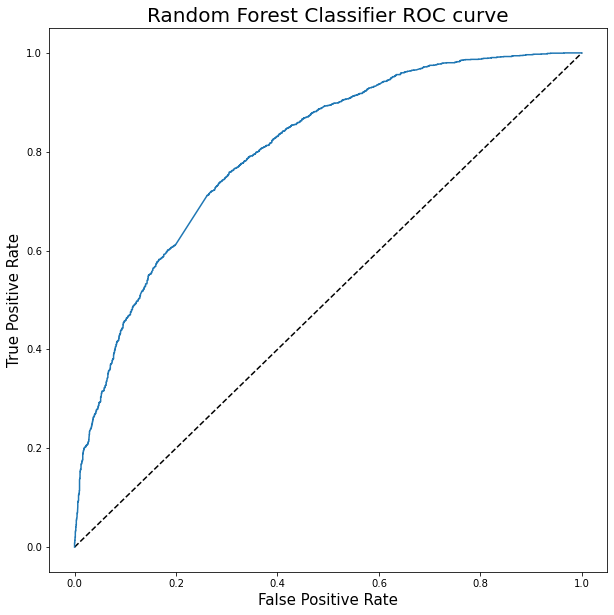

In [65]:
result = classification_result(X_train, y_train, X_test, y_test, RandomForestClassifier(n_estimators=200, max_depth=15), model_title = 'Random Forest Classifier', result = result)

              precision    recall  f1-score   support

           0       0.64      0.61      0.63      2042
           1       0.61      0.63      0.62      1913

    accuracy                           0.62      3955
   macro avg       0.62      0.62      0.62      3955
weighted avg       0.62      0.62      0.62      3955



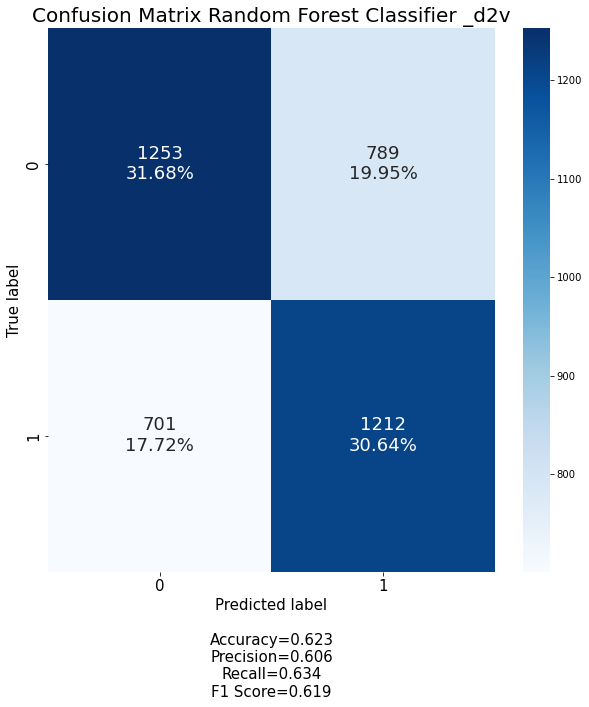

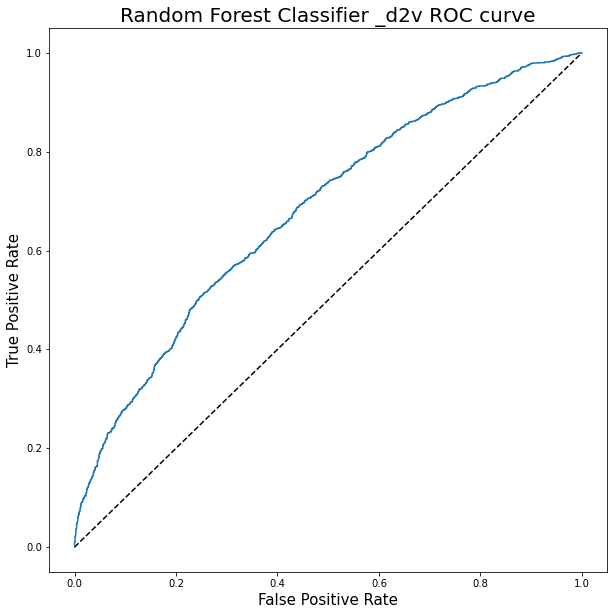

In [66]:
result = classification_result(X_train_d2v, y_train_d2v, X_test_d2v, y_test_d2v, RandomForestClassifier(n_estimators=200, max_depth=15), model_title = 'Random Forest Classifier _d2v', result = result)

              precision    recall  f1-score   support

           0       0.63      1.00      0.78      2042
           1       1.00      0.38      0.55      1913

    accuracy                           0.70      3955
   macro avg       0.82      0.69      0.66      3955
weighted avg       0.81      0.70      0.67      3955



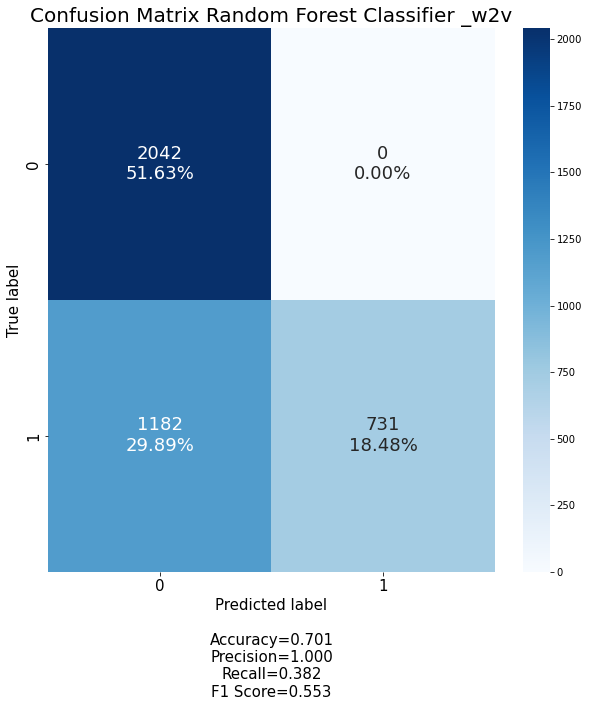

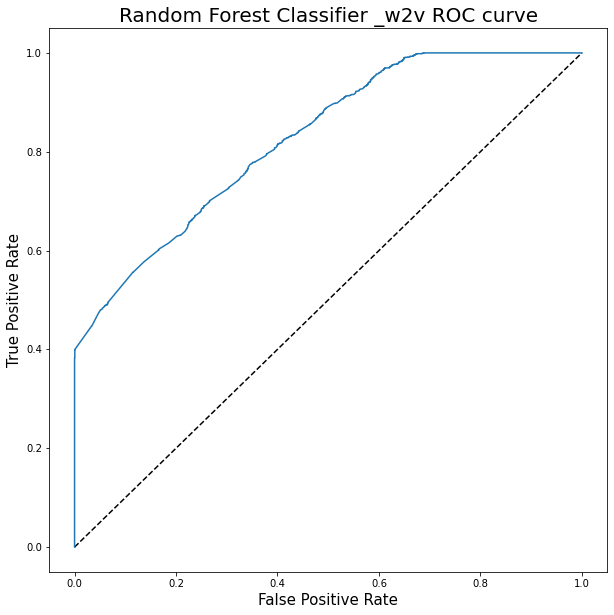

In [67]:
result = classification_result(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, RandomForestClassifier(n_estimators=200, max_depth=15), model_title = 'Random Forest Classifier _w2v', result = result)

              precision    recall  f1-score   support

           0       0.64      1.00      0.78      2042
           1       1.00      0.39      0.56      1913

    accuracy                           0.71      3955
   macro avg       0.82      0.70      0.67      3955
weighted avg       0.81      0.71      0.67      3955



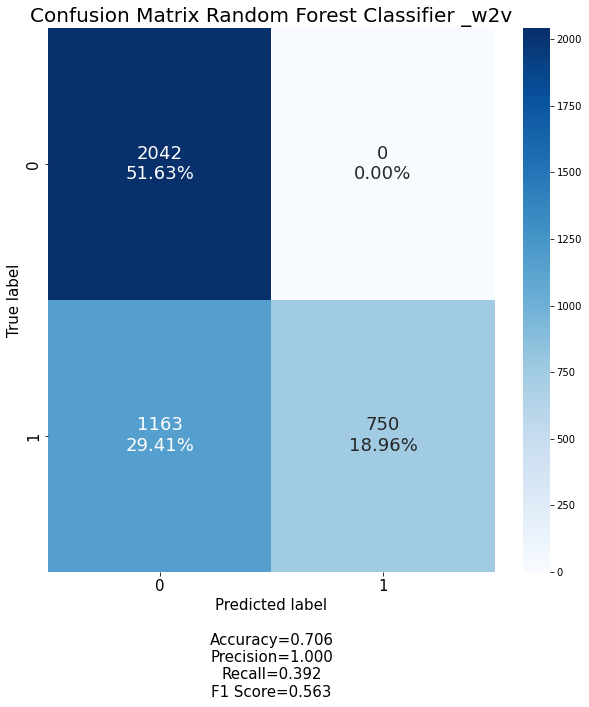

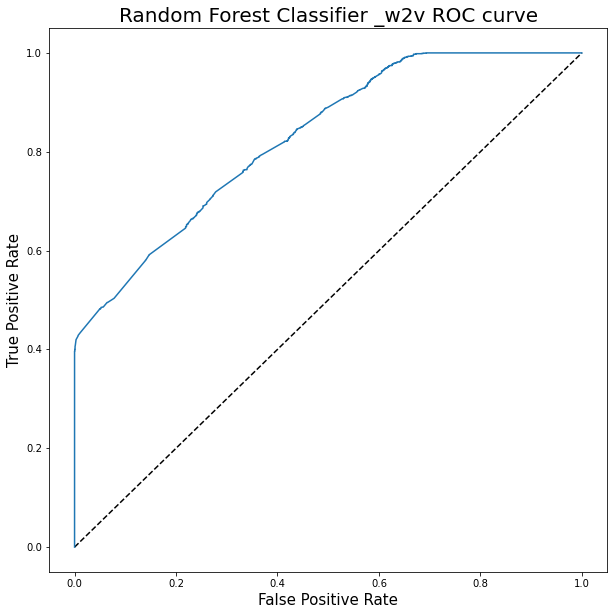

In [68]:
result = classification_result(X_train_glove, y_train_glove, X_test_glove, y_test_glove, RandomForestClassifier(n_estimators=200, max_depth=15), model_title = 'Random Forest Classifier _w2v', result = result)

              precision    recall  f1-score   support

           0       0.64      0.64      0.64      2042
           1       0.62      0.61      0.61      1913

    accuracy                           0.63      3955
   macro avg       0.63      0.63      0.63      3955
weighted avg       0.63      0.63      0.63      3955



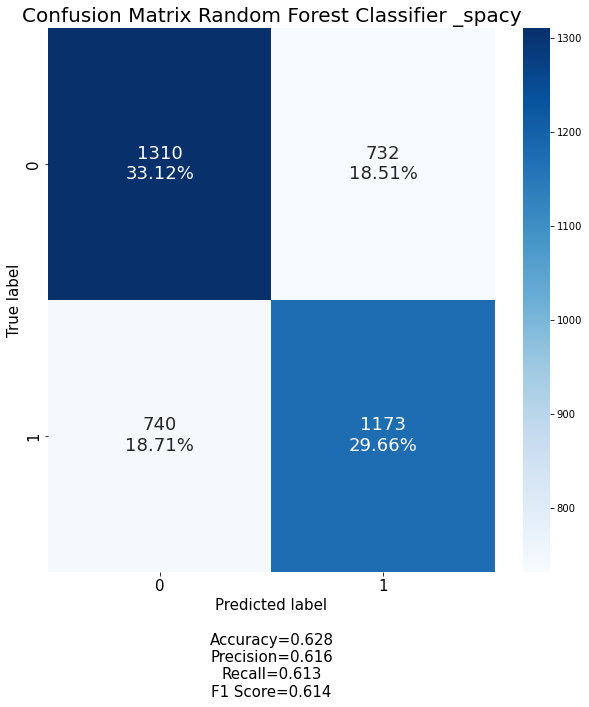

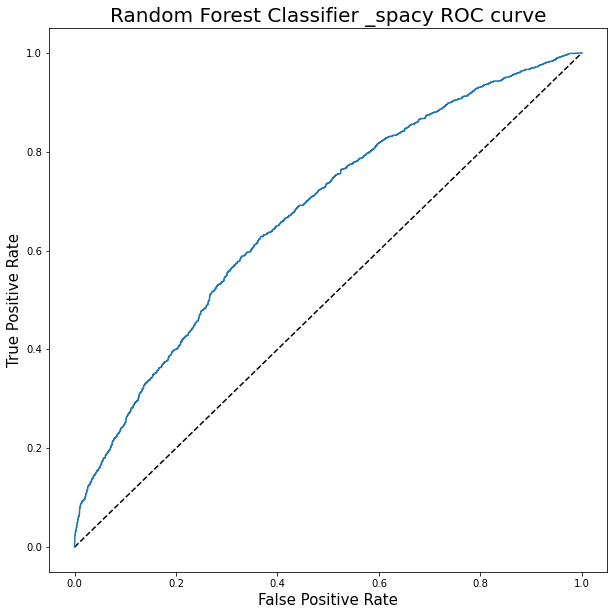

In [69]:
result = classification_result(X_train_spacy, y_train_spacy, X_test_spacy, y_test_spacy, RandomForestClassifier(n_estimators=200, max_depth=15), model_title = 'Random Forest Classifier _spacy', result = result)

### KNeighborsClassifier

              precision    recall  f1-score   support

           0       0.68      0.65      0.67      2042
           1       0.64      0.68      0.66      1913

    accuracy                           0.66      3955
   macro avg       0.66      0.66      0.66      3955
weighted avg       0.66      0.66      0.66      3955



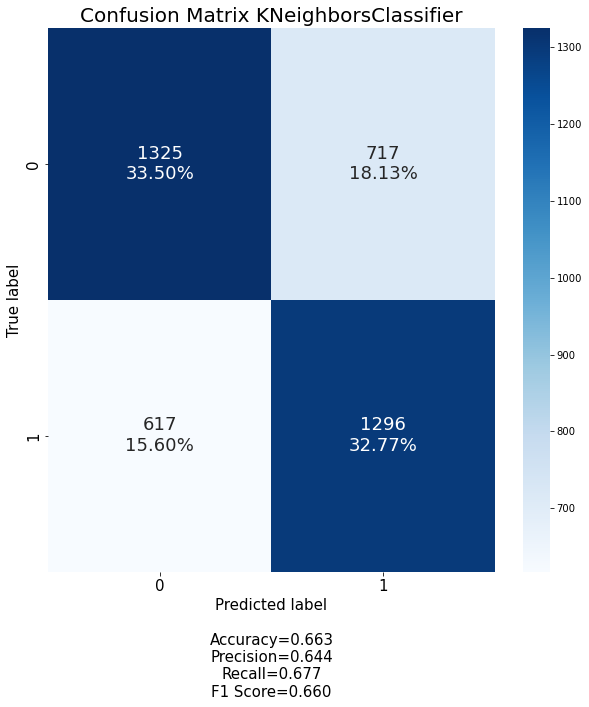

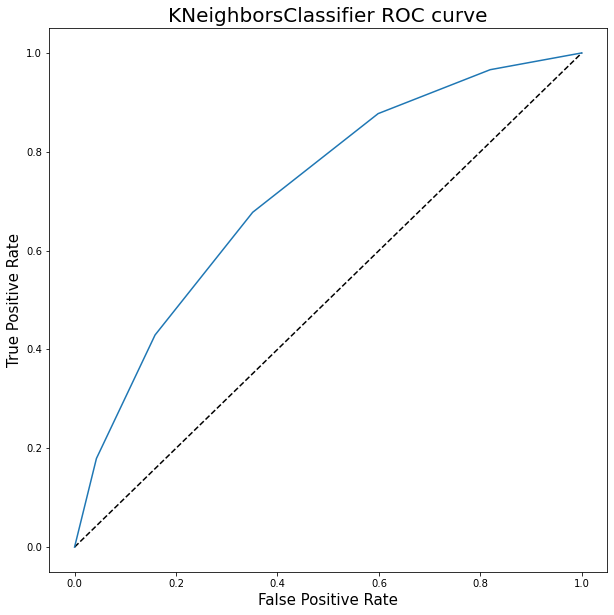

In [70]:
result = classification_result(X_train, y_train, X_test, y_test, KNeighborsClassifier(n_jobs=-1), model_title = 'KNeighborsClassifier', result = result)

In [71]:
#result = classification_result(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, KNeighborsClassifier(n_jobs=-1), model_title = 'KNeighborsClassifier', result = result)

### LGBMClassifier

              precision    recall  f1-score   support

           0       0.77      0.64      0.70      2042
           1       0.67      0.80      0.73      1913

    accuracy                           0.72      3955
   macro avg       0.72      0.72      0.72      3955
weighted avg       0.73      0.72      0.72      3955



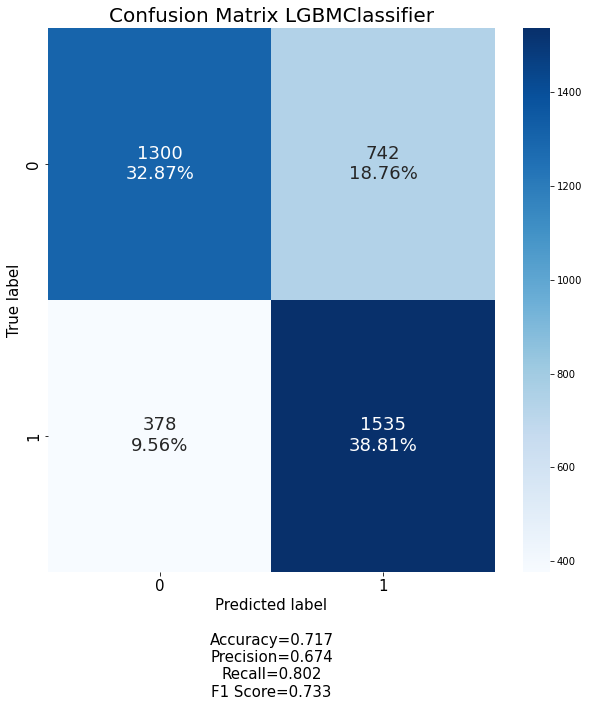

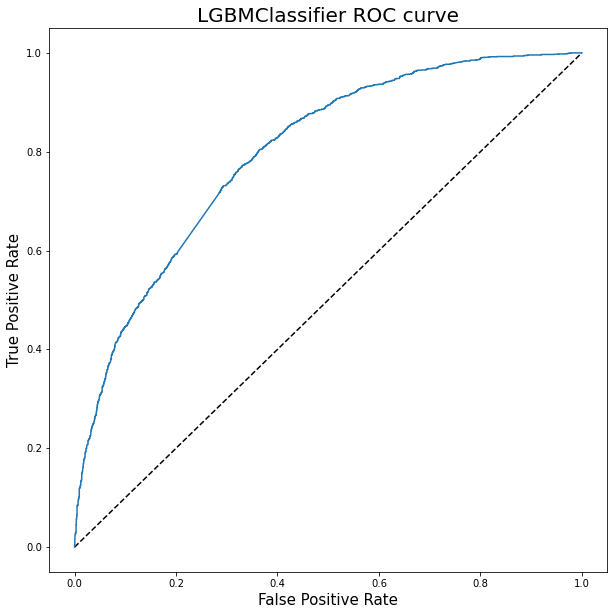

In [72]:
result = classification_result(X_train, y_train, X_test, y_test, LGBMClassifier(
                objective='binary',
                n_jobs=-1,
                random_state=10), model_title = 'LGBMClassifier', result = result)

              precision    recall  f1-score   support

           0       0.76      0.80      0.78      2042
           1       0.77      0.73      0.75      1913

    accuracy                           0.76      3955
   macro avg       0.76      0.76      0.76      3955
weighted avg       0.76      0.76      0.76      3955



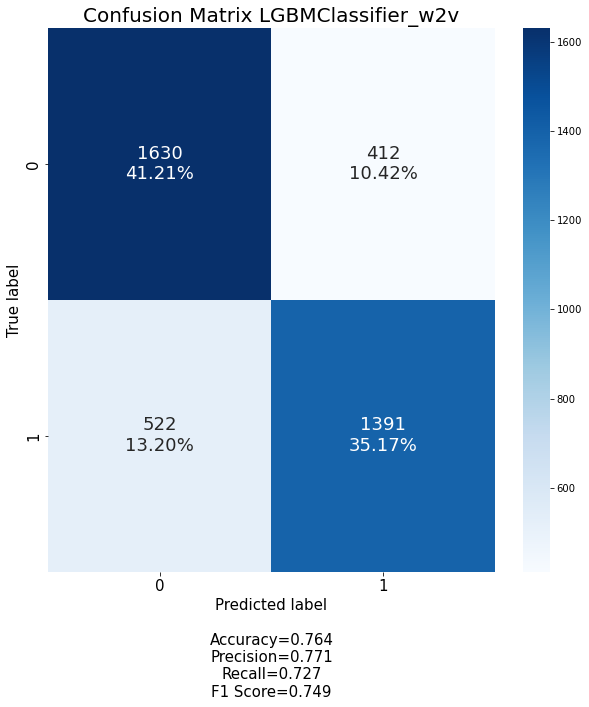

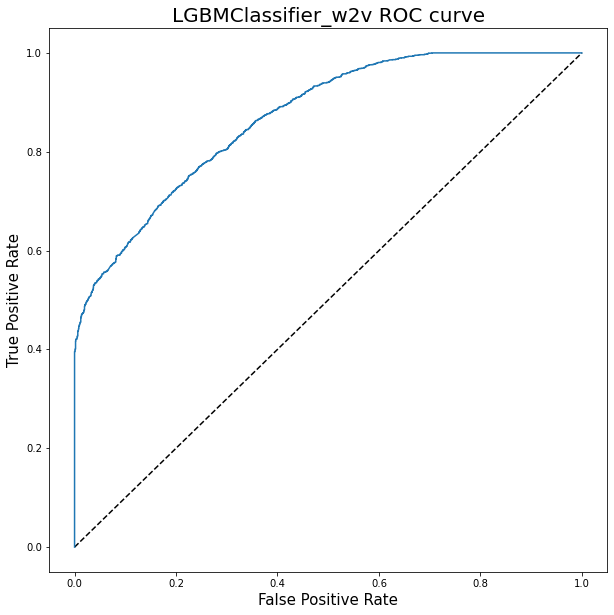

In [73]:
result = classification_result(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, LGBMClassifier(
                objective='binary',
                n_jobs=-1,
                random_state=10), model_title = 'LGBMClassifier_w2v', result = result)

              precision    recall  f1-score   support

           0       0.64      0.62      0.63      2042
           1       0.60      0.62      0.61      1913

    accuracy                           0.62      3955
   macro avg       0.62      0.62      0.62      3955
weighted avg       0.62      0.62      0.62      3955



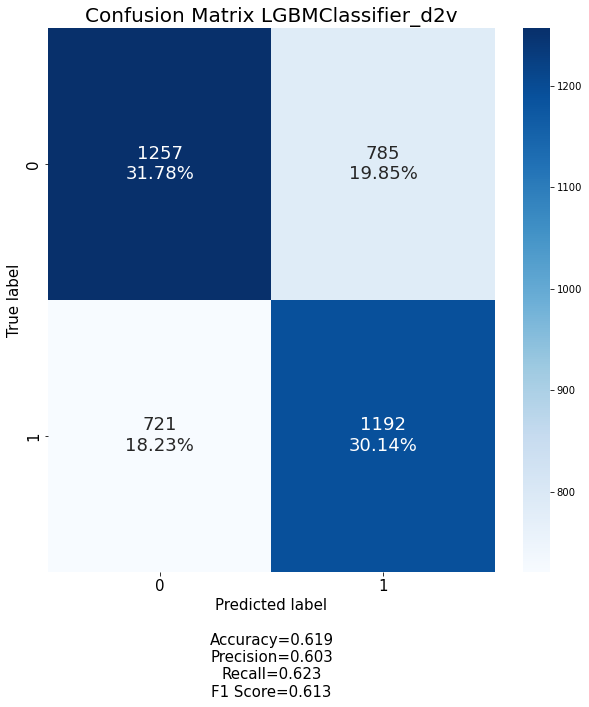

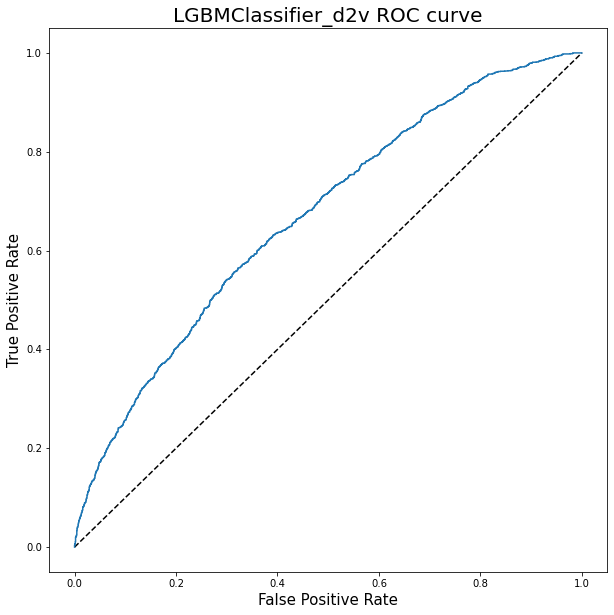

In [74]:
result = classification_result(X_train_d2v, y_train_d2v, X_test_d2v, y_test_d2v, LGBMClassifier(
                objective='binary',
                n_jobs=-1,
                random_state=10), model_title = 'LGBMClassifier_d2v', result = result)

              precision    recall  f1-score   support

           0       0.76      0.80      0.78      2042
           1       0.77      0.73      0.75      1913

    accuracy                           0.76      3955
   macro avg       0.76      0.76      0.76      3955
weighted avg       0.76      0.76      0.76      3955



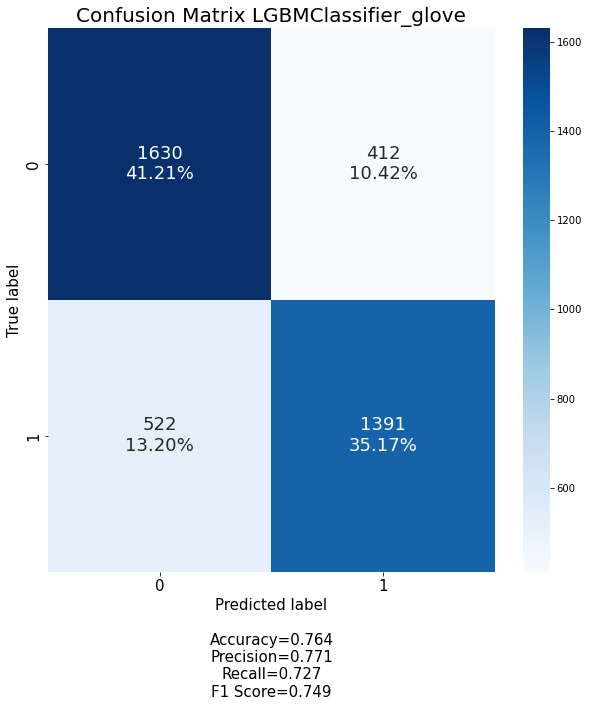

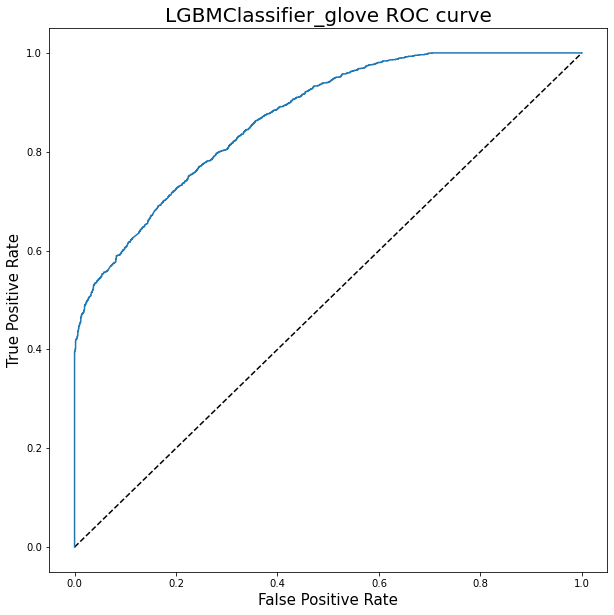

In [75]:
result = classification_result(X_train_glove, y_train_glove, X_test_glove, y_test_glove, LGBMClassifier(
                objective='binary',
                n_jobs=-1,
                random_state=10), model_title = 'LGBMClassifier_glove', result = result)

              precision    recall  f1-score   support

           0       0.63      0.62      0.62      2042
           1       0.60      0.60      0.60      1913

    accuracy                           0.61      3955
   macro avg       0.61      0.61      0.61      3955
weighted avg       0.61      0.61      0.61      3955



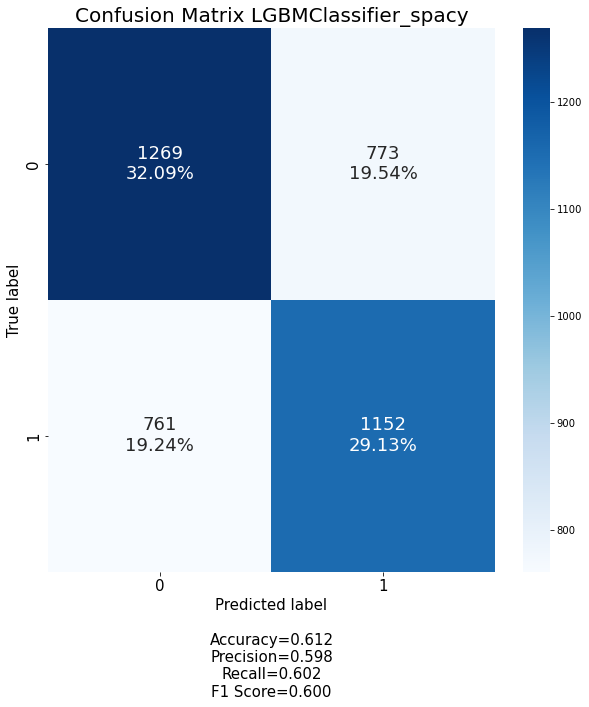

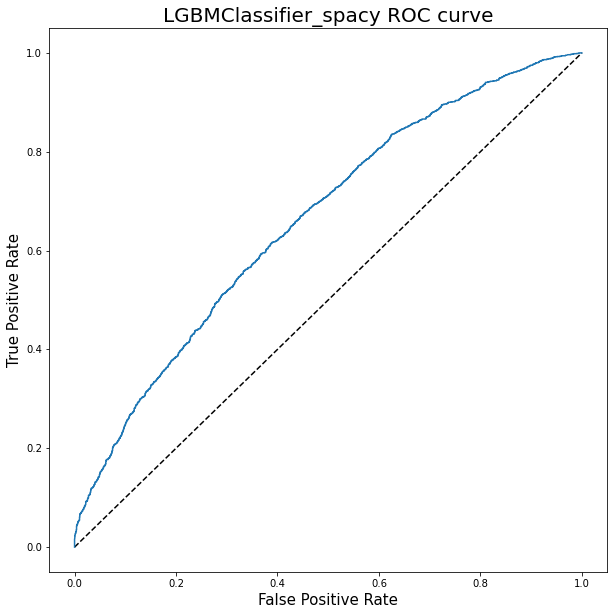

In [76]:
result = classification_result(X_train_spacy, y_train_spacy, X_test_spacy, y_test_spacy, LGBMClassifier(
                objective='binary',
                n_jobs=-1,
                random_state=10), model_title = 'LGBMClassifier_spacy', result = result)

### XGBClassifier

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:51:21] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.78      0.61      0.69      2042
           1       0.66      0.81      0.73      1913

    accuracy                           0.71      3955
   macro avg       0.72      0.71      0.71      3955
weighted avg       0.72      0.71      0.71      3955



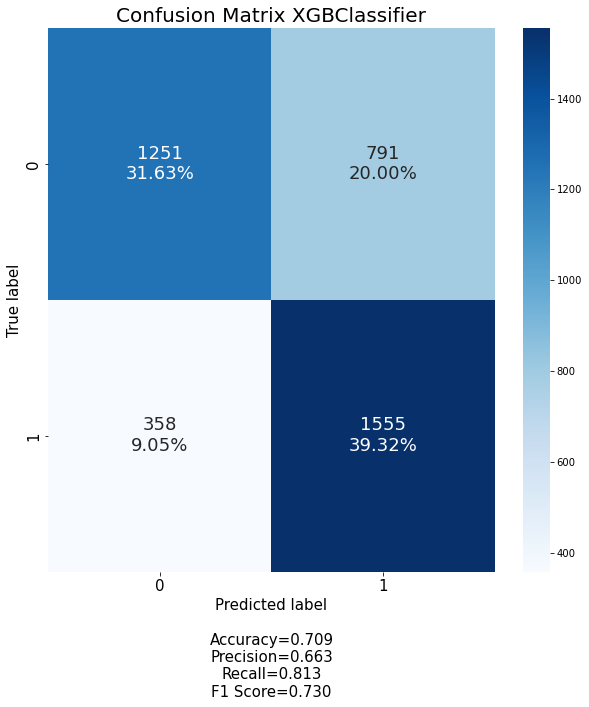

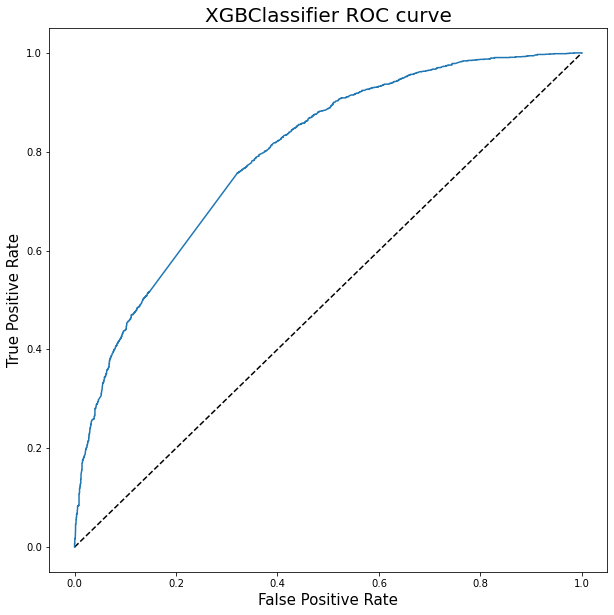

In [77]:
result = classification_result(X_train, y_train, X_test, y_test, XGBClassifier(objective='binary:logistic',
                                                                        n_jobs=-1,
                                                                        random_state=10), model_title = 'XGBClassifier', result = result)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:51:28] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      2042
           1       0.77      0.75      0.76      1913

    accuracy                           0.77      3955
   macro avg       0.77      0.77      0.77      3955
weighted avg       0.77      0.77      0.77      3955



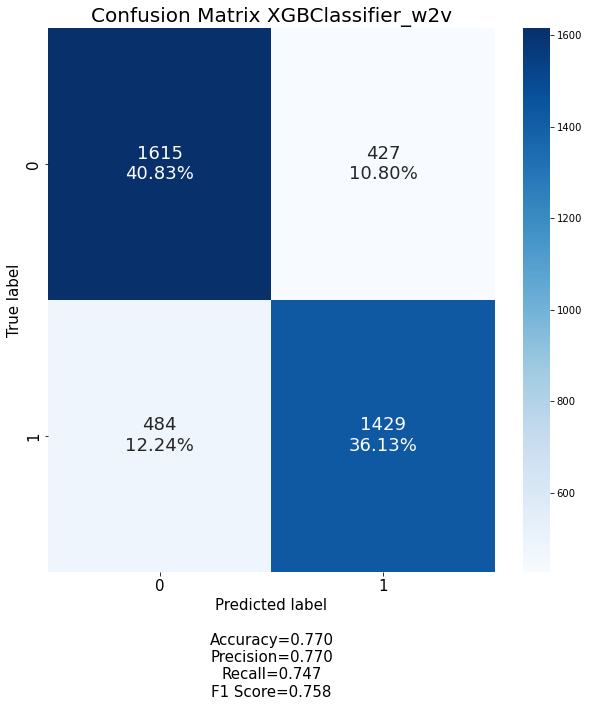

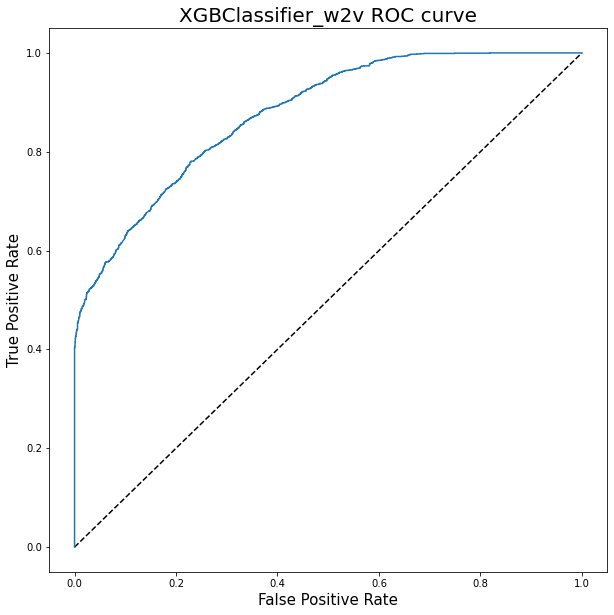

In [78]:
result = classification_result(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, XGBClassifier(objective='binary:logistic',
                                                                        n_jobs=-1,
                                                                        random_state=10), model_title = 'XGBClassifier_w2v', result = result)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:51:43] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      2042
           1       0.77      0.75      0.76      1913

    accuracy                           0.77      3955
   macro avg       0.77      0.77      0.77      3955
weighted avg       0.77      0.77      0.77      3955



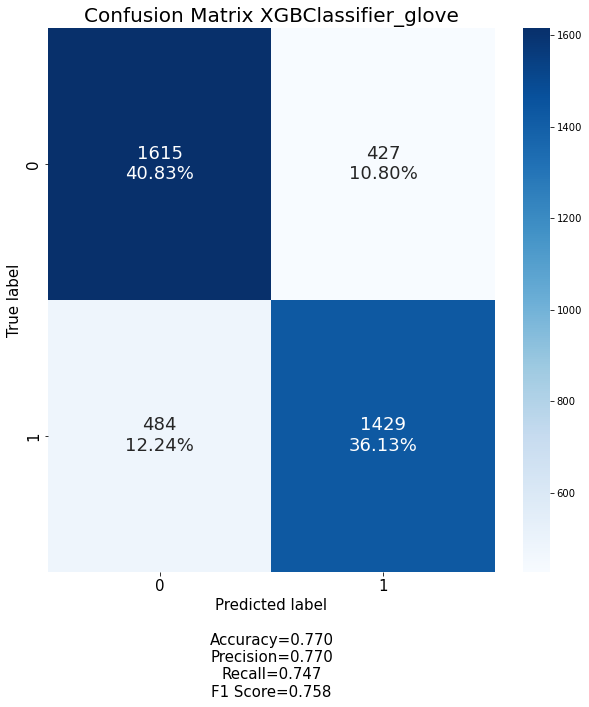

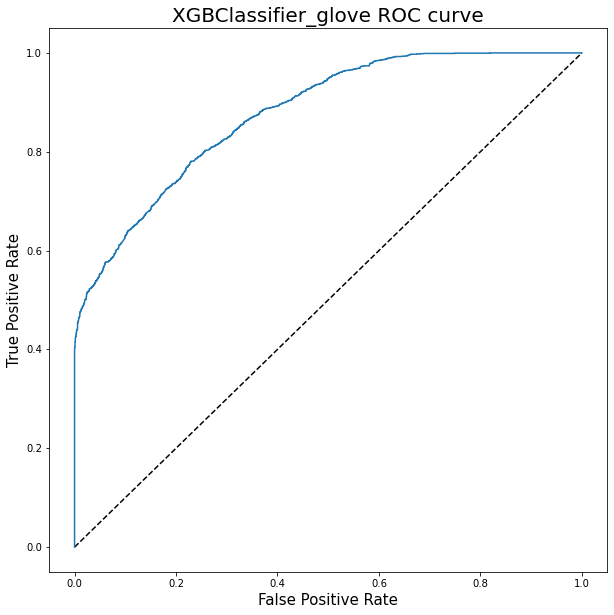

In [79]:
result = classification_result(X_train_glove, y_train_glove, X_test_glove, y_test_glove, XGBClassifier(objective='binary:logistic',
                                                                        n_jobs=-1,
                                                                        random_state=10), model_title = 'XGBClassifier_glove', result = result)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:51:50] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.60      0.58      0.59      2042
           1       0.57      0.59      0.58      1913

    accuracy                           0.59      3955
   macro avg       0.59      0.59      0.59      3955
weighted avg       0.59      0.59      0.59      3955



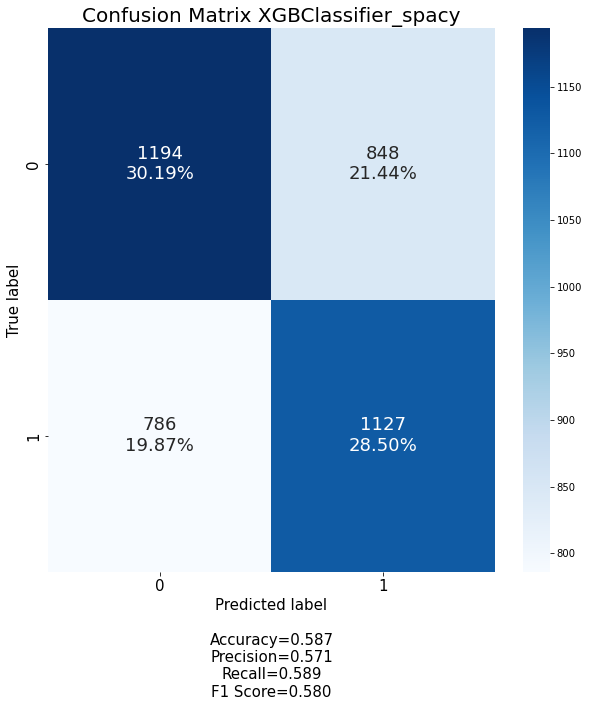

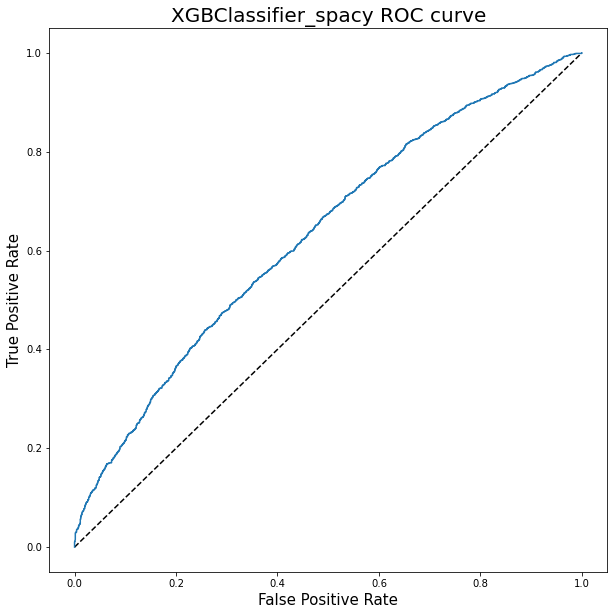

In [80]:
result = classification_result(X_train_spacy, y_train_spacy, X_test_spacy, y_test_spacy, XGBClassifier(objective='binary:logistic',
                                                                        n_jobs=-1,
                                                                        random_state=10), model_title = 'XGBClassifier_spacy', result = result)

In [81]:
result = pd.DataFrame(result)

In [82]:
result[result.index=='f1_score']

SVM   SVM_d2v  SVM_w2v  SVM_spacy  SVM_glove  \
f1_score  0.724956  0.615542  0.55637   0.601496   0.452221   

          Logistic Regression  Logistic Regression _w2v  \
f1_score             0.739521                  0.629317   

          Logistic Regression _doc2vec  Logistic Regression _spacy  \
f1_score                      0.617878                    0.598917   

          BernoulliNB  ...  KNeighborsClassifier  LGBMClassifier  \
f1_score     0.726946  ...              0.660214        0.732697   

          LGBMClassifier_w2v  LGBMClassifier_d2v  LGBMClassifier_glove  \
f1_score            0.748654            0.612853              0.748654   

          LGBMClassifier_spacy  XGBClassifier  XGBClassifier_w2v  \
f1_score              0.600313       0.730218           0.758291   

          XGBClassifier_glove  XGBClassifier_spacy  
f1_score             0.758291             0.579733  

[1 rows x 28 columns]

In [83]:
max(result[result.index=='f1_score'])

'XGBClassifier_w2v'

In [84]:
max(result[result.index=='precision'])

'XGBClassifier_w2v'

In [85]:
max(result[result.index=='recall'])

'XGBClassifier_w2v'

In [86]:
max(result[result.index=='accuracy'])

'XGBClassifier_w2v'

In [87]:
result.XGBClassifier_w2v

precision    0.769935
recall       0.746994
f1_score     0.758291
accuracy     0.769659
Name: XGBClassifier_w2v, dtype: float64

It seems that here XGBClassifier is the best classifier for the tweets in terms of f1 score with 0.758 and accuracy with 0.769.

## Advanced custom models with Neuronal Networks (Keras)

Let us first make a recall of our data that consists of positive and negative tweents. We allready maked tokenization and cleaned or text data. To see the result of that let us see what it contais.

In [88]:
if os.path.exists("data/processed/processed_nlp_data_2.pkl.gz"):
    logger.info(">>> Loading cleaned and preprocessed data...")
    data = pd.read_pickle("data/processed/processed_nlp_data.pkl.gz")
    logger.info(f">>> OK : {len(data)} data loaded from pickle file.")

INFO:__main__:>>> Loading cleaned and preprocessed data...
INFO:__main__:>>> OK : 19773 data loaded from pickle file.


In [89]:
pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data' + pkl_extension
vocabulary_file_path = vectorized_dataset_path + 'vocabulary_data' + pkl_extension
if os.path.exists(vectorized_dataset_file_path):
    logger.info(">>> Loading Tfidf Vectorized data...")
        
    # Load vectorized dataset
    with (open(vectorized_dataset_file_path, "rb")) as f:
        X = pickle.load(f)
    # Load vocabulary
    with (open(vocabulary_file_path, "rb")) as f:
        vocabulary = pickle.load(f)
else:
    logger.info(">>> Please create Tfidf Vectorized data...")

INFO:__main__:>>> Loading Tfidf Vectorized data...


In [90]:
pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data_doc2vec' + pkl_extension
if os.path.exists(vectorized_dataset_file_path):
    logger.info(">>> Loading Doc2Vec Vectorized data...")
        
    # Load vectorized dataset
    with (open(vectorized_dataset_file_path, "rb")) as f:
        X_d2v = pickle.load(f)
else:
    logger.info(">>> Please create Doc2Vec Vectorized data...")

INFO:__main__:>>> Loading Doc2Vec Vectorized data...


In [91]:
pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data_w2v' + pkl_extension
if os.path.exists(vectorized_dataset_file_path):
    logger.info(">>> Loading Word2Vec Vectorized data...")
        
    # Load vectorized dataset
    with (open(vectorized_dataset_file_path, "rb")) as f:
        X_w2v = pickle.load(f)
else:
    logger.info(">>> Please create Word2Vec Vectorized data...")

INFO:__main__:>>> Loading Word2Vec Vectorized data...


In [92]:
pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data_glove' + pkl_extension
if os.path.exists(vectorized_dataset_file_path):
    logger.info(">>> Loading Glove Vectorized data...")
        
    # Load vectorized dataset
    with (open(vectorized_dataset_file_path, "rb")) as f:
        X_glove = pickle.load(f)
else:
    logger.info(">>> Please create Word2Vec Vectorized data...")

INFO:__main__:>>> Loading Glove Vectorized data...


In [93]:
pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data_spacy' + pkl_extension
if os.path.exists(vectorized_dataset_file_path):
    logger.info(">>> Loading Spacy Vectorized data...")
        
    # Load vectorized dataset
    with (open(vectorized_dataset_file_path, "rb")) as f:
        X_spacy = pickle.load(f)
else:
    logger.info(">>> Please create Spacy Vectorized data...")

INFO:__main__:>>> Loading Spacy Vectorized data...


### Neuronal Networks
#### Feed Forward Neuronal Networks model
##### FFNN on word counting vector
Now we use a simple feed forward neuronal network on word counting vector as input. The preprocessing of the dataset is already done with spacy package. We create a simple neuronal network with three hidden layers.

In [95]:
X_train, X_test, y_train, y_test = train_test_split(data.CleanText, data.Target, train_size = 0.8, random_state = 1)
model_name = "ffnn_on_count"
vocabulary_size = X.shape[1]

results_data_path = os.path.join("results")
model_file_path = os.path.join(results_data_path, model_name)

if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    # Define vectorizer
    vectorize_layer = TextVectorization(
        output_mode="count",
        max_tokens=vocabulary_size,
        pad_to_max_tokens=True,
    )
    vectorize_layer.adapt(
        data.CleanText,
        batch_size=128,
    )

    # define NN model
    model = Sequential(name=model_name)
    model.add(Input(shape=(1,), dtype=tf.string))
    model.add(vectorize_layer)
    model.add(Dense(25, input_shape=(vocabulary_size,), activation="relu"))
    model.add(Dropout(0.2))
    #model.add(Dense(25, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy",
        ],
    )

    # fit NN model
    model.fit(
        X_train,
        y_train,
        epochs=10,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ]
    )

    model.save(model_file_path)


print(model.summary())

2022-09-22 09:55:11.591980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10


2022-09-22 09:55:12.073321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - ETA: 0s - loss: 0.6559 - accuracy: 0.6736

2022-09-22 09:55:13.595085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 2s 15ms/step - loss: 0.6559 - accuracy: 0.6736 - val_loss: 0.6092 - val_accuracy: 0.7155
Epoch 2/10
99/99 [==============================] - 1s 14ms/step - loss: 0.5418 - accuracy: 0.7718 - val_loss: 0.5546 - val_accuracy: 0.7257
Epoch 3/10
99/99 [==============================] - 1s 15ms/step - loss: 0.4603 - accuracy: 0.8121 - val_loss: 0.5448 - val_accuracy: 0.7307
Epoch 4/10
99/99 [==============================] - 1s 13ms/step - loss: 0.4061 - accuracy: 0.8342 - val_loss: 0.5467 - val_accuracy: 0.7276
Epoch 5/10
99/99 [==============================] - 1s 13ms/step - loss: 0.3634 - accuracy: 0.8581 - val_loss: 0.5570 - val_accuracy: 0.7285


2022-09-22 09:55:20.058556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 09:55:20.061175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
INFO:tensorflow:Assets written to: results/ffnn_on_count/assets


Model: "ffnn_on_count"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 15722)            0         
 torization)                                                     
                                                                 
 dense (Dense)               (None, 25)                393075    
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 393,101
Trainable params: 393,101
Non-trainable params: 0
_________________________________________________________________
None


24/31 [======================>.......] - ETA: 0s

2022-09-22 09:55:25.121012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.76      0.71      0.73      2042
           1       0.71      0.76      0.73      1913

    accuracy                           0.73      3955
   macro avg       0.73      0.73      0.73      3955
weighted avg       0.73      0.73      0.73      3955



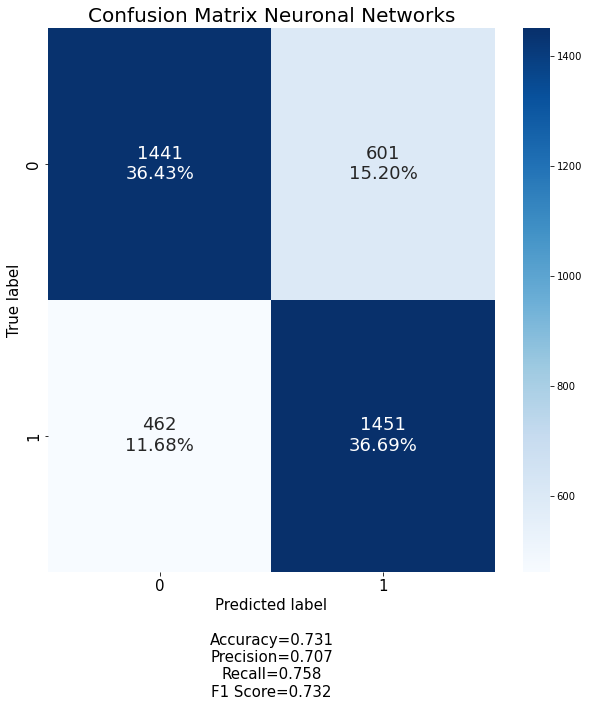

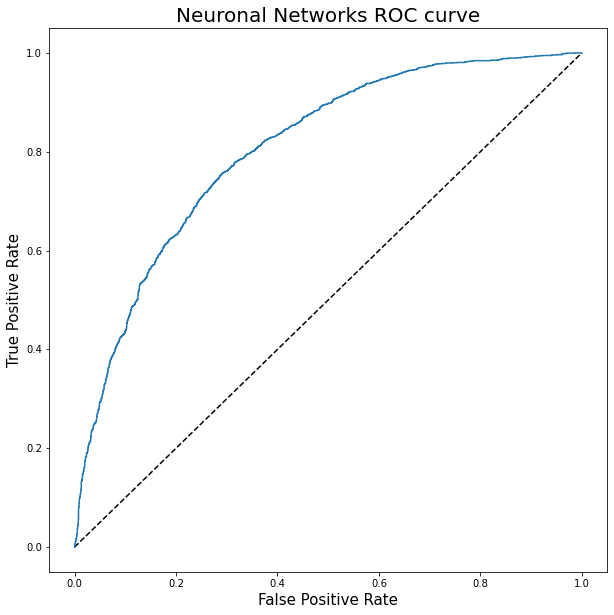

In [96]:
y_test_pred_proba = model.predict(
    X_test,
    batch_size=128
)

y_test_pred = [round(pred_proba[0]) for pred_proba in y_test_pred_proba]
print(classification_report(y_test, y_test_pred))
model_title = 'Neuronal Networks'
accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test, y_test_pred), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
# performing the roc curve calculations
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
# Plotting the ROC Curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('{0} ROC curve'.format(model_title), size=20)
plt.show()

##### FFNN on w2v vectorized data

In [97]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, data.Target, train_size = 0.8, random_state = 1)
model_name_w2v = "ffnn_on_w2v"
vocabulary_size_w2v = X_w2v.shape[1]
model_file_path_w2v = os.path.join(results_data_path, model_name_w2v)
model_name = model_name_w2v
model_file_path = model_file_path_w2v
vocabulary_size = vocabulary_size_w2v


if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    # define NN model
    model = Sequential(name=model_name)
    model.add(Dense(25, input_shape=(vocabulary_size,), activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy"
        ],
    )

    # fit NN model
    model.fit(
        X_train_w2v,
        y_train_w2v,
        epochs=20,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ]
    )

    model.save(model_file_path)


print(model.summary())

Epoch 1/20
 9/99 [=>............................] - ETA: 0s - loss: 321.5470 - accuracy: 0.4688 

2022-09-22 09:55:35.147715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 1s 8ms/step - loss: 185.0564 - accuracy: 0.5005 - val_loss: 57.7715 - val_accuracy: 0.4842
Epoch 2/20
10/99 [==>...........................] - ETA: 0s - loss: 110.8387 - accuracy: 0.5414

2022-09-22 09:55:35.950543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 1s 6ms/step - loss: 100.4030 - accuracy: 0.5048 - val_loss: 30.5995 - val_accuracy: 0.5028
Epoch 3/20
99/99 [==============================] - 1s 6ms/step - loss: 65.2657 - accuracy: 0.5019 - val_loss: 26.8377 - val_accuracy: 0.4949
Epoch 4/20
99/99 [==============================] - 1s 6ms/step - loss: 41.5252 - accuracy: 0.5057 - val_loss: 17.9895 - val_accuracy: 0.4946
Epoch 5/20
99/99 [==============================] - 1s 7ms/step - loss: 25.9619 - accuracy: 0.4998 - val_loss: 9.2444 - val_accuracy: 0.4965
Epoch 6/20
99/99 [==============================] - 1s 7ms/step - loss: 13.8540 - accuracy: 0.4897 - val_loss: 5.0209 - val_accuracy: 0.4953
Epoch 7/20
99/99 [==============================] - 1s 7ms/step - loss: 6.5621 - accuracy: 0.5049 - val_loss: 3.0376 - val_accuracy: 0.4912
Epoch 8/20
99/99 [==============================] - 1s 7ms/step - loss: 2.8104 - accuracy: 0.5036 - val_loss: 1.5267 - val_accuracy: 0.5149
Epoch 9/20
99/99 [====

INFO:tensorflow:Assets written to: results/ffnn_on_w2v/assets


Model: "ffnn_on_w2v"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 2,551
Trainable params: 2,551
Non-trainable params: 0
_________________________________________________________________
None


31/31 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.52      0.96      0.67      2042
           1       0.51      0.04      0.08      1913

    accuracy                           0.52      3955
   macro avg       0.51      0.50      0.38      3955
weighted avg       0.51      0.52      0.39      3955



2022-09-22 09:55:55.358314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


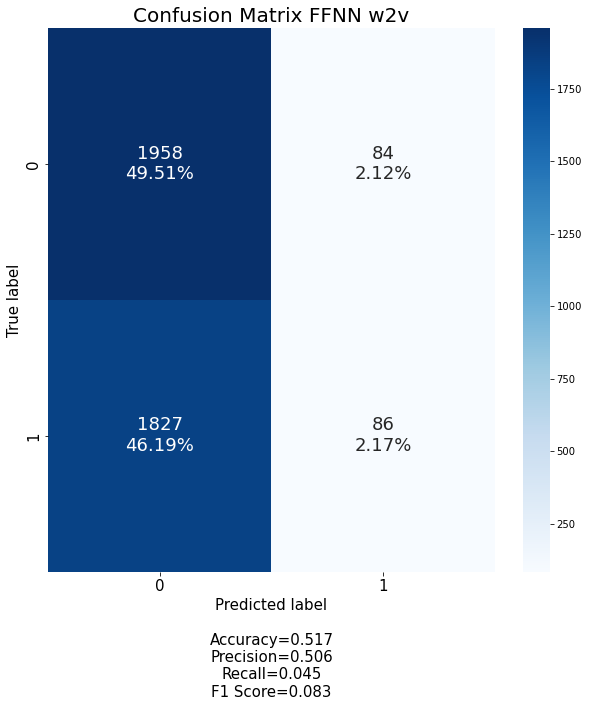

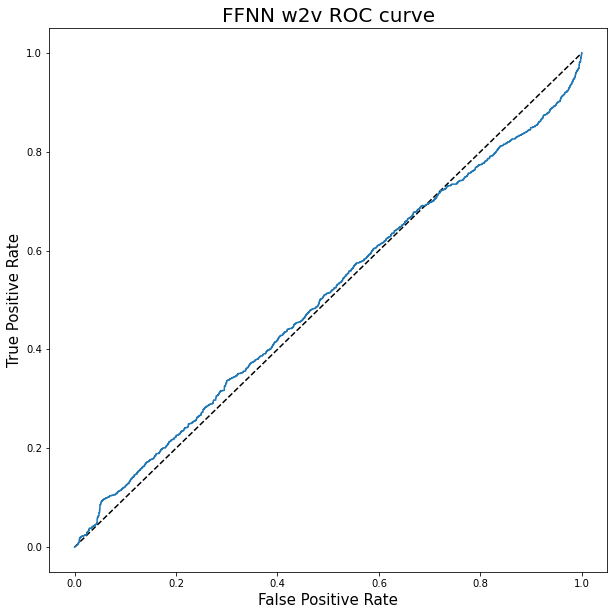

In [98]:
y_test_pred_proba_w2v = model.predict(
    X_test_w2v,
    batch_size=128
)

y_test_pred_w2v = [round(pred_proba[0]) for pred_proba in y_test_pred_proba_w2v]

print(classification_report(y_test_w2v, y_test_pred_w2v))

model_title = 'FFNN w2v'
accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test_w2v, y_test_pred_w2v), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
# performing the roc curve calculations
fpr, tpr, thresholds = roc_curve(y_test_w2v, y_test_pred_proba_w2v)
# Plotting the ROC Curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('{0} ROC curve'.format(model_title), size=20)
plt.show()

##### FFNN on spacy vectorized data

In [99]:
results_data_path = os.path.join("results")
X_train_spacy, X_test_spacy, y_train_spacy, y_test_spacy = train_test_split(X_spacy, data.Target, train_size = 0.8, random_state = 1)
model_name_spacy = "ffnn_on_spacy"
vocabulary_size_spacy = X_spacy.shape[1]
model_file_path_spacy = os.path.join(results_data_path, model_name_spacy)
model_name = model_name_spacy
model_file_path = model_file_path_spacy
vocabulary_size = vocabulary_size_spacy


if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    # define NN model
    model = Sequential(name=model_name)
    model.add(Dense(25, input_shape=(vocabulary_size,), activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy"
        ],
    )

    # fit NN model
    model.fit(
        X_train_spacy,
        y_train_spacy,
        epochs=20,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ]
    )

    model.save(model_file_path)


print(model.summary())

Epoch 1/20
 9/99 [=>............................] - ETA: 0s - loss: 0.6961 - accuracy: 0.5477 

2022-09-22 09:56:24.328921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 1s 8ms/step - loss: 0.6898 - accuracy: 0.5418 - val_loss: 0.6884 - val_accuracy: 0.5398
Epoch 2/20
11/99 [==>...........................] - ETA: 0s - loss: 0.6764 - accuracy: 0.5568

2022-09-22 09:56:25.114073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 1s 6ms/step - loss: 0.6784 - accuracy: 0.5683 - val_loss: 0.6778 - val_accuracy: 0.5809
Epoch 3/20
99/99 [==============================] - 1s 6ms/step - loss: 0.6699 - accuracy: 0.5831 - val_loss: 0.6736 - val_accuracy: 0.5904
Epoch 4/20
99/99 [==============================] - 1s 6ms/step - loss: 0.6640 - accuracy: 0.5942 - val_loss: 0.6710 - val_accuracy: 0.5860
Epoch 5/20
99/99 [==============================] - 1s 6ms/step - loss: 0.6596 - accuracy: 0.5981 - val_loss: 0.6658 - val_accuracy: 0.5954
Epoch 6/20
99/99 [==============================] - 1s 6ms/step - loss: 0.6567 - accuracy: 0.6034 - val_loss: 0.6645 - val_accuracy: 0.5977
Epoch 7/20
99/99 [==============================] - 1s 6ms/step - loss: 0.6532 - accuracy: 0.6058 - val_loss: 0.6622 - val_accuracy: 0.5999
Epoch 8/20
99/99 [==============================] - 1s 6ms/step - loss: 0.6504 - accuracy: 0.6152 - val_loss: 0.6624 - val_accuracy: 0.6027
Epoch 9/20
99/99 [=============

INFO:tensorflow:Assets written to: results/ffnn_on_spacy/assets


Model: "ffnn_on_spacy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 25)                2425      
                                                                 
 dropout_2 (Dropout)         (None, 25)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 2,451
Trainable params: 2,451
Non-trainable params: 0
_________________________________________________________________
None


31/31 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.64      0.53      0.58      2042
           1       0.58      0.69      0.63      1913

    accuracy                           0.61      3955
   macro avg       0.61      0.61      0.60      3955
weighted avg       0.61      0.61      0.60      3955



2022-09-22 09:56:40.353856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


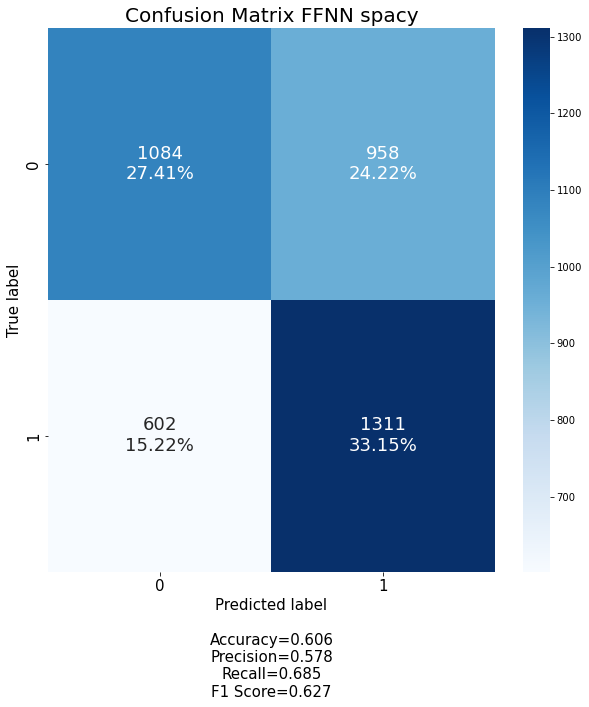

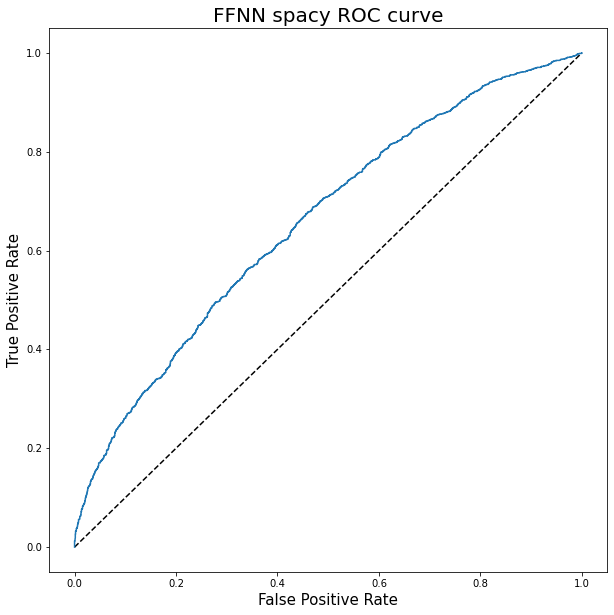

In [100]:
y_test_pred_proba_spacy = model.predict(
    X_test_spacy,
    batch_size=128
)

y_test_pred_spacy = [round(pred_proba[0]) for pred_proba in y_test_pred_proba_spacy]
print(classification_report(y_test_spacy, y_test_pred_spacy))

model_title = 'FFNN spacy'
accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test_spacy, y_test_pred_spacy), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
# performing the roc curve calculations
fpr, tpr, thresholds = roc_curve(y_test_spacy, y_test_pred_proba_spacy)
# Plotting the ROC Curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('{0} ROC curve'.format(model_title), size=20)
plt.show()

First I will start by tokenizing the data. But, here instead of using TfidfVectorizer tokenization we shall use using the pretrained Word Embedding model like GloVe & Word2Vec model in order to tokenize our dataset. These two models shows performace in the real world classification problems. For a clarification of what meens World Embedding, it is one of the most popular representation of document vocabulary capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc. It's a feature vector representation of words which are used for other natural language processing applications, therefore it is taken here as a vectorization step of our tweet classification approach. For the begining we will start by trying the world2vec model on our dataset.

##### FFNN using embedding layer

In [101]:
X_train, X_test, y_train, y_test = train_test_split(data.CleanText, data.Target, train_size = 0.8, random_state = 1)
model_name = "ffnn_on_count_embedding"
max_features = 10000
embedding_dim = 100
sequence_length = 30
vocabulary_size = X.shape[1]

results_data_path = os.path.join("results")
model_file_path = os.path.join(results_data_path, model_name)

if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    # Define vectorizer
    vectorize_layer = TextVectorization(
        output_mode="int",
        max_tokens=max_features,
        output_sequence_length=sequence_length,
    )
    vectorize_layer.adapt(
        data.CleanText,
        batch_size=128,
    )

    # define NN model
    model = Sequential(name=model_name)
    model.add(Input(shape=(1,), dtype=tf.string))
    model.add(vectorize_layer)
    
    # Embedding layer
    model.add(
        Embedding(
            max_features,
            embedding_dim,
            input_length=sequence_length,
        )
    )
    model.add(Flatten())
    
    
    model.add(Dense(25, input_shape=(vocabulary_size,), activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy",
            AUC(curve="ROC", name="ROC_AUC"),
            AUC(curve="PR", name="AP"),
        ],
    )

    # fit NN model
    model.fit(
        X_train,
        y_train,
        epochs=10,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ],
        workers=10,
        use_multiprocessing=True,
    )

    model.save(model_file_path)


print(model.summary())

2022-09-22 09:57:07.978561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10


2022-09-22 09:57:08.611800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - ETA: 0s - loss: 0.6721 - accuracy: 0.5938 - ROC_AUC: 0.6368 - AP: 0.6438

2022-09-22 09:57:12.019733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 4s 34ms/step - loss: 0.6721 - accuracy: 0.5938 - ROC_AUC: 0.6368 - AP: 0.6438 - val_loss: 0.6079 - val_accuracy: 0.6798 - val_ROC_AUC: 0.7721 - val_AP: 0.7542
Epoch 2/10
99/99 [==============================] - 3s 26ms/step - loss: 0.5187 - accuracy: 0.7588 - ROC_AUC: 0.8325 - AP: 0.8237 - val_loss: 0.5484 - val_accuracy: 0.7200 - val_ROC_AUC: 0.7946 - val_AP: 0.7792
Epoch 3/10
99/99 [==============================] - 3s 26ms/step - loss: 0.3707 - accuracy: 0.8485 - ROC_AUC: 0.9202 - AP: 0.9178 - val_loss: 0.5843 - val_accuracy: 0.7155 - val_ROC_AUC: 0.7853 - val_AP: 0.7663
Epoch 4/10
99/99 [==============================] - 3s 25ms/step - loss: 0.2480 - accuracy: 0.9109 - ROC_AUC: 0.9650 - AP: 0.9630 - val_loss: 0.6641 - val_accuracy: 0.7032 - val_ROC_AUC: 0.7666 - val_AP: 0.7394


INFO:tensorflow:Assets written to: results/ffnn_on_count_embedding/assets


Model: "ffnn_on_count_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 30)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 30, 100)           1000000   
                                                                 
 flatten (Flatten)           (None, 3000)              0         
                                                                 
 dense_6 (Dense)             (None, 25)                75025     
                                                                 
 dropout_3 (Dropout)         (None, 25)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                           

31/31 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.71      0.70      0.71      2042
           1       0.69      0.70      0.69      1913

    accuracy                           0.70      3955
   macro avg       0.70      0.70      0.70      3955
weighted avg       0.70      0.70      0.70      3955



2022-09-22 09:57:27.319062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


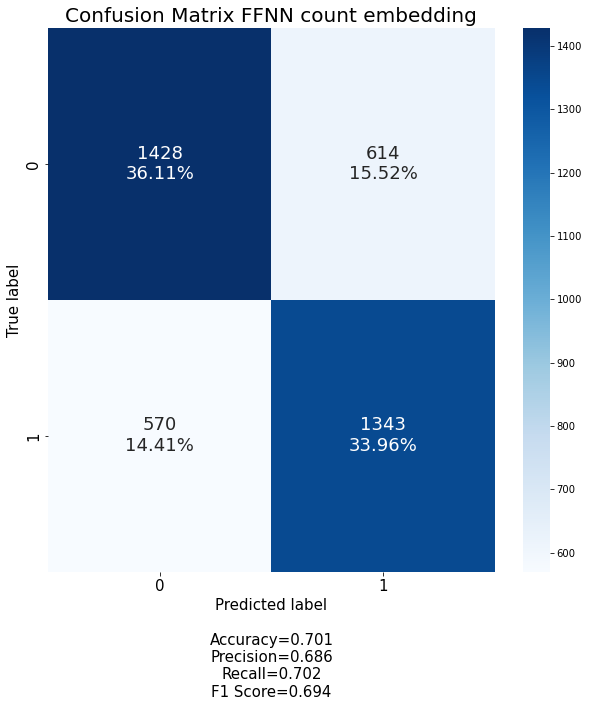

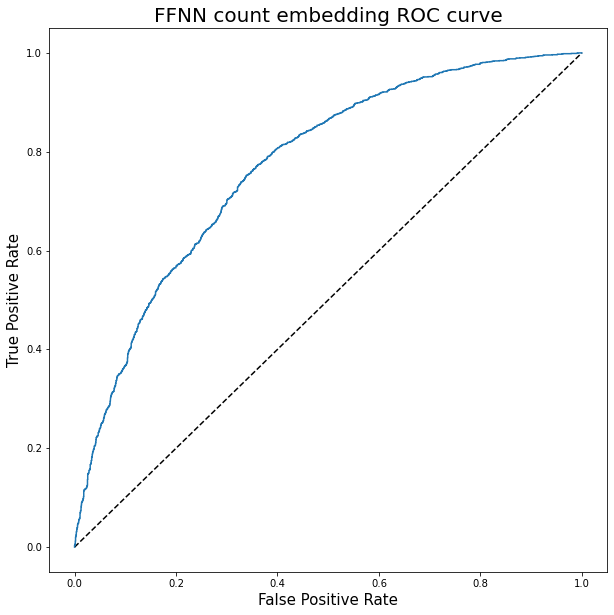

In [102]:
y_test_pred_proba_count_embeding = model.predict(
    X_test,
    batch_size=128
)

y_test_pred_count_embeding = [round(pred_proba[0]) for pred_proba in y_test_pred_proba_count_embeding]
print(classification_report(y_test, y_test_pred_count_embeding))
model_title = 'FFNN count embedding'
accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test, y_test_pred_count_embeding), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
# performing the roc curve calculations
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_count_embeding)
# Plotting the ROC Curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('{0} ROC curve'.format(model_title), size=20)
plt.show()

##### FFNN on w2v with embedding layer

In [103]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, data.Target, train_size = 0.8, random_state = 1)
model_name_w2v = "ffnn_on_w2v_embedding"
vocabulary_size_w2v = X_w2v.shape[1]
model_file_path_w2v = os.path.join(results_data_path, model_name_w2v)
model_name = model_name_w2v
model_file_path = model_file_path_w2v
vocabulary_size = vocabulary_size_w2v


if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix_w2v], input_length=100, trainable=False)
    
    # define NN model
    model = Sequential(name=model_name)
    model.add(embedding_layer)
    model.add(Flatten())
    
    model.add(Dense(25, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy"
        ],
    )

    # fit NN model
    model.fit(
        X_train_w2v,
        y_train_w2v,
        epochs=20,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ]
    )

    model.save(model_file_path)


print(model.summary())

Epoch 1/20
 1/99 [..............................] - ETA: 34s - loss: 0.6932 - accuracy: 0.5391

2022-09-22 09:57:45.713753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 1s 10ms/step - loss: 0.6923 - accuracy: 0.5312 - val_loss: 0.6917 - val_accuracy: 0.5145
Epoch 2/20
 1/99 [..............................] - ETA: 0s - loss: 0.6907 - accuracy: 0.5625

2022-09-22 09:57:46.715086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 1s 8ms/step - loss: 0.6883 - accuracy: 0.5774 - val_loss: 0.6872 - val_accuracy: 0.5913
Epoch 3/20
99/99 [==============================] - 1s 9ms/step - loss: 0.6816 - accuracy: 0.6216 - val_loss: 0.6825 - val_accuracy: 0.5913
Epoch 4/20
99/99 [==============================] - 1s 9ms/step - loss: 0.6724 - accuracy: 0.6268 - val_loss: 0.6756 - val_accuracy: 0.6018
Epoch 5/20
99/99 [==============================] - 1s 9ms/step - loss: 0.6624 - accuracy: 0.6302 - val_loss: 0.6710 - val_accuracy: 0.5996
Epoch 6/20
99/99 [==============================] - 1s 9ms/step - loss: 0.6531 - accuracy: 0.6341 - val_loss: 0.6655 - val_accuracy: 0.5961
Epoch 7/20
99/99 [==============================] - 1s 8ms/step - loss: 0.6456 - accuracy: 0.6391 - val_loss: 0.6631 - val_accuracy: 0.6030
Epoch 8/20
99/99 [==============================] - 1s 9ms/step - loss: 0.6385 - accuracy: 0.6474 - val_loss: 0.6612 - val_accuracy: 0.6034
Epoch 9/20
99/99 [=============

INFO:tensorflow:Assets written to: results/ffnn_on_w2v_embedding/assets


Model: "ffnn_on_w2v_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1572300   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_8 (Dense)             (None, 25)                250025    
                                                                 
 dropout_4 (Dropout)         (None, 25)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 26        
                                                                 
Total params: 1,822,351
Trainable params: 250,051
Non-trainable params: 1,572,300
_________________________________________________________________
None


31/31 [==============================] - 0s 4ms/step


2022-09-22 09:58:01.131926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.62      0.56      0.59      2042
           1       0.57      0.63      0.60      1913

    accuracy                           0.60      3955
   macro avg       0.60      0.60      0.60      3955
weighted avg       0.60      0.60      0.60      3955



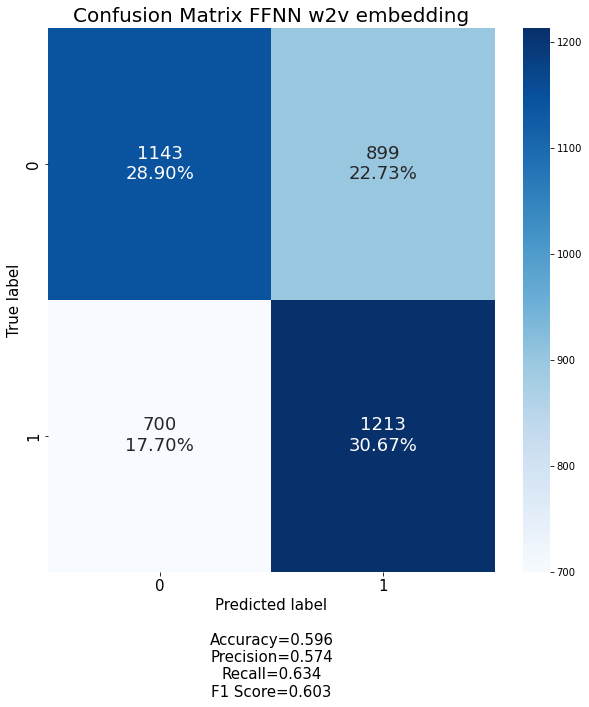

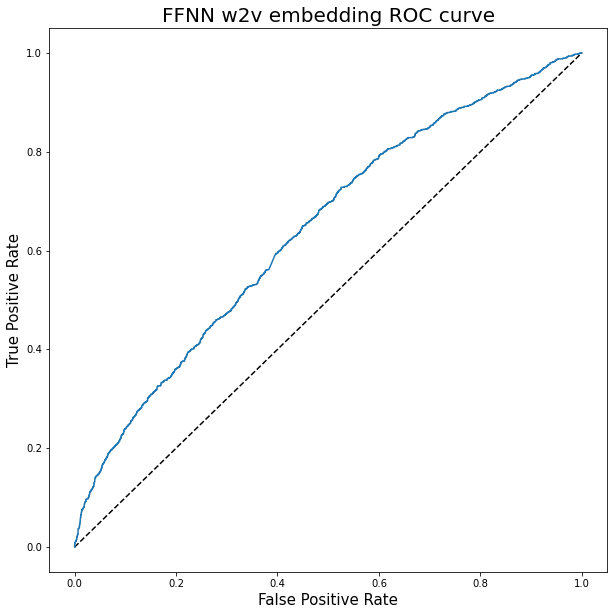

In [104]:
y_test_pred_proba_w2v = model.predict(
    X_test_w2v,
    batch_size=128
)

y_test_pred_w2v = [round(pred_proba[0]) for pred_proba in y_test_pred_proba_w2v]

print(classification_report(y_test_w2v, y_test_pred_w2v))

model_title = 'FFNN w2v embedding'
accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test_w2v, y_test_pred_w2v), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
# performing the roc curve calculations
fpr, tpr, thresholds = roc_curve(y_test_w2v, y_test_pred_proba_w2v)
# Plotting the ROC Curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('{0} ROC curve'.format(model_title), size=20)
plt.show()

##### FFNN on glove with embedding layer

In [106]:
X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(X_glove, data.Target, train_size = 0.8, random_state = 1)
model_name_glove = "ffnn_on_glove_embedding"
vocabulary_size_glove = embedding_matrix_glove.shape[0]
model_file_path_glove = os.path.join(results_data_path, model_name_glove)
model_name = model_name_glove
model_file_path = model_file_path_glove
vocabulary_size = vocabulary_size_glove


if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    embedding_layer = Embedding(vocabulary_size, 100, weights=[embedding_matrix_glove], input_length=100, trainable=False)
    
    # define NN model
    model = Sequential(name=model_name)
    model.add(embedding_layer)
    model.add(Flatten())
    
    model.add(Dense(25, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy"
        ],
    )

    # fit NN model
    model.fit(
        X_train_glove,
        y_train_glove,
        epochs=20,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ]
    )

    model.save(model_file_path)


print(model.summary())

Epoch 1/20
 1/99 [..............................] - ETA: 32s - loss: 0.6862 - accuracy: 0.5000

2022-09-22 09:58:43.963073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 1s 10ms/step - loss: 0.6438 - accuracy: 0.6213 - val_loss: 0.6134 - val_accuracy: 0.6704
Epoch 2/20
 1/99 [..............................] - ETA: 0s - loss: 0.5993 - accuracy: 0.6562

2022-09-22 09:58:44.953587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 1s 9ms/step - loss: 0.5814 - accuracy: 0.6924 - val_loss: 0.5995 - val_accuracy: 0.6805
Epoch 3/20
99/99 [==============================] - 1s 9ms/step - loss: 0.5582 - accuracy: 0.7107 - val_loss: 0.5997 - val_accuracy: 0.6811
Epoch 4/20
99/99 [==============================] - 1s 9ms/step - loss: 0.5356 - accuracy: 0.7278 - val_loss: 0.6005 - val_accuracy: 0.6871


INFO:tensorflow:Assets written to: results/ffnn_on_glove_embedding/assets


Model: "ffnn_on_glove_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          1572300   
                                                                 
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_10 (Dense)            (None, 25)                250025    
                                                                 
 dropout_5 (Dropout)         (None, 25)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,822,351
Trainable params: 250,051
Non-trainable params: 1,572,300
_________________________________________________________________
None


31/31 [==============================] - 0s 4ms/step


2022-09-22 09:58:56.915419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.70      0.67      0.68      2042
           1       0.66      0.69      0.67      1913

    accuracy                           0.68      3955
   macro avg       0.68      0.68      0.68      3955
weighted avg       0.68      0.68      0.68      3955



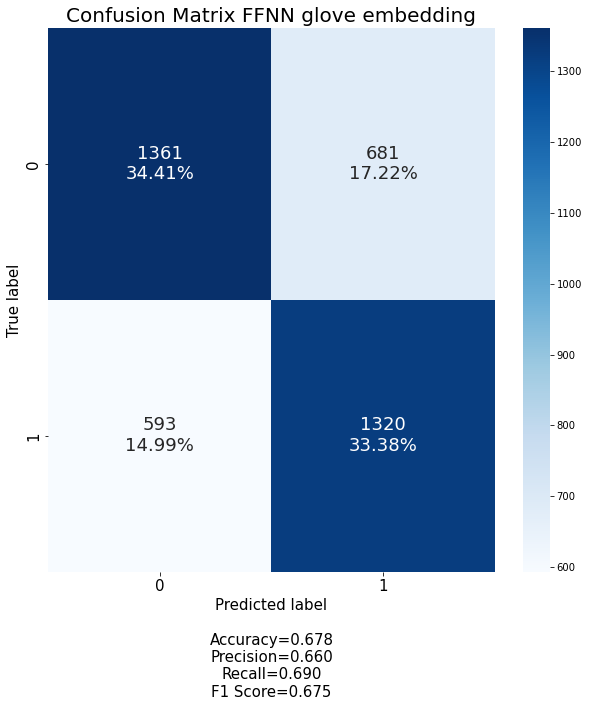

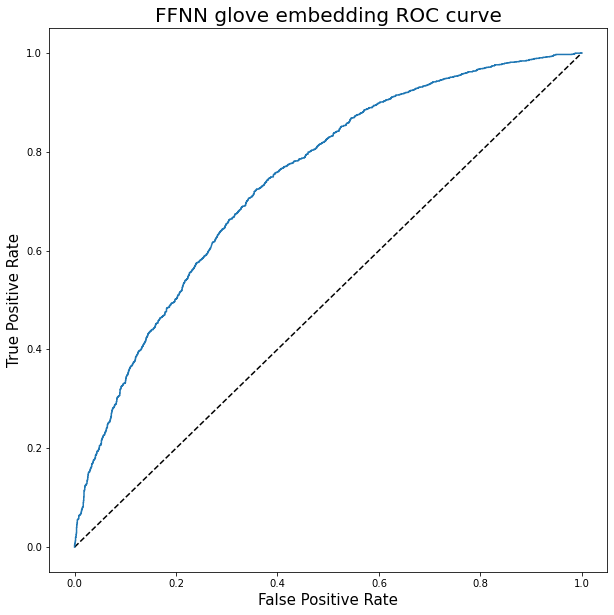

In [107]:
y_test_pred_proba_glove = model.predict(
    X_test_glove,
    batch_size=128
)

y_test_pred_glove = [round(pred_proba[0]) for pred_proba in y_test_pred_proba_glove]

print(classification_report(y_test_glove, y_test_pred_glove))

model_title = 'FFNN glove embedding'
accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test_glove, y_test_pred_glove), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
# performing the roc curve calculations
fpr, tpr, thresholds = roc_curve(y_test_glove, y_test_pred_proba_glove)
# Plotting the ROC Curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('{0} ROC curve'.format(model_title), size=20)
plt.show()

#### RNN (Recurrent Neural Network) models

##### RNN on word counting vector with embedding layer

In [108]:
X_train, X_test, y_train, y_test = train_test_split(data.CleanText, data.Target, train_size = 0.8, random_state = 1)


results_data_path = os.path.join("results")
model_name = "rnn_on_embedded"
model_file_path = os.path.join(results_data_path, model_name)

# Model constants.
max_features = 10000
sequence_length = 30
embedding_dim = 100
rnn_units = 100

if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    # Define vectorizer
    vectorize_layer = TextVectorization(
        output_mode="int",
        max_tokens=max_features,
        output_sequence_length=sequence_length,
    )
    vectorize_layer.adapt(
        data.CleanText,
        batch_size=128,
    )

    # define NN model
    model = Sequential(name=model_name)
    model.add(Input(shape=(1,), dtype=tf.string))
    model.add(vectorize_layer)

    # Embedding layer
    model.add(
        Embedding(
            max_features,
            embedding_dim,
            input_length=sequence_length,
        )
    )

    # RNN layer
    model.add(SimpleRNN(units=rnn_units, dropout=0.2))

    # Dense layers
    model.add(Dense(25, input_shape=(max_features,), activation="relu"))
    
    #model.add(Dense(10, activation="relu"))

    # Classification layer
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy"
        ],
    )

    # fit NN model
    model.fit(
        X_train,
        y_train,
        epochs=10,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ]
    )

    model.save(model_file_path)


print(model.summary())

2022-09-22 09:59:17.616603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10


2022-09-22 09:59:18.296026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - ETA: 0s - loss: 0.6434 - accuracy: 0.6226

2022-09-22 10:00:07.701471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 51s 508ms/step - loss: 0.6434 - accuracy: 0.6226 - val_loss: 0.6093 - val_accuracy: 0.6808
Epoch 2/10
99/99 [==============================] - 50s 504ms/step - loss: 0.4802 - accuracy: 0.7803 - val_loss: 0.5875 - val_accuracy: 0.7032
Epoch 3/10
99/99 [==============================] - 49s 495ms/step - loss: 0.3387 - accuracy: 0.8580 - val_loss: 0.6744 - val_accuracy: 0.6738
Epoch 4/10
99/99 [==============================] - 49s 495ms/step - loss: 0.2506 - accuracy: 0.9003 - val_loss: 0.7639 - val_accuracy: 0.6871


INFO:tensorflow:Assets written to: results/rnn_on_embedded/assets


Model: "rnn_on_embedded"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 30)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 30, 100)           1000000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               20100     
                                                                 
 dense_12 (Dense)            (None, 25)                2525      
                                                                 
 dense_13 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,022,651
Trainable params: 1,022,651
Non-trainable params: 0
_________________________________________

 3/31 [=>............................] - ETA: 1s

2022-09-22 10:04:16.456398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 1s 41ms/step
              precision    recall  f1-score   support

           0       0.71      0.69      0.70      2042
           1       0.68      0.70      0.69      1913

    accuracy                           0.69      3955
   macro avg       0.69      0.69      0.69      3955
weighted avg       0.69      0.69      0.69      3955



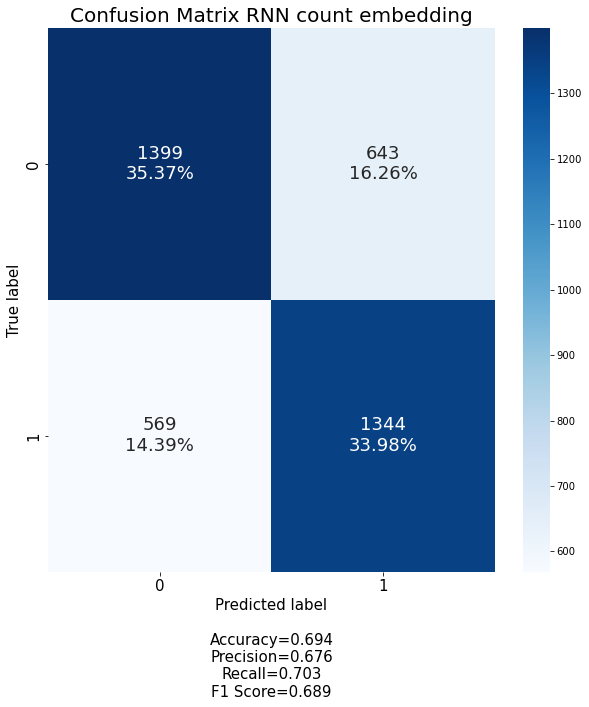

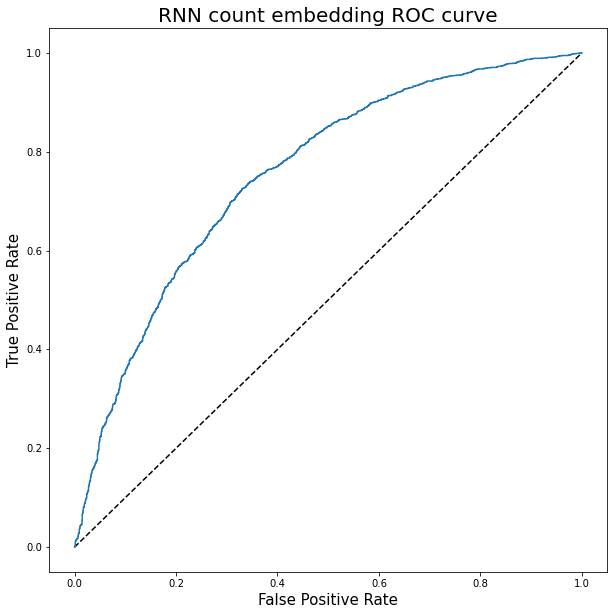

In [109]:
y_test_pred_proba_rnn = model.predict(
    X_test,
    batch_size=128
)

y_test_pred_rnn = [round(pred_proba[0]) for pred_proba in y_test_pred_proba_rnn]

print(classification_report(y_test, y_test_pred_rnn))

model_title = 'RNN count embedding'
accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test, y_test_pred_rnn), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
# performing the roc curve calculations
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_rnn)
# Plotting the ROC Curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('{0} ROC curve'.format(model_title), size=20)
plt.show()

##### RNN on word counting vector on w2v with embedding layer

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_w2v, data.Target, train_size = 0.8, random_state = 1)

vocabulary_size_w2v = embedding_matrix_w2v.shape[0]
results_data_path = os.path.join("results")
model_name = "rnn_on_embedded_w2v"
model_file_path = os.path.join(results_data_path, model_name)
vocab_size = vocabulary_size_w2v

# Model constants.
max_features = 10000
sequence_length = 30
embedding_dim = 100
rnn_units = 25

if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix_w2v], input_length=100, trainable=False)

    # define NN model
    model = Sequential(name=model_name)
    

    # Embedding layer
    model.add(embedding_layer)
    model.add(Dropout(0.5))
    #model.add(Flatten())
    # RNN layer
    model.add(SimpleRNN(units=rnn_units, dropout=0.2))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation="relu"))

    # Classification layer
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy"
        ],
    )

    # fit NN model
    model.fit(
        X_train,
        y_train,
        epochs=10,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ]
    )

    model.save(model_file_path)


print(model.summary())

Metal device set to: Apple M1 Pro
Epoch 1/10


2022-09-22 10:44:03.544629: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-22 10:44:03.544743: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-09-22 10:44:03.690333: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-22 10:44:04.127112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5048

2022-09-22 10:47:23.759592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 208s 2s/step - loss: 0.6933 - accuracy: 0.5048 - val_loss: 0.6958 - val_accuracy: 0.4836
Epoch 2/10
99/99 [==============================] - 205s 2s/step - loss: 0.6925 - accuracy: 0.5192 - val_loss: 0.6923 - val_accuracy: 0.5259
Epoch 3/10
99/99 [==============================] - 220s 2s/step - loss: 0.6925 - accuracy: 0.5104 - val_loss: 0.6916 - val_accuracy: 0.5411
Epoch 4/10
99/99 [==============================] - 226s 2s/step - loss: 0.6906 - accuracy: 0.5322 - val_loss: 0.6878 - val_accuracy: 0.5635
Epoch 5/10
99/99 [==============================] - 222s 2s/step - loss: 0.6896 - accuracy: 0.5342 - val_loss: 0.6889 - val_accuracy: 0.5518
Epoch 6/10
99/99 [==============================] - 216s 2s/step - loss: 0.6868 - accuracy: 0.5510 - val_loss: 0.6882 - val_accuracy: 0.5161


INFO:tensorflow:Assets written to: results/rnn_on_embedded_w2v/assets


Model: "rnn_on_embedded_w2v"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1572300   
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 25)                3150      
                                                                 
 dense (Dense)               (None, 25)                650       
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 1,576,126
Trainable params: 3,826
Non-trainable params: 1,572,300
_________________________________________________________________
None


2022-09-22 11:06:24.756558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 11s 349ms/step
              precision    recall  f1-score   support

           0       0.69      0.14      0.23      2042
           1       0.50      0.93      0.65      1913

    accuracy                           0.52      3955
   macro avg       0.60      0.54      0.44      3955
weighted avg       0.60      0.52      0.44      3955



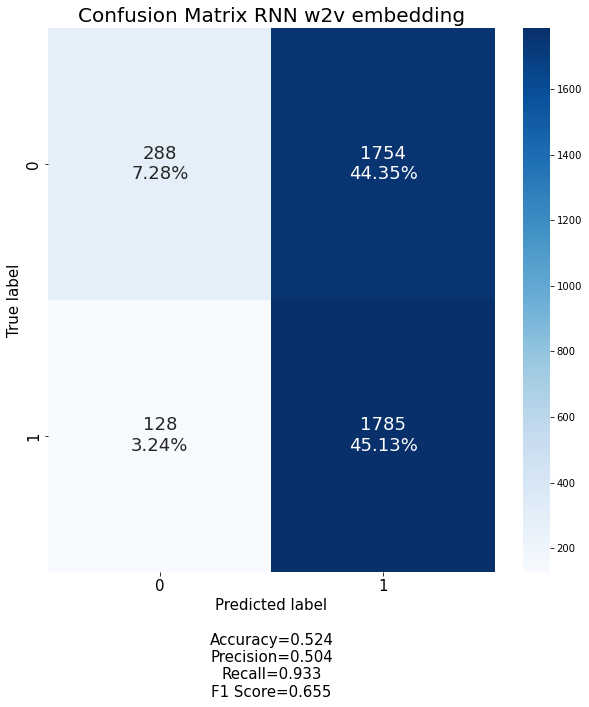

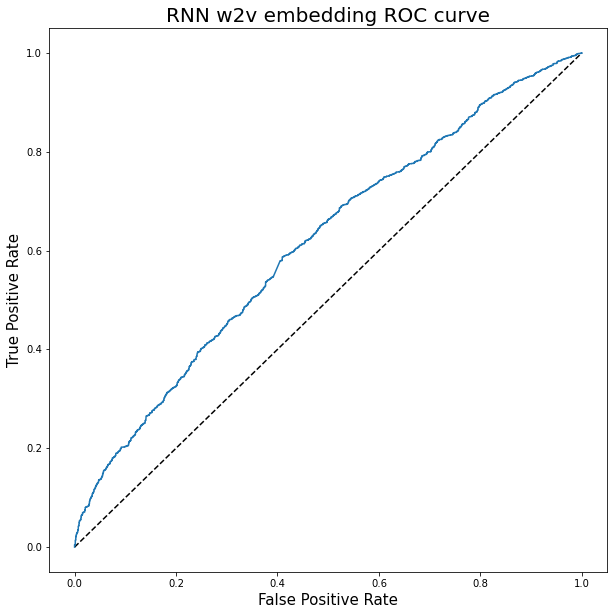

In [19]:
y_test_pred_proba_rnn = model.predict(
    X_test,
    batch_size=128
)

y_test_pred_rnn = [round(pred_proba[0]) for pred_proba in y_test_pred_proba_rnn]

print(classification_report(y_test, y_test_pred_rnn))

model_title = 'RNN w2v embedding'
accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test, y_test_pred_rnn), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
# performing the roc curve calculations
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_rnn)
# Plotting the ROC Curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('{0} ROC curve'.format(model_title), size=20)
plt.show()

#### LSTM

##### LSTM and Convolutional Neural Network for Sequence Classification on word counting vector with embedding layer

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data.CleanText, data.Target, train_size = 0.8, random_state = 1)


results_data_path = os.path.join("results")
model_name = "lstm_on_embedded"
model_file_path = os.path.join(results_data_path, model_name)

# Model constants.
max_features = 10000
sequence_length = 30
embedding_dim = 100
rnn_units = 100

if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    # Define vectorizer
    vectorize_layer = TextVectorization(
        output_mode="int",
        max_tokens=max_features,
        output_sequence_length=sequence_length,
    )
    vectorize_layer.adapt(
        data.CleanText,
        batch_size=128,
    )

    # define NN model
    model = Sequential(name=model_name)
    model.add(Input(shape=(1,), dtype=tf.string))
    model.add(vectorize_layer)

    # Embedding layer
    model.add(
        Embedding(
            max_features,
            embedding_dim,
            input_length=sequence_length,
        )
    )
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    # LSTM layer
    model.add(LSTM(units=rnn_units, dropout=0.2))
    
    # Dense layers
    model.add(Dense(25, input_shape=(max_features,), activation="relu"))
    model.add(Dropout(0.2))
    #model.add(Dense(25, activation="relu"))
    #model.add(Dropout(0.2))
    #model.add(Dense(10, activation="relu"))
    #model.add(Dropout(0.2))
    
    # Classification layer
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy"
        ],
    )

    # fit NN model
    model.fit(
        X_train,
        y_train,
        epochs=10,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ],
    )

    model.save(model_file_path)


print(model.summary())

2022-09-22 11:13:42.841568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10


2022-09-22 11:13:44.222168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 11:13:44.514465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 11:13:44.820601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - ETA: 0s - loss: 0.6720 - accuracy: 0.5579

2022-09-22 11:13:48.584951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 11:13:48.646510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 6s 36ms/step - loss: 0.6720 - accuracy: 0.5579 - val_loss: 0.5801 - val_accuracy: 0.6982
Epoch 2/10
99/99 [==============================] - 3s 25ms/step - loss: 0.5025 - accuracy: 0.7625 - val_loss: 0.5487 - val_accuracy: 0.7184
Epoch 3/10
99/99 [==============================] - 2s 21ms/step - loss: 0.3598 - accuracy: 0.8514 - val_loss: 0.6384 - val_accuracy: 0.7083
Epoch 4/10
99/99 [==============================] - 2s 21ms/step - loss: 0.2354 - accuracy: 0.9102 - val_loss: 0.7660 - val_accuracy: 0.6988


INFO:tensorflow:Assets written to: results/lstm_on_embedded/assets


Model: "lstm_on_embedded"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, 30)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 30, 100)           1000000   
                                                                 
 conv1d (Conv1D)             (None, 30, 32)            9632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 32)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense_2 (Dense)             (None, 25)           

10/31 [========>.....................] - ETA: 0s

2022-09-22 11:14:14.206665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 11:14:14.261908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.70      0.75      0.72      2042
           1       0.71      0.65      0.68      1913

    accuracy                           0.70      3955
   macro avg       0.70      0.70      0.70      3955
weighted avg       0.70      0.70      0.70      3955



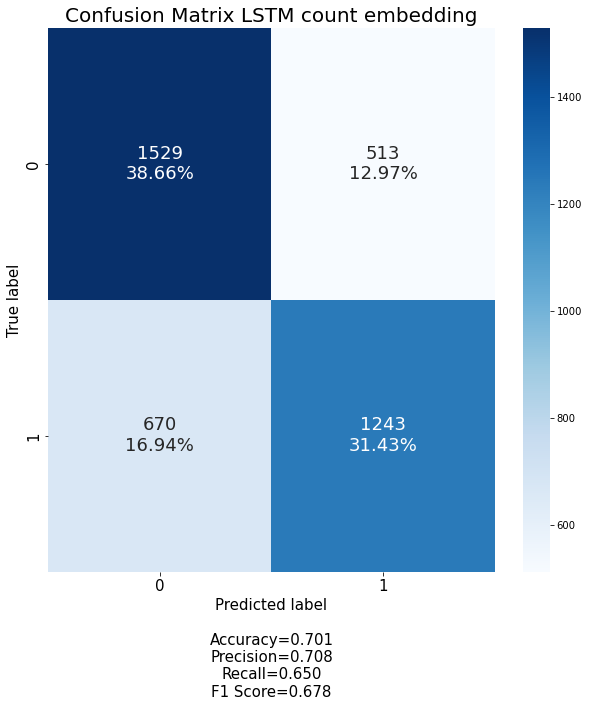

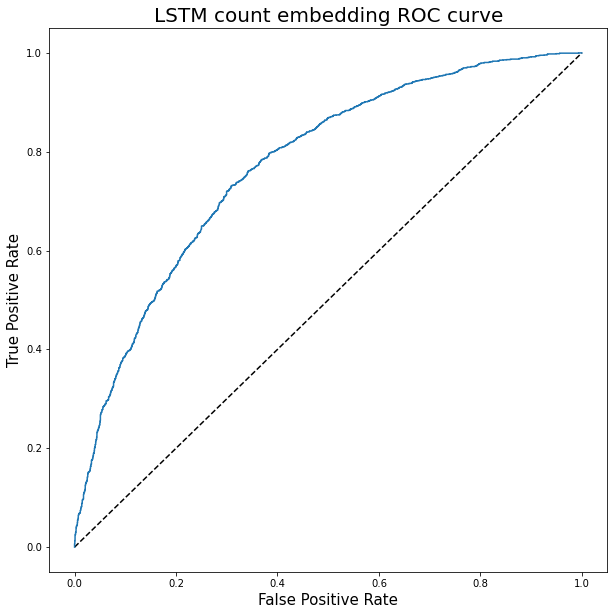

In [25]:
y_test_pred_proba_lstm = model.predict(
    X_test,
    batch_size=128
)

y_test_pred_lstm = [round(pred_proba[0]) for pred_proba in y_test_pred_proba_lstm]

print(classification_report(y_test, y_test_pred_lstm))

model_title = 'LSTM count embedding'
accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test, y_test_pred_lstm), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
# performing the roc curve calculations
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_lstm)
# Plotting the ROC Curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('{0} ROC curve'.format(model_title), size=20)
plt.show()

##### LSTM and Convolutional Neural Network for Sequence Classification on w2v with embedding layer

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_w2v, data.Target, train_size = 0.8, random_state = 1)


results_data_path = os.path.join("results")
model_name = "lstm_w2v_embedded"
model_file_path = os.path.join(results_data_path, model_name)
vocab_size = embedding_matrix_w2v.shape[0]
# Model constants.
max_features = 10000
sequence_length = 30
embedding_dim = 100

if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    
    # define NN model
    model = Sequential(name=model_name)
    
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix_w2v], input_length=100, trainable=False)
    model.add(embedding_layer)
    
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    # LSTM layer
    model.add(LSTM(units=100, dropout=0.2, return_sequences=True))
    # LSTM layer
    model.add(LSTM(units=25, dropout=0.2))
    
    model.add(Dense(25, activation="relu"))
    model.add(Dropout(0.2))
    # Classification layer
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy"
        ],
    )

    # fit NN model
    model.fit(
        X_train,
        y_train,
        epochs=20,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ],
    )

    model.save(model_file_path)


print(model.summary())

Epoch 1/20


2022-09-22 11:26:12.905156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 11:26:13.146257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 11:26:13.236220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 11:26:13.398167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 11:26:13.557308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.4941

2022-09-22 11:26:17.925284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 11:26:18.022589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 11:26:18.105019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 7s 46ms/step - loss: 0.6931 - accuracy: 0.4941 - val_loss: 0.6943 - val_accuracy: 0.4836
Epoch 2/20
99/99 [==============================] - 3s 34ms/step - loss: 0.6929 - accuracy: 0.5066 - val_loss: 0.6934 - val_accuracy: 0.4839
Epoch 3/20
99/99 [==============================] - 3s 33ms/step - loss: 0.6777 - accuracy: 0.5697 - val_loss: 0.6447 - val_accuracy: 0.6217
Epoch 4/20
99/99 [==============================] - 3s 33ms/step - loss: 0.6416 - accuracy: 0.6315 - val_loss: 0.6272 - val_accuracy: 0.6466
Epoch 5/20
99/99 [==============================] - 3s 33ms/step - loss: 0.6218 - accuracy: 0.6533 - val_loss: 0.6213 - val_accuracy: 0.6539
Epoch 6/20
99/99 [==============================] - 3s 33ms/step - loss: 0.6037 - accuracy: 0.6739 - val_loss: 0.6029 - val_accuracy: 0.6767
Epoch 7/20
99/99 [==============================] - 3s 33ms/step - loss: 0.5842 - accuracy: 0.6932 - val_loss: 0.5898 - val_accuracy: 0.6871
Epoch 8/20
99/99 [======

INFO:tensorflow:Assets written to: results/lstm_w2v_embedded/assets


Model: "lstm_w2v_embedded"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 100, 100)          1572300   
                                                                 
 conv1d_6 (Conv1D)           (None, 100, 32)           9632      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 50, 32)           0         
 1D)                                                             
                                                                 
 lstm_10 (LSTM)              (None, 50, 100)           53200     
                                                                 
 lstm_11 (LSTM)              (None, 25)                12600     
                                                                 
 dense_9 (Dense)             (None, 25)                650       
                                                 

2022-09-22 11:27:12.091361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 11:27:12.168243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 11:27:12.243289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 1s 18ms/step
              precision    recall  f1-score   support

           0       0.79      0.51      0.62      2042
           1       0.62      0.86      0.72      1913

    accuracy                           0.68      3955
   macro avg       0.71      0.68      0.67      3955
weighted avg       0.71      0.68      0.67      3955



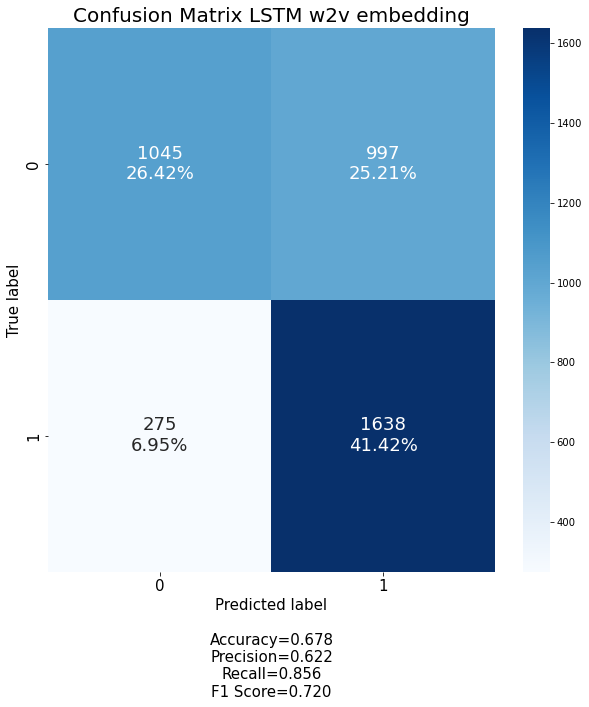

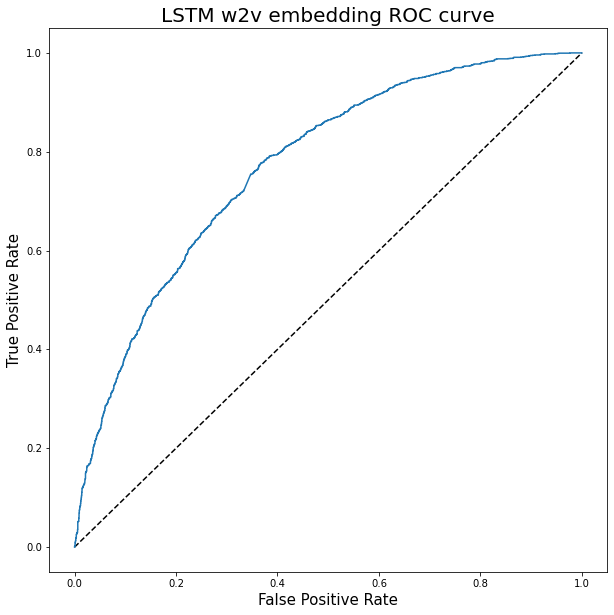

In [39]:
y_test_pred_proba_lstm = model.predict(
    X_test,
    batch_size=128
)

y_test_pred_lstm = [round(pred_proba[0]) for pred_proba in y_test_pred_proba_lstm]

print(classification_report(y_test, y_test_pred_lstm))

model_title = 'LSTM w2v embedding'
accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test, y_test_pred_lstm), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
# performing the roc curve calculations
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_lstm)
# Plotting the ROC Curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('{0} ROC curve'.format(model_title), size=20)
plt.show()

##### LSTM and Convolutional Neural Network for Sequence Classification on glove with embedding layer

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_glove, data.Target, train_size = 0.8, random_state = 1)


results_data_path = os.path.join("results")
model_name = "lstm_glove_embedded"
model_file_path = os.path.join(results_data_path, model_name)
vocab_size = embedding_matrix_glove.shape[0]
# Model constants.
max_features = 10000
sequence_length = 30
embedding_dim = 100
rnn_units = 100

if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    
    # define NN model
    model = Sequential(name=model_name)
    
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix_glove], input_length=100, trainable=False)
    model.add(embedding_layer)
    
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    # LSTM layer
    model.add(LSTM(units=100, dropout=0.2, return_sequences=True))
    # LSTM layer
    model.add(LSTM(units=25, dropout=0.2))
    
    model.add(Dense(25, activation="relu"))
    model.add(Dropout(0.2))
    # Classification layer
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy"
        ],
    )

    # fit NN model
    model.fit(
        X_train,
        y_train,
        epochs=20,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ],
    )

    model.save(model_file_path)


print(model.summary())

Model: "lstm_glove_embedded"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 100, 100)          1572300   
                                                                 
 conv1d_7 (Conv1D)           (None, 100, 32)           9632      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 50, 32)           0         
 1D)                                                             
                                                                 
 lstm_12 (LSTM)              (None, 50, 100)           53200     
                                                                 
 lstm_13 (LSTM)              (None, 25)                12600     
                                                                 
 dense_11 (Dense)            (None, 25)                650       
                                               

2022-09-22 11:28:57.521678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 11:28:57.606892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 11:28:57.684973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 1s 18ms/step
              precision    recall  f1-score   support

           0       0.76      0.66      0.71      2042
           1       0.68      0.78      0.73      1913

    accuracy                           0.72      3955
   macro avg       0.72      0.72      0.72      3955
weighted avg       0.72      0.72      0.72      3955



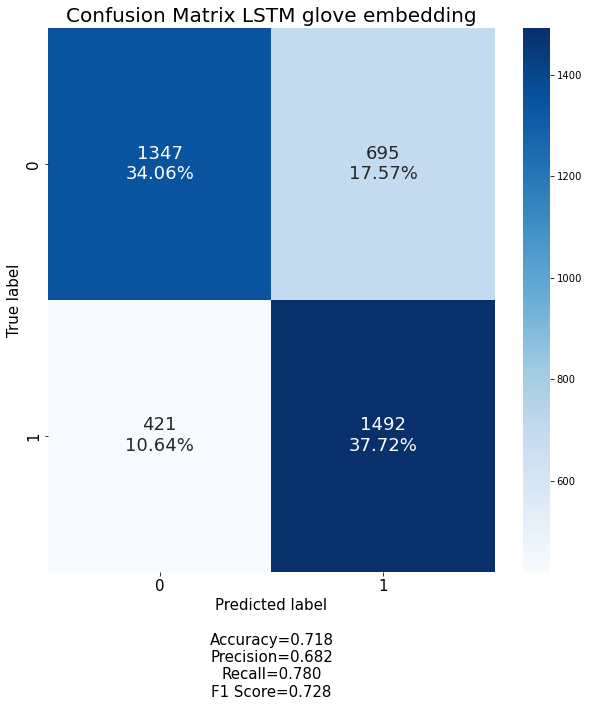

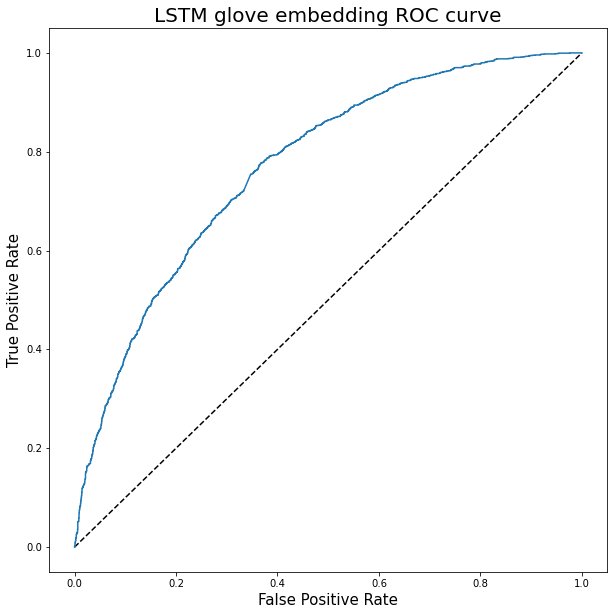

In [41]:
y_test_pred_proba = model.predict(
    X_test,
    batch_size=128
)

y_test_pred = [round(pred_proba[0]) for pred_proba in y_test_pred_proba]

print(classification_report(y_test, y_test_pred))

model_title = 'LSTM glove embedding'
accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test, y_test_pred), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
# performing the roc curve calculations
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_lstm)
# Plotting the ROC Curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('{0} ROC curve'.format(model_title), size=20)
plt.show()

#### Bidirectional LSTM
##### Bidirectional LSTM on word counting vector

In [49]:
X_train, X_test, y_train, y_test = train_test_split(data.CleanText, data.Target, train_size = 0.8, random_state = 1)

results_data_path = os.path.join("results")
model_name = "bidirectional_lstm_on_embedded"
model_file_path = os.path.join(results_data_path, model_name)

# Model constants.
max_features = 10000
sequence_length = 30
embedding_dim = 100


if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    # Define vectorizer
    vectorize_layer = TextVectorization(
        output_mode="int",
        max_tokens=max_features,
        output_sequence_length=sequence_length,
    )
    vectorize_layer.adapt(
        data.CleanText,
        batch_size=128,
    )

    # define NN model
    model = Sequential(name=model_name)
    model.add(Input(shape=(1,), dtype=tf.string))
    model.add(vectorize_layer)

    # Embedding layer
    model.add(
        Embedding(
            max_features,
            embedding_dim,
            input_length=sequence_length,
        )
    )
    
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.2)))
    
    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=25, dropout=0.2)))

    # Dense layers
    model.add(Dense(25, input_shape=(max_features,), activation="relu"))
    model.add(Dropout(0.5))

    # Classification layer
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy"
        ],
    )

    # fit NN model
    model.fit(
        X_train,
        y_train,
        epochs=10,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ]
    )

    model.save(model_file_path)


print(model.summary())

2022-09-22 11:36:34.317469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10


2022-09-22 11:36:37.303127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 11:36:37.749337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 11:36:37.759585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 11:36:37.892754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 11:36:37.903777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 11:36:38.134933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 11:36:38.152559: I tensorflow/core/grappler/optimizers/cust

99/99 [==============================] - ETA: 0s - loss: 0.6648 - accuracy: 0.5777

2022-09-22 11:36:46.819338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 11:36:46.978748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 11:36:46.986882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 11:36:47.071168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 11:36:47.079808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 13s 76ms/step - loss: 0.6648 - accuracy: 0.5777 - val_loss: 0.5863 - val_accuracy: 0.6918
Epoch 2/10
99/99 [==============================] - 5s 51ms/step - loss: 0.4964 - accuracy: 0.7782 - val_loss: 0.5486 - val_accuracy: 0.7219
Epoch 3/10
99/99 [==============================] - 5s 49ms/step - loss: 0.3560 - accuracy: 0.8574 - val_loss: 0.5885 - val_accuracy: 0.7102
Epoch 4/10
99/99 [==============================] - 5s 47ms/step - loss: 0.2590 - accuracy: 0.8985 - val_loss: 0.7139 - val_accuracy: 0.7095


INFO:tensorflow:Assets written to: results/bidirectional_lstm_on_embedded/assets


Model: "bidirectional_lstm_on_embedded"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_8 (TextV  (None, 30)               0         
 ectorization)                                                   
                                                                 
 embedding_17 (Embedding)    (None, 30, 100)           1000000   
                                                                 
 conv1d_10 (Conv1D)          (None, 30, 32)            9632      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 15, 32)           0         
 g1D)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 15, 200)          106400    
 nal)                                                            
                                    

2022-09-22 11:37:23.395411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 11:37:23.553351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 11:37:23.566092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 3/31 [=>............................] - ETA: 0s 

2022-09-22 11:37:23.672327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 11:37:23.681707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 2s 23ms/step
              precision    recall  f1-score   support

           0       0.72      0.75      0.73      2042
           1       0.72      0.68      0.70      1913

    accuracy                           0.72      3955
   macro avg       0.72      0.72      0.72      3955
weighted avg       0.72      0.72      0.72      3955



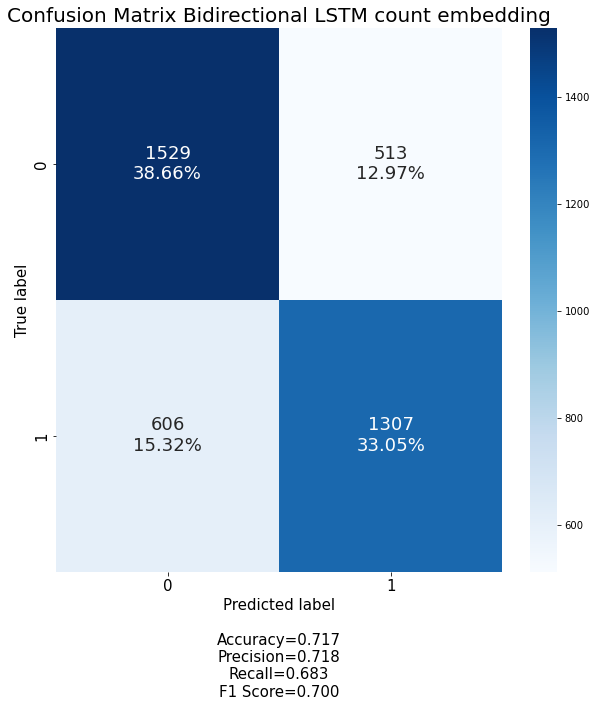

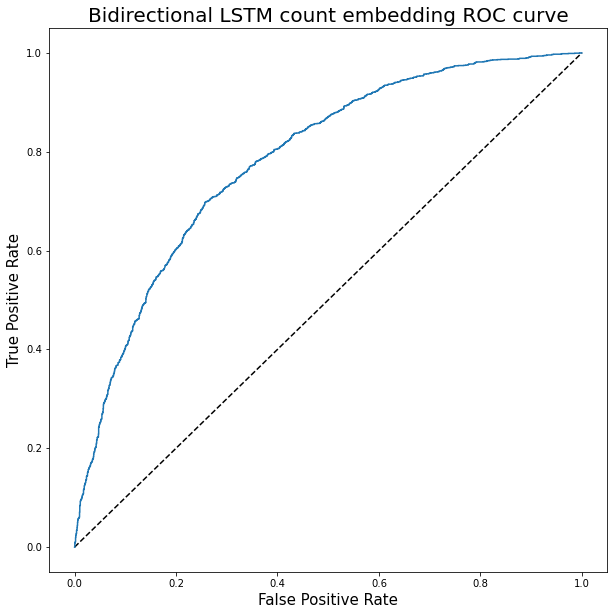

In [50]:
y_test_pred_proba_blstm = model.predict(
    X_test,
    batch_size=128
)

y_test_pred_blstm = [round(pred_proba[0]) for pred_proba in y_test_pred_proba_blstm]

print(classification_report(y_test, y_test_pred_blstm))
model_title = 'Bidirectional LSTM count embedding'
accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test, y_test_pred_blstm), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
# performing the roc curve calculations
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_blstm)
# Plotting the ROC Curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('{0} ROC curve'.format(model_title), size=20)
plt.show()

##### Bidirectional LSTM on Word2Vec

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_w2v, data.Target, train_size = 0.8, random_state = 1)


results_data_path = os.path.join("results")
model_name = "blstm_w2v_embedded"
model_file_path = os.path.join(results_data_path, model_name)
vocab_size = embedding_matrix_w2v.shape[0]
# Model constants.
max_features = 10000
sequence_length = 30
embedding_dim = 100
rnn_units = 100

if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    
    # define NN model
    model = Sequential(name=model_name)
    
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix_w2v], input_length=100, trainable=False)
    model.add(embedding_layer)
    
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.2)))
    
    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=25, dropout=0.2)))

    # Dense layers
    model.add(Dense(25, input_shape=(max_features,), activation="relu"))
    model.add(Dropout(0.5))


    
    # Classification layer
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy"
        ],
    )

    # fit NN model
    model.fit(
        X_train,
        y_train,
        epochs=30,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ],
    )

    model.save(model_file_path)


print(model.summary())

Epoch 1/30


2022-09-22 13:39:10.351787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 13:39:10.826495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 13:39:10.837397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 13:39:11.080604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 13:39:11.098291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 13:39:11.424703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 13:39:11.440101: I tensorflow/core/grappler/optimizers/cust

99/99 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4974

2022-09-22 13:39:20.929295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 13:39:21.097471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 13:39:21.105000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 13:39:21.283682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 13:39:21.292069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 16s 98ms/step - loss: 0.6932 - accuracy: 0.4974 - val_loss: 0.6935 - val_accuracy: 0.4836
Epoch 2/30
99/99 [==============================] - 6s 64ms/step - loss: 0.6932 - accuracy: 0.5061 - val_loss: 0.6926 - val_accuracy: 0.5164
Epoch 3/30
99/99 [==============================] - 7s 67ms/step - loss: 0.6850 - accuracy: 0.5540 - val_loss: 0.6614 - val_accuracy: 0.6087
Epoch 4/30
99/99 [==============================] - 7s 66ms/step - loss: 0.6435 - accuracy: 0.6310 - val_loss: 0.6298 - val_accuracy: 0.6523
Epoch 5/30
99/99 [==============================] - 6s 65ms/step - loss: 0.6186 - accuracy: 0.6625 - val_loss: 0.6128 - val_accuracy: 0.6700
Epoch 6/30
99/99 [==============================] - 6s 65ms/step - loss: 0.6028 - accuracy: 0.6798 - val_loss: 0.5906 - val_accuracy: 0.6871
Epoch 7/30
99/99 [==============================] - 6s 64ms/step - loss: 0.5815 - accuracy: 0.7019 - val_loss: 0.5916 - val_accuracy: 0.6723
Epoch 8/30
99/99 [=====

INFO:tensorflow:Assets written to: results/blstm_w2v_embedded/assets


Model: "blstm_w2v_embedded"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 100, 100)          1572300   
                                                                 
 conv1d_11 (Conv1D)          (None, 100, 32)           9632      
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 50, 32)           0         
 g1D)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 50, 200)          106400    
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 50)               45200     
 nal)                                                            
                                                

2022-09-22 13:45:32.832237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 13:45:32.976790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 13:45:33.001700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/31 [..............................] - ETA: 31s

2022-09-22 13:45:33.199752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 13:45:33.214417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 2s 40ms/step
              precision    recall  f1-score   support

           0       0.72      0.75      0.73      2042
           1       0.72      0.68      0.70      1913

    accuracy                           0.72      3955
   macro avg       0.72      0.72      0.72      3955
weighted avg       0.72      0.72      0.72      3955



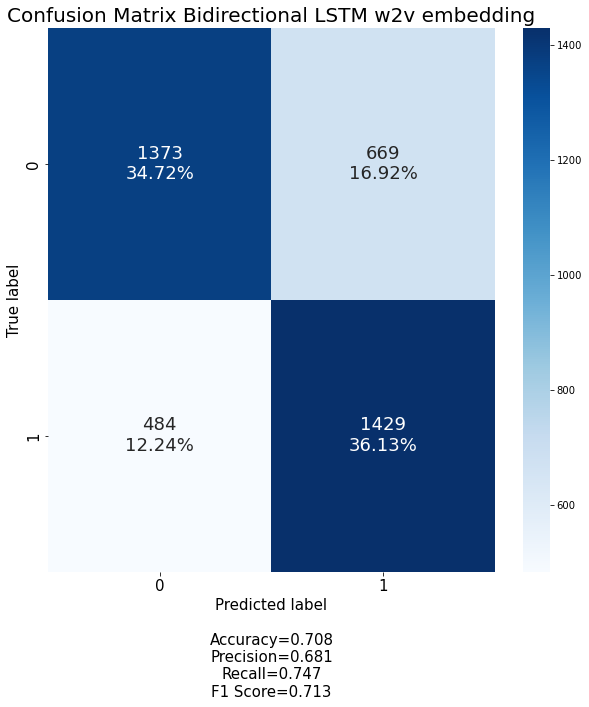

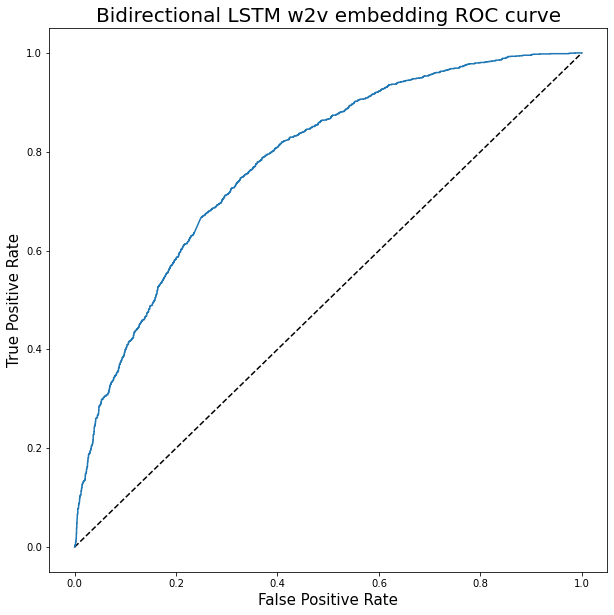

In [52]:
y_test_pred_proba = model.predict(
    X_test,
    batch_size=128
)

y_test_pred = [round(pred_proba[0]) for pred_proba in y_test_pred_proba]

print(classification_report(y_test, y_test_pred_blstm))
model_title = 'Bidirectional LSTM w2v embedding'
accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test, y_test_pred), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
# performing the roc curve calculations
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
# Plotting the ROC Curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('{0} ROC curve'.format(model_title), size=20)
plt.show()

##### Bidirectional LSTM on Glove

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_glove, data.Target, train_size = 0.8, random_state = 1)


results_data_path = os.path.join("results")
model_name = "blstm_glove_embedded"
model_file_path = os.path.join(results_data_path, model_name)
vocab_size = embedding_matrix_glove.shape[0]
# Model constants.
max_features = 10000
sequence_length = 30
embedding_dim = 100

if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    
    # define NN model
    model = Sequential(name=model_name)
    
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix_glove], input_length=100, trainable=False)
    model.add(embedding_layer)
    
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.2)))
    
    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=25, dropout=0.2)))

    # Dense layers
    model.add(Dense(25, input_shape=(max_features,), activation="relu"))
    model.add(Dropout(0.5))

    
    # Classification layer
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy"
        ],
    )

    # fit NN model
    model.fit(
        X_train,
        y_train,
        epochs=30,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ],
    )

    model.save(model_file_path)


print(model.summary())

2022-09-22 13:49:54.904762: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-22 13:49:54.905030: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
Epoch 1/30


2022-09-22 13:49:55.544981: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-22 13:49:58.173889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 13:49:58.611868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 13:49:58.622435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 13:49:58.773756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 13:49:58.785031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 13:49:58.996181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

99/99 [==============================] - ETA: 0s - loss: 0.6520 - accuracy: 0.6144

2022-09-22 13:50:06.921137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 13:50:07.080818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 13:50:07.088541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 13:50:07.207666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-22 13:50:07.216472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 13s 78ms/step - loss: 0.6520 - accuracy: 0.6144 - val_loss: 0.6109 - val_accuracy: 0.6650
Epoch 2/30
99/99 [==============================] - 6s 62ms/step - loss: 0.6021 - accuracy: 0.6857 - val_loss: 0.5929 - val_accuracy: 0.6852
Epoch 3/30
99/99 [==============================] - 6s 62ms/step - loss: 0.5782 - accuracy: 0.7089 - val_loss: 0.5783 - val_accuracy: 0.7045
Epoch 4/30
99/99 [==============================] - 6s 61ms/step - loss: 0.5627 - accuracy: 0.7217 - val_loss: 0.5727 - val_accuracy: 0.7023
Epoch 5/30
99/99 [==============================] - 6s 61ms/step - loss: 0.5431 - accuracy: 0.7327 - val_loss: 0.5678 - val_accuracy: 0.7058
Epoch 6/30
99/99 [==============================] - 6s 61ms/step - loss: 0.5226 - accuracy: 0.7467 - val_loss: 0.5650 - val_accuracy: 0.7016
Epoch 7/30
99/99 [==============================] - 6s 61ms/step - loss: 0.5150 - accuracy: 0.7526 - val_loss: 0.5775 - val_accuracy: 0.7073
Epoch 8/30
99/99 [=====

INFO:tensorflow:Assets written to: results/blstm_glove_embedded/assets


Model: "blstm_glove_embedded"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1572300   
                                                                 
 conv1d (Conv1D)             (None, 100, 32)           9632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 32)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          106400    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 50)               45200     
 nal)                                                            
                                              

31/31 [==============================] - 1s 27ms/step
              precision    recall  f1-score   support

           0       0.76      0.61      0.68      2042
           1       0.66      0.80      0.72      1913

    accuracy                           0.70      3955
   macro avg       0.71      0.71      0.70      3955
weighted avg       0.71      0.70      0.70      3955



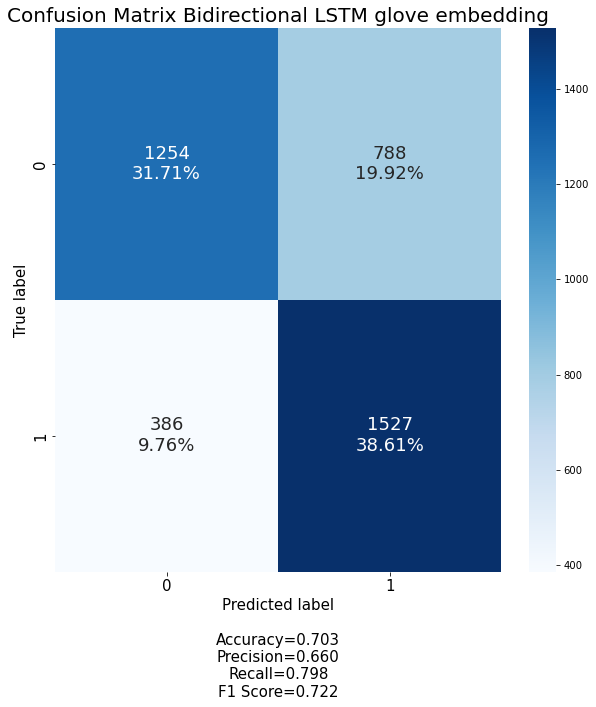

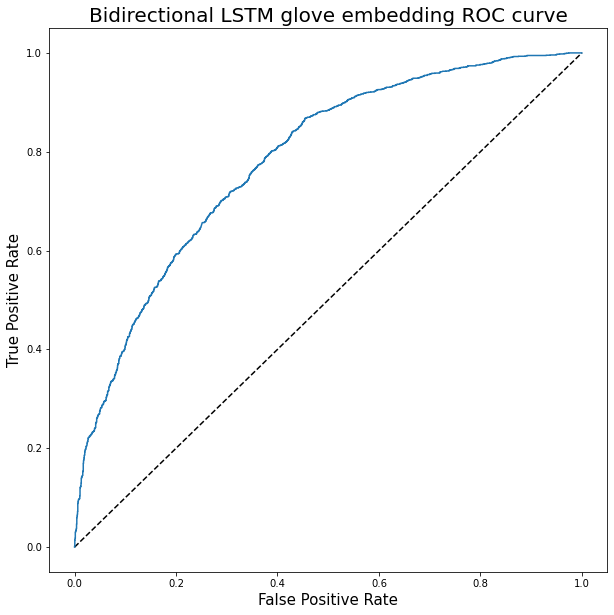

In [20]:
y_test_pred_proba = model.predict(
    X_test,
    batch_size=128
)

y_test_pred = [round(pred_proba[0]) for pred_proba in y_test_pred_proba]

print(classification_report(y_test, y_test_pred))
model_title = 'Bidirectional LSTM glove embedding'
accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test, y_test_pred), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
# performing the roc curve calculations
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
# Plotting the ROC Curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('{0} ROC curve'.format(model_title), size=20)
plt.show()

## Advanced BERT model

In [24]:
data = pd.read_pickle("data/processed/processed_nlp_data_3.pkl.gz")

In [25]:
data.head()

Target                                               Text  \
0       0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1       0  is upset that he can't update his Facebook by ...   
2       0  @Kenichan I dived many times for the ball. Man...   
3       0    my whole body feels itchy and like its on fire    
4       0  @nationwideclass no, it's not behaving at all....   

                                      CleanTextSpacy  \
0  @switchfoot awww bummer shoulda get david carr...   
1  upset update facebook texte cry result school ...   
2    @kenichan dive time ball manage save rest bound   
3                          body feel itchy like fire   
4                        @nationwideclass behave mad   

                                           CleanText  
0             awww bummer shoulda get david carr day  
1  upset update facebook texte cry result school ...  
2              dive time ball manage save rest bound  
3                          body feel itchy like fire  
4                                         behave mad

In [11]:
data = data[data.CleanText!='']

First we set the pretrained model for fine-tuning. Load the BERT tokenizer and the suitable BERT model. There are multimple pretrained models defined by google. However for classification tasc we use  TFBertForSequenceClassification and bert-base-uncased.

In [26]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /Users/bartcus/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /Users/bartcus/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/bartcus/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005b

In [13]:
'''
def tokenize_text(text):
    tokenized_sequence = bert_tokenizer.encode_plus(text, 
                                               add_special_tokens = True,
                                               max_length =30,
                                               pad_to_max_length = True,
                                               return_attention_mask = True)
    return tokenized_sequence

pandarallel.initialize()
data['Tokens_sequence'] = data.CleanText.parallel_apply(lambda x: tokenize_text(x))
'''

"\ndef tokenize_text(text):\n    tokenized_sequence = bert_tokenizer.encode_plus(text, \n                                               add_special_tokens = True,\n                                               max_length =30,\n                                               pad_to_max_length = True,\n                                               return_attention_mask = True)\n    return tokenized_sequence\n\npandarallel.initialize()\ndata['Tokens_sequence'] = data.CleanText.parallel_apply(lambda x: tokenize_text(x))\n"

Let us prepare the data for BERT model, where sentences contain the entire text data and labels contain all the corresponding labels.

In [27]:
sentences=data['CleanText']
labels=data['Target']
len(sentences),len(labels)

(19855, 19855)

In [28]:
input_ids=[]
attention_masks=[]
token_type_ids=[]

for sent in sentences:
    bert_inp=bert_tokenizer.encode_plus(sent,
                                        add_special_tokens = True,
                                        max_length = 64,
                                        pad_to_max_length = True,
                                        return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])
    token_type_ids.append(bert_inp['token_type_ids'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
token_type_ids=np.array(token_type_ids)
labels=np.array(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [29]:
len(input_ids),len(attention_masks),len(labels), len(token_type_ids)

(19855, 19855, 19855, 19855)

In [17]:
train_inp, val_inp, train_label, val_label, train_mask, val_mask = train_test_split(
    input_ids,
    labels,
    attention_masks,
    test_size=0.2
)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))

Train inp shape (15818, 64) Val input shape (3955, 64)
Train label shape (15818,) Val label shape (3955,)
Train attention mask shape (15818, 64) Val attention mask shape (3955, 64)


In [18]:
'''
texts_train, texts_test, input_ids_train, input_ids_test, attention_mask_train, attention_mask_test,token_type_ids_train,token_type_ids_test, labels_train, labels_test = train_test_split(
    data.CleanText.values,
    input_ids, 
    attention_masks,
    token_type_ids,
    labels,
    test_size=0.2
)
'''

'\ntexts_train, texts_test, input_ids_train, input_ids_test, attention_mask_train, attention_mask_test,token_type_ids_train,token_type_ids_test, labels_train, labels_test = train_test_split(\n    data.CleanText.values,\n    input_ids, \n    attention_masks,\n    token_type_ids,\n    labels,\n    test_size=0.2\n)\n'

In [30]:
train_inp, val_inp, train_label, val_label, train_mask, val_mask = train_test_split(
    input_ids,
    labels,
    attention_masks,
    test_size=0.2
)


log_dir='logs/tb_bert'
results_data_path = os.path.join("results")
model_name='bert_model.h5'
model_file_path = os.path.join(results_data_path, model_name)



# defining model
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_file_path,
                                                save_weights_only=True,
                                                monitor='val_loss',
                                                mode='min',
                                                save_best_only=True),
            keras.callbacks.TensorBoard(log_dir=log_dir)]

print('\nBert Model',bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,
                   optimizer=optimizer,
                    metrics=[metric])

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/bartcus/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/tf_model.h5 from cac

Metal device set to: Apple M1 Pro


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________

Bert Model None


In [32]:
history=bert_model.fit([train_inp,train_mask], 
                       train_label, 
                       batch_size=128, 
                       epochs=4,
                       validation_data=([val_inp,val_mask],val_label),
                       callbacks=callbacks)

Epoch 1/4
125/125 [==============================] - ETA: 0s - loss: 0.5796 - accuracy: 0.6929

2022-09-29 08:58:09.962313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 375s 3s/step - loss: 0.5796 - accuracy: 0.6929 - val_loss: 0.5083 - val_accuracy: 0.7530
Epoch 2/4
125/125 [==============================] - 444s 4s/step - loss: 0.4964 - accuracy: 0.7607 - val_loss: 0.5006 - val_accuracy: 0.7623
Epoch 3/4
125/125 [==============================] - 555s 4s/step - loss: 0.4474 - accuracy: 0.7924 - val_loss: 0.5257 - val_accuracy: 0.7658
Epoch 4/4
125/125 [==============================] - 470s 4s/step - loss: 0.3888 - accuracy: 0.8278 - val_loss: 0.5440 - val_accuracy: 0.7532


In [33]:
model_name='bert_model.h5'
results_data_path = os.path.join("results")
model_file_path = os.path.join(results_data_path, model_name)

trained_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
trained_model.load_weights(model_file_path)

preds = trained_model.predict([val_inp, val_mask],batch_size=128)
pred_labels = np.argmax(preds.logits, axis=1)#preds.argmax(axis=1)
f1 = f1_score(val_label, pred_labels)
print('F1 score',f1)
print('Classification Report')
print(classification_report(val_label,pred_labels))

print('Training and saving built model.....')   

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/bartcus/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/tf_model.h5 from cac

32/32 [==============================] - 27s 691ms/step
F1 score 0.7666831438457736
Classification Report
              precision    recall  f1-score   support

           0       0.79      0.73      0.76      2017
           1       0.74      0.79      0.77      1954

    accuracy                           0.76      3971
   macro avg       0.76      0.76      0.76      3971
weighted avg       0.76      0.76      0.76      3971

Training and saving built model.....


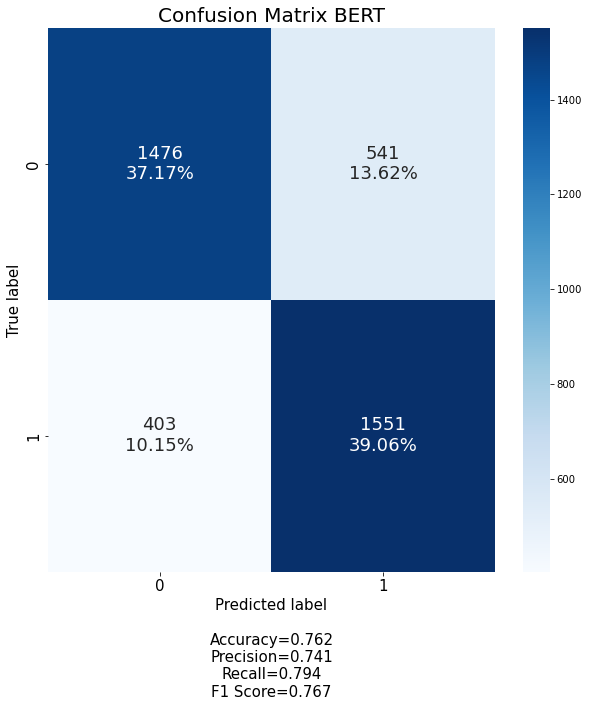

In [34]:
model_title = 'BERT'
accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(val_label, pred_labels), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))

In [7]:
import os
from flask import Flask, request, render_template, jsonify
from tensorflow.keras.models import load_model
import numpy as np
import keras
from transformers import *
import numpy as np

model_name='bert_model.h5'
results_data_path = os.path.join("results")
model_file_path = os.path.join(results_data_path, model_name)

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)
trained_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
trained_model.load_weights(model_file_path)

preds = trained_model.predict([val_inp, val_mask],batch_size=128)
pred_labels = np.argmax(preds.logits, axis=1)#preds.argmax(axis=1)
f1 = f1_score(val_label, pred_labels)
print('F1 score',f1)
print('Classification Report')
print(classification_report(val_label,pred_labels))

print('Training and saving built model.....')   

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/bartcus/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/tf_model.h5 from cac

NameError: name 'val_inp' is not defined

In [5]:
bert_model

NameError: name 'bert_model' is not defined

In [40]:
data = pd.read_pickle("data/processed/processed_nlp_data_full.pkl.gz")
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
sentences=data['CleanText']
labels=data['Target']
len(sentences),len(labels)
input_ids=[]
attention_masks=[]
token_type_ids=[]

for sent in sentences:
    bert_inp=bert_tokenizer.encode_plus(sent,
                                        add_special_tokens = True,
                                        max_length = 64,
                                        pad_to_max_length = True,
                                        return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])
    token_type_ids.append(bert_inp['token_type_ids'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
token_type_ids=np.array(token_type_ids)
labels=np.array(labels)

loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /Users/bartcus/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /Users/bartcus/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/bartcus/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005b

In [41]:
train_inp, val_inp, train_label, val_label, train_mask, val_mask = train_test_split(
    input_ids,
    labels,
    attention_masks,
    test_size=0.2
)


log_dir='logs/tb_bert'
results_data_path = os.path.join("results")
model_name='bert_model_full.h5'
model_file_path = os.path.join(results_data_path, model_name)



# defining model
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_file_path,
                                                save_weights_only=True,
                                                monitor='val_loss',
                                                mode='min',
                                                save_best_only=True),
            keras.callbacks.TensorBoard(log_dir=log_dir)]

print('\nBert Model',bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,
                   optimizer=optimizer,
                    metrics=[metric])

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/bartcus/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/tf_model.h5 from cac

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________

Bert Model None


In [42]:
history=bert_model.fit([train_inp,train_mask], 
                       train_label, 
                       batch_size=128, 
                       epochs=4,
                       validation_data=([val_inp,val_mask],val_label),
                       callbacks=callbacks)

Epoch 1/4


2022-10-05 10:46:04.800472: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-05 10:46:10.765041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 788/9925 [=>............................] - ETA: 14:47:11 - loss: 0.5146 - accuracy: 0.7425


KeyboardInterrupt

